#### Introduction

#### Method
Add batch normalization

In [1]:
import tensorflow as tf
import numpy as np
import gym

# reproducible
np.random.seed(1)
tf.set_random_seed(1)

#### Build A Noliner Function
#### 构建一个非线性函数

In [2]:
def y_fun( x ):
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
#     return np.cos(x0) + x1**2 + x1*x2 + np.sin(x3) + x4**3 +x4*x5*x6**2
    return -(x0-10)**2 -(x1-20)**2 -(x2-30)**2 -(x3-40)**2 -(x4-50)**2 -(x5-60)**2 -(x6-70)**2

#### DDPG Algorithm

In [3]:
"""
View more on the tutorial page: https://morvanzhou.github.io/tutorials/
"""

import tensorflow as tf
import numpy as np
import gym

# reproducible
np.random.seed(1)
tf.set_random_seed(1)
#####################  hyper parameters  ####################


MAX_EP_STEPS = 500
LR_A = 0.001    # learning rate for actor
LR_C = 0.002    # learning rate for critic
GAMMA = 0.9     # reward discount
TAU = 0.01      # soft replacement
MEMORY_CAPACITY = 10000
BATCH_SIZE = 32

RENDER = False

###############################  DDPG  ####################################

class DDPG(object):
    def __init__(self):
        self.x_dim = x_dim = 7
        self.memory = np.zeros((MEMORY_CAPACITY, x_dim+1), dtype=np.float32)
        self.pointer = 0
        self.sess = tf.Session()
#         self.var = 3.0
        # self.a_replace_counter, self.c_replace_counter = 0, 0

#         self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,


        self.one = tf.placeholder(tf.float32, [None, 1], 'one')
#         self.x = tf.placeholder(tf.float32, [None, x_dim], 'x')
        self.y = tf.placeholder(tf.float32, [None, 1], 'y')

        with tf.variable_scope('Actor'):
            self.x = self.build_a_nn(self.one, scope='eval', trainable=True)
#             a_ = self.build_a_nn(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            # assign self.a = a in memory when calculating q for td_error,
            # otherwise the self.a is from Actor when updating Actor
            self.y_pred = self.build_c_nn(self.x, scope='eval', trainable=True)

        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
            
        td_error = tf.losses.mean_squared_error(labels=(self.y), predictions=self.y_pred)
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error, name="adam-ink",  var_list = self.ce_params)

        a_loss = - tf.reduce_mean(self.y_pred)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)

        tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

       

    def choose_action(self, s):
#         a = self.sess.run(self.x, {self.one: s[np.newaxis, :]})[0]
        a = self.sess.run(self.x, {self.one: [[1.]]})[0]
#         a = np.clip(np.random.normal(a, self.var), -2, 2)
        
        return a

    def learn(self):
        # soft target replacement
#         self.sess.run(self.soft_replace)

        indices = np.random.choice( min(MEMORY_CAPACITY, self.pointer) , size=BATCH_SIZE)
        bt = self.memory[indices, :]
        bx = bt[:, :self.x_dim]
        by = bt[:, -1:]

        self.sess.run(self.atrain, {self.one: np.ones( (32,1) ) })
        self.sess.run(self.ctrain, {self.x: bx, self.y: by })

    def store_transition(self, x,y):
        trans = np.hstack( (x, y) )
        
        index = self.pointer % MEMORY_CAPACITY
        self.memory[index, :] = trans
        self.pointer += 1

        if self.pointer > 100:
            self.learn()
            
    def build_a_nn(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 30, activation = tf.nn.relu, name = 'l1', trainable = trainable)
            l2 = tf.layers.dense(l1, 30, activation = tf.nn.relu, name = 'l2', trainable = trainable)
            a = tf.layers.dense(l2, self.x_dim, name = 'a', trainable = trainable)     
            return a #tf.multiply(a, self.a_bound, name = "scaled_a")  
    def build_c_nn(self, x, scope, trainable):
        # Critic Q-leaning
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(x, 30, activation = tf.nn.relu, name = 'l1', trainable = trainable)
            l2 = tf.layers.dense(l1, 30, activation = tf.nn.relu, name = 'l2', trainable = trainable)
            y = tf.layers.dense(l2, 1, name = 'a', trainable = trainable)     
            return y #tf.multiply(a, self.a_bound, name = "scaled_a")  

    
###############################  training  ####################################


In [4]:
agent = DDPG()

In [5]:
for i in range(100):
    x = np.random.rand( agent.x_dim )*100
#     print("x: ", x)
    y = y_fun(x)
    
    agent.store_transition(x, y)

In [6]:
from tqdm import trange

In [7]:
best_value_save = []

In [13]:
for i in trange(10000):
#     x = np.random.rand( agent.x_dim )*100
    
    x = agent.choose_action( [1.] )
    
    print( np.random.normal(x, 10.) )
#     print("x: ", x)
    y = y_fun(x)
    
    agent.store_transition(x, y)
    
    if (i+1)%10 == 0:
        x = agent.choose_action( [1.] )
        print("i: ", i, "best value: ", y_fun(x))
        best_value_save.append( y_fun(x) )

  0%|          | 29/10000 [00:00<00:35, 284.36it/s]

[  6.4744932   14.12747201  12.16052863  41.772738    61.85023068
  50.73534735  90.81995175]
[ 10.85761307  25.05932767  27.30437196  63.06440553  63.43739933
  38.34249872  59.45442693]
[ -6.41613043  33.22830125  25.26148205  50.77574443  70.4991953
  35.17229392  89.58878944]
[ -4.18158801  39.09870615  23.02160173  49.22335951  55.41499001
  32.09074223  79.31792548]
[ -7.27651644  16.96011978  28.51693881  41.05117734  59.49355355
  51.42255059  84.90568934]
[ -7.7046029    6.35481779  29.46915645  37.64394783  67.52480242
  33.60574311  84.66705383]
[-11.50711002  43.88582337  25.0391183   45.24680604  69.30991377
  25.67714982  69.03342785]
[ -5.37718686  31.32696805  38.71687569  53.11478628  62.34389264
  26.72275868  73.67805319]
[ 19.43794427  -1.85474758  34.32510643  59.25387166  67.84384471
  43.26562841  96.05234019]
[ -2.12488645  15.41224171  10.91697018  29.26190931  66.2280346
  42.14665239  73.58653096]
i:  9 best value:  -1037.66228363
[-11.61149027  30.12265028  

  1%|          | 108/10000 [00:00<00:36, 267.90it/s]

[ -2.12315392  29.5780906   25.66523727  39.49389257  73.90506726
  28.01267872  85.08218433]
[-14.98256988  17.87199977   9.42077886  50.12459418  69.18667141
  42.07322699  73.87721993]
[  0.65705542  22.45362638  19.36048138  52.93827671  65.16089511
  59.29679249  87.64536064]
[-14.56931456  25.48166817  27.38023961  54.07916428  53.45140964
  44.10879733  65.86622299]
[  0.29523456  29.19566587  32.50929837  57.57250393  62.69738919
  27.52696864  58.00119319]
[  3.62048625  22.06522376   8.18650416  59.06511959  67.07072686
  38.62273197  76.70507266]
[ 10.77522906  22.12368116  26.53566548  45.038632    61.82658632
  30.41982199  71.67033086]
i:  59 best value:  -1013.21319276
[ -6.3896086   20.37352293  29.13801196  50.31487334  89.61482132
  53.11899596  61.55848793]
[ -9.30845634  15.40895472  25.88765142  48.8168857   34.71848251
  29.72970694  75.21532934]
[  0.30729757  27.24103397  25.75742414  43.26900421  79.05040298
  35.65960468  64.57762256]
[-11.8006638   30.3365824

  2%|▏         | 161/10000 [00:00<00:37, 265.64it/s]

[  1.52140845  37.15983377  31.33691513  49.78394918  69.17309327
  39.0644388   66.23150748]
[  7.88806798   9.72410922  20.7346072   48.99051435  48.42872623
  24.8791769   83.1114747 ]
i:  109 best value:  -1016.34528125
[ -1.64393411  20.84789839  28.75892551  33.33718514  56.44176956
  42.42598484  83.95394492]
[ 19.59575254  22.92927533  28.51291051  62.47091921  61.68438342
  49.95145928  70.99408278]
[   5.30702321    6.66210733   32.11608877   66.60814725   66.54771391
   57.88021908  105.00402798]
[ -1.17781747  11.57093619  17.50929544  49.65891681  73.94683906
  38.58112097  93.30621157]
[ -0.50093446  38.78897557  41.33265842  45.99725888  76.36062095
  31.73230402  81.32910954]
[-19.00271117  28.27436741   9.73066558  36.81533534  86.440698
  33.22436427  80.90834537]
[ 10.86833264  39.1748727   17.31551512  62.61988434  74.6679598
  21.84861506  87.59439862]
[-23.16099019  26.15350343  23.93597032  51.9286686   77.8051993
  27.24667507  72.95432124]
[  -5.27342076   -3.2

  2%|▏         | 214/10000 [00:00<00:37, 264.31it/s]

[  1.90298733  32.14168714  43.9005509   51.96121146  74.27237833
  39.40917053  85.41100624]
[  3.40964195  51.01670834  14.72080993  61.71310063  67.94880351
  37.60721012  55.70420734]
[  5.24452706  21.08474119  24.47580986  48.35613606  57.6097734
  50.54208107  87.64628796]
[-12.8299689   26.07551549  15.79468478  28.7089111   55.42312046
  32.53597914  90.47854796]
[ 21.89299799  29.58277038  12.95012     66.97010593  74.87163265
  38.1737689   90.78950577]
[ -7.8272454   19.94993491  17.67850183  47.13015742  61.62020926
  27.03294185  72.35340435]
[  0.55828056  18.63081361  22.88316976  67.30631626  70.74694478
  37.17821827  82.02793252]
[ -5.46880629  21.93021283  33.87921138  42.03164774  57.87361389
  48.10628183  75.96460701]
[ 12.46712014  26.65691091  11.21606087  71.88140112  75.26027915
  36.08228136  82.25512245]
i:  169 best value:  -1015.1964161
[ -4.0256423   10.91001826  29.45162465  46.82101703  52.80614692
  43.15125893  78.7718055 ]
[ -0.09853559  28.37013522

  2%|▏         | 240/10000 [00:00<00:37, 262.64it/s]

[ 10.85649531  23.00367208  21.00215926  53.11445124  52.60889277
  45.63197104  73.87805126]
[  8.31503087  10.44942174  26.36380056  44.1547814   76.73683917
  42.79876746  88.11540044]
[ 19.31295096  31.15432396  20.25243615  44.80888982  69.99729933
  54.87933324  68.25484732]
[  1.30151212  36.35801791  18.62269512  50.52190516  88.70693209
  41.28629224  79.22035606]
[-13.04450629  15.40462915  37.47066272  62.50335299  72.25538103
  26.59742711  75.97411524]
[ -6.2331544    0.54617891  22.38744789  54.34647222  74.30205871
  41.49445904  74.34676537]
i:  219 best value:  -1008.59760315
[ -2.91575595  22.62711947  23.03557878  52.64089155  70.24714783
  34.36311588  85.20937673]
[  0.67604956  28.88173132  31.45487308  51.33299862  60.19323925
  41.75706161  74.46966278]
[ 20.24327287  31.0852646   23.50794519  41.55377304  64.50415937
  45.0035619   88.06677624]
[ 14.57824735  30.40228421  13.8395601   56.27297657  71.30939809
  37.3144871   65.03888278]
[ -6.27491066  24.794671

  3%|▎         | 293/10000 [00:01<00:37, 261.84it/s]

[  8.13903593  39.45766692  11.75743328  43.88054967  68.59901422
  16.14214322  73.56174539]
[  7.14838439  22.88278547  20.3072922   60.46578981  57.18469079
  53.47408253  87.50400516]
[ 18.87820517  30.07174527  37.07345568  62.41181483  65.65506013
  19.23725333  79.97837917]
[  5.70423289  42.45062903  23.39563786  53.70135462  62.07975785
  28.67293365  99.4557968 ]
i:  269 best value:  -1027.52072332
[ -4.61418494e-02   1.90394138e+01   2.33574909e+01   3.40075738e+01
   4.19463986e+01   5.53988625e+01   9.51823726e+01]
[  6.51675707  30.31804705  24.50009503  32.21039889  60.92407902
  32.07751498  86.89826588]
[  6.89172647  18.60387513  21.65049171  55.69306637  59.1416353
  18.87752139  65.45892943]
[  0.23331622  23.98160975  18.85089757  38.96661848  79.19351746
  42.90861183  78.30185922]
[ 11.27531667  43.11704667  19.91719293  50.77388547  89.61882455
  40.80813882  76.40518588]
[ -1.78126028  19.66467304  13.2129953   58.28241688  62.3873338
  40.29676502  87.40746934

  3%|▎         | 345/10000 [00:01<00:37, 259.04it/s]

[  7.98131699  40.06118133  30.1313702   50.55857703  52.87933733
  26.53781993  74.81833666]
[  7.83223929  28.37594426  30.14133955  51.06620338  78.15954972
  53.67679765  82.70209312]
i:  319 best value:  -1027.75550276
[ -8.45838247  43.91024194  22.65881874  40.64523577  54.48150684
  40.6869008   73.36639446]
[  4.55429953  33.7813677   30.29746828  52.0503865   55.4483126
  44.79021905  73.52159431]
[  1.07633457   5.79278572  23.29153131  58.50237718  83.12479775  42.69006
  82.88398237]
[  3.40772458  18.44456449  28.73272889  52.77198497  77.34016138
  37.23208024  90.27597536]
[ -4.76915765  32.80670152  28.72026795  32.68682131  61.36721352
  39.82734831  85.9931459 ]
[ -0.6593765   26.91182743  17.7522027   66.88609602  60.48515955
  62.43574578  78.89989011]
[ 17.82235183  39.14684657  18.88648939  38.81094213  56.12172554
  56.84555894  71.16141071]
[  0.20832362  34.36692454  32.09584326  49.21281253  59.0994565
  34.65015887  82.67097503]
[  3.18631227  27.12974925  3

  4%|▍         | 397/10000 [00:01<00:37, 258.04it/s]


[ -3.15304123  29.04180853  15.15493981  72.18727816  59.65290445
  14.81574811  85.72920412]
[ -0.88802118  24.96744526  24.45354406  40.43665847  75.63516793
  29.67822012  93.44326252]
[ 12.56977257  17.67723722  29.03951913  61.85907334  75.38317712
  37.78613617  77.26375011]
i:  369 best value:  -1027.12713473
[ -0.84745761  15.98373376  22.29480741  43.6320469   80.04230908
  20.51911566  87.24831922]
[-11.2524924   15.26094155  23.62405064  49.61605805  50.98773136
  28.19308374  65.29282404]
[-13.05874893  47.4850789   24.98782337  55.17203161  60.61144583
   4.96774804  81.90630013]
[ 16.29711792  26.52370395  40.36192697  62.038074    81.15366803
  46.42205029  92.34189823]
[ 18.06733242  23.56574207  20.47127575  49.18873246  78.55024381
  48.19600633  58.99410548]
[ 10.89599191  21.72608348  41.17325263  71.05735652  74.77620133
  49.80042493  67.4328774 ]
[ 16.53229344  31.9310128   22.28357834  50.42763968  55.342484
  31.71364214  89.74258541]
[ 13.56230078  24.1347996

  4%|▍         | 450/10000 [00:01<00:37, 257.94it/s]

419 best value:  -1049.82233406
[  2.11285946   7.13009726  31.79600156  55.15373741  59.1722061
  54.49614192  98.43383408]
[ -6.88846519  20.54658837  36.76900246  44.55106859  53.03343246
  36.80480072  81.29592575]
[ -4.90407188  24.16787033  37.00734848  52.45396999  61.36287496
  23.15225277  96.87793064]
[ -1.43896016  32.39559919  23.49140922  58.62105613  60.5983219
  41.49472187  97.29534446]
[ 12.02442567   3.39896598  29.66574279  54.8061747   78.55403415
  33.7505888   86.96655242]
[  5.17871876  33.60763242   1.12668588  49.27887054  57.31316509
  39.66100254  76.34002114]
[  0.99567921  45.19459246  10.34387892  52.39430427  92.51454991
  60.56059183  73.02723533]
[  3.74594579  40.21969823  38.18745227  46.35056842  63.47392903
  46.38626468  86.59099055]
[  3.35222998  19.72323286  15.71503002  38.65302427  66.03913671
  49.88283637  84.91032249]
[  9.72970011  25.87932928  30.46433463  64.64431874  66.61252261
  46.27830955  69.17915668]
i:  429 best value:  -1059.537

  5%|▌         | 507/10000 [00:01<00:36, 260.36it/s]

[-10.78230785  36.71945403  41.16233291  49.60778862  58.88720648
  47.39171293  81.05176695]
[-14.25503785  13.9199757   31.25262619  52.47287476  75.82788055
  25.27761327  72.36072072]
[  4.16218397  15.90133197  30.59906849  61.82213765  59.29006043
  33.27907325  75.82113509]
[ -4.61402183  24.85199889  11.55695407  49.3023982   55.7330428
  43.99331449  94.51973371]
[ 10.18089641  19.66880403  10.47642189  52.06782288  73.44586612
  28.0611581   50.42444634]
[  2.23878888  23.28460315  22.56243106  55.73372925  69.15820042
  29.32688495  72.99966624]
[  5.91482901  18.63994182  35.17293303  50.60442807  50.55166318
  49.21312503  84.52716873]
[  1.82132399   5.3327447   22.91296388  41.50577178  76.68099108
  41.14948812  79.76127351]
i:  479 best value:  -1056.35314522
[  7.58957571  47.74493223  23.45587983  45.44634835  80.31516051
  31.66402492  74.82986334]
[-10.1348948    1.32969165  24.13802309  58.26139774  72.1840318
  48.3818943   68.51462089]
[  4.83524355  22.71155528

  6%|▌         | 566/10000 [00:02<00:35, 263.28it/s]

[ 13.0908237   43.24039086  40.1142717   50.25748525  65.23728075
  48.4619658   86.62475221]
[-10.77442069  22.15695983  27.61681575  53.3768006   53.34591622
  43.36137012  78.10668353]
[-13.41552044  14.36795121  32.89149635  53.67445835  64.45127771
  43.28775035  67.46207253]
[  1.29639663  31.85731129  18.1809398   41.67047294  84.91606463
  43.65907459  80.05663643]
[ -7.9922294   31.87705399  26.85587583  43.02535377  78.71093738
  39.15235593  69.73943268]
[-10.4631663   30.61938106  28.90348642  51.72982725  61.94696545
  35.81551761  87.76376067]
[ 10.46439833  21.90584432  24.54026806  65.23887662  64.57082683
  41.53311099  73.90977937]
[  1.94052694  37.75959953  22.32443954  43.27321956  49.71452934
  41.43084313  80.10629194]
i:  539 best value:  -1087.49388586
[ 14.45221002  45.9474916   42.01286113  43.26057002  58.36414004
  28.83374217  77.48886615]
[ -2.54634647  22.90804897  -0.94259037  59.07850004  68.91054695
  34.21478174  84.60186774]
[ -7.29469144  33.303304

  6%|▋         | 626/10000 [00:02<00:35, 266.09it/s]

i:  589 best value:  -1120.86555753
[ -8.73265725  22.72874767  17.86792927  48.58770097  44.7317321
  35.7319526   80.54426295]
[-10.80834866  24.26973626  18.20836144  70.69248011  60.90818768
  26.35907019  98.12624911]
[ -0.53174641   7.80136763  20.74446651  59.88073591  54.21616714
  49.64844493  86.82469753]
[  0.68085635  17.39476962  18.50889997  63.79201988  65.33509353
  27.51185071  73.0204704 ]
[ -3.1905603   22.28256817  11.19687259  41.10164324  65.6450453
  31.94262702  70.67285191]
[  9.78534275  30.20369653  34.60364606  58.65976641  84.54312061
  44.60230086  68.87889269]
[ 19.76789278  46.23198558   6.62386902  52.65871222  77.46947332
  41.04324138  78.89968935]
[  8.88568792  42.82491652  41.73303462  71.63501282  59.13140209
  29.3811474   95.88463361]
[-11.08892682  14.28783565  25.53698206  70.47062805  50.92356132
  51.16637336  78.40050677]
[  8.9978208   38.68015429  24.28256963  49.23010972  45.27676435
  45.95729025  83.80873629]
i:  599 best value:  -1140

  7%|▋         | 685/10000 [00:02<00:34, 267.53it/s]

[-19.18436126  25.13219041  28.23008675  42.47272859  74.25247132
  47.77412629  73.72756093]
[  2.77512698  32.04752038  37.6668842   32.58412952  63.93982945
  30.1085201   61.58407527]
i:  649 best value:  -1174.98881135
[  19.49955617   27.28280176   14.0289387    52.19155297   69.63169726
   49.55899431  100.27981882]
[-21.98383702  20.3282428   22.2528276   49.78297463  67.89889196
  46.12771876  56.43313821]
[-10.47404517  30.68822149  20.96652942  46.9854426   75.95455499
  47.47387239  79.14861528]
[ -5.99970975  40.7815763   16.63866309  49.1923261   71.79445807
  28.59362404  98.42125333]
[  9.40337849  31.37079671  25.20648319  40.13668349  70.05353513
  37.11303772  73.98811545]
[  3.45077923  44.89471559  28.74627797  36.08869138  74.13566444
  53.01996405  74.78913851]
[-11.77699058  44.36925777  37.01786644  66.96601485  62.76634266
  16.16299319  76.35128244]
[ -6.85994262  31.75163859  25.3301454   40.74981836  67.04390472
  34.48115487  74.77026715]
[-10.78903094  24

  7%|▋         | 743/10000 [00:02<00:34, 268.89it/s]

[ -5.38182546  18.41179885  21.77301978  35.72339507  76.10222723
  49.80550019  53.22864119]
[-14.07514655  30.54814054  17.02955015  57.13270712  61.6606803
  45.90331698  74.88912382]
[-10.07102841  32.68567376  23.35761355  56.71739193  77.82814023
  53.94050322  72.0601293 ]
i:  709 best value:  -1218.50970998
[  4.69878047  23.46832191  27.54167489  60.27991214  67.04664643
  38.24763152  75.07408875]
[ 16.03388949  26.35055751  36.35943541  50.16252738  85.23781494
  46.97235809  81.26194481]
[-13.63930266  19.97841896  27.46833764  55.30873497  55.72606315
  41.16095373  73.57157275]
[ 18.29464692  47.59109404  36.7118907   44.51765551  70.76863344
  40.67779638  70.30665539]
[ -3.37828289  17.10629168  19.06414126  46.17620141  70.38626141
  24.32454824  80.06732548]
[ -8.64298668  29.32949992   8.36165648  55.6199923   84.95165332
  20.23767308  81.57051762]
[ -1.25631806  46.07530952  34.59640926  39.03762718  63.03488815
  31.74415132  65.0214187 ]
[  0.15368528  43.8698395

  8%|▊         | 801/10000 [00:02<00:34, 269.29it/s]

[  9.29782279  39.02487149   8.19676371  62.80324346  76.65604219
  41.2488277   95.21608326]
[-16.7478246   45.97231288  24.35239378  35.58372732  61.12693741
  44.18126743  77.4144158 ]
[ 10.14527146  28.77822063  20.92098783  50.44571944  50.0348807
  67.27950989  76.77501283]
[  3.83231313  22.17583099  35.63913461  31.7510465   61.15952767
  54.21759732  61.20884507]
i:  769 best value:  -1265.13428995
[ 19.41013414  34.71309125  33.95780684  66.92080196  82.35137766
  42.22789853  79.13399461]
[ -9.76948575  40.80383029   2.86298184  69.27026584  71.42202127
  43.08760744  83.49334516]
[-15.93740707  29.43614059  23.70991209  76.76114582  72.920779
  41.77169977  77.38124681]
[  1.6354659   10.91606079  35.58579251  72.47008749  69.08991223
  28.04025343  76.664475  ]
[  1.32422605  42.94169122  31.33052232  41.81357179  60.0304069
  50.58563558  75.6611754 ]
[  8.76298636  36.78805891  16.19423588  59.34492788  69.96548408
  66.11833206  69.70985365]
[  -2.00341092   39.30042141

  9%|▊         | 859/10000 [00:03<00:33, 269.62it/s]


[-18.10608935  32.911471    15.99982431  53.37157727  72.3065324
  28.61905178  66.38385459]
[ 23.01041334  48.17404494  23.57868338  52.05925686  81.26036827
  46.86502398  86.50408449]
[  7.17753585  28.37350385  27.15161151  51.62872296  93.25426896
  36.41950071  75.96691695]
[ -0.54280791  33.4568618    9.08108531  62.25495521  82.98123787
  40.17021661  95.2353117 ]
[ -8.62086186  30.59780716  21.52972803  55.54468204  90.24245526
  48.64435306  82.38321267]
[ -1.88668423  20.2940184   34.84970269  61.17295046  57.29718832
  38.553124    87.36695403]
[ -1.15006961  39.98875403  23.87208363  73.5092345   82.42571122
  47.02681064  94.63568249]
[ -2.89539731  44.7383718   54.8113601   63.57620129  79.22063786
  40.21170668  88.23664739]
i:  829 best value:  -1276.09193076
[  5.29117042  25.98592903  25.89070582  60.55575176  61.81470615
  59.7692564   94.58706433]
[-12.56867786  33.30212551   3.38283759  52.84174319  73.90603684
  52.12396758  77.57692541]
[ -0.089005    40.625585

  9%|▉         | 914/10000 [00:03<00:33, 268.98it/s]

[  2.00764693  19.29475477   7.80246572  45.3997873   81.39410621
  33.97671596  97.49973129]
[ 14.55941767  18.2452749   11.90855087  66.46527686  75.63516929
  45.36173499  93.11822715]
[ -1.20924975  24.26868425  37.34029175  56.89248106  82.41729474
  49.05621781  97.95058214]
[ -1.74859425  25.81276075  15.02063039  40.1782776   60.11084923
  42.14301142  81.04553894]
[ 21.65445047  40.06964749  28.90598863  39.88758366  84.59282646
  41.79959959  93.42472844]
i:  879 best value:  -1332.84983737
[-13.45004195  29.98316426  16.31855078  54.3996141   72.34967096
  29.53338513  83.27909427]
[ -4.0263858   26.30613606  15.12360042  55.35757152  78.65348053
  36.3994361   88.95547284]
[ -1.99636786  44.07584667  37.60323303  57.40613469  75.61375455
  41.5767028   79.03511111]
[ -4.17259687  14.72114851  16.82578193  57.35709748  70.44268469
  51.46782481  87.28740063]
[ -1.64433697  43.00986484  10.48849028  73.82473795  51.64503988
  52.89851552  89.81579859]
[  4.48358377  27.170133

 10%|▉         | 969/10000 [00:03<00:33, 268.37it/s]

[ -1.68845297  32.32104839  16.95776705  61.34939682  51.68041118
  43.36248229  74.1521605 ]
[-11.43372868  43.48689983  23.02357492  73.08544503  54.79671063
  49.20795883  63.69149644]
[  5.41246981  25.99107523  25.56749749  61.40316627  82.14145636
  61.83424615  83.55623274]
i:  929 best value:  -1307.73522946
[ -3.75804302  44.56537324  15.93344546  57.53684533  67.58973247
  57.63607158  61.679098  ]
[ 13.15837471  24.75772466  24.03431966  49.58161203  62.24808152
  52.01486099  97.97639928]
[ -5.99249566e-02   2.28353898e+01   1.48111416e+01   3.55657129e+01
   7.09323723e+01   2.47385934e+01   7.31055963e+01]
[ 10.73227455  33.77695981  24.20349485  47.4408754   83.92936217
  38.87469907  78.70035903]
[-16.86860792  46.71044853  23.94361277  71.45142409  77.58878527
  41.26068252  99.30338997]
[  4.72490716  38.84280074  21.37084636  60.16317412  75.12550507
  36.4133575   84.30511944]
[ 12.11467774  35.32336192  28.2913692   64.5656253   60.97878183
  44.66444286  85.554226

 10%|█         | 1022/10000 [00:03<00:33, 266.71it/s]

i:  979 best value:  -1302.08692175
[ -5.88963253  35.38082044  18.60100168  51.44184123  91.79695863
  75.58524807  66.71701356]
[ -5.69422912  29.37951986  26.98971675  50.21167793  81.7749058
  48.03143308  84.51376776]
[ -0.4352555   28.29978609  18.78583674  48.65818096  57.36774283
  41.97249829  84.10300293]
[ 10.33523795  36.07411191  28.6298582   48.21458805  73.42093576
  57.76225021  78.97112663]
[ 17.70496849  22.55650215  10.93198127  76.73905805  62.55898377
  46.6047582   89.48929968]
[ -9.75039726  12.65171316  20.91583579  70.82136278  73.29166254
  51.66453552  89.82604941]
[ -6.60277582  42.95631576  12.35226304  50.48417842  68.48357087
  48.58937691  64.77154797]
[ 13.35199381  36.8495756    6.39711962  56.87598719  64.47760442
  27.73543654  67.08354495]
[ 18.57726628  50.7407912   29.95598823  55.41106703  55.7807278
  55.75774494  99.61344291]
[ -4.86424781  38.52200642  29.6631623   63.27988011  80.97092005
  33.6690424   65.11670854]
i:  989 best value:  -1311

 11%|█         | 1075/10000 [00:04<00:33, 266.36it/s]


[ -3.72047582  36.36045569  27.72121825  65.0678444   54.61058248
  42.85957371  75.58545838]
i:  1029 best value:  -1278.33877368
[ -5.93469832  23.40265941  22.60351619  56.28972052  74.95854538
  48.51869276  81.96653841]
[ 15.47166182  27.55030175  21.97961501  50.62162891  60.0195535
  42.31715205  62.08048752]
[  5.40118101  27.70967376  28.43177916  65.72851853  79.06439899
  56.11151598  87.21850176]
[ -0.45735799  17.4618222   22.36651084  45.61522918  71.11110977
  38.96922489  95.34908252]
[ 14.11476906  29.07774898  29.74592602  58.19402349  43.61222099
  56.16536106  84.3729886 ]
[  0.89881381  44.05066748  16.27068094  47.92386698  82.462034
  52.22425844  82.96403404]
[ -16.71877315   15.89814325   47.55557841   78.36199379   81.76780197
   44.79803459  100.66861611]
[ 10.1258287   27.13229155  22.68738248  54.67503913  77.21168617
  49.67728322  79.89042976]
[  0.2743815   23.28866741  14.04490869  49.73139567  77.11651477
  39.97034167  93.30006076]
[ 13.52996055  15.

 11%|█▏        | 1128/10000 [00:04<00:33, 265.91it/s]

i:  1079 best value:  -1269.55298052
[  2.63365517  29.05111089  21.51274071  54.96443515  84.59983866
  35.36413143  83.76408585]
[ 19.50766921  31.37630503  33.46042241  66.74197968  58.53238258
  37.69499848  84.90590578]
[ 13.34160635  23.47407456  24.66071733  65.28592663  57.53612998
  40.96255247  73.20703347]
[ 13.7890068   19.98070338  35.84549781  60.00472478  76.4633372
  60.01986234  74.25248979]
[ -2.99740134  28.12471358  12.65811223  72.36985664  54.03770229
  43.32542451  93.97022957]
[  4.74559617  24.77683769  18.46202445  59.94097977  84.63705915
  28.94633161  75.35319701]
[  -6.29522785   21.50129904   41.01312942   78.41666185   83.59416986
   48.77401397  115.23649639]
[ -2.61751478  32.85902351  19.85415442  48.30455113  61.10377994
  38.21376865  85.16899146]
[  4.95250396  37.20501351  21.80557288  54.0246295   67.58148285
  53.13971639  78.54335215]
[  6.17452832  20.07382447  22.70826389  53.21542346  60.1304932
  38.24955351  74.71806481]
i:  1089 best valu

 12%|█▏        | 1181/10000 [00:04<00:33, 265.45it/s]

[-31.95621445  32.33427862  28.14637855  47.33081322  62.58891065
  37.14443353  73.55868132]
[ 10.4202871   30.43156393  30.63525908  65.27724553  80.50296189
  60.77581106  86.30592299]
[ 10.81790489  39.80203292  33.30036734  54.39295519  57.83071751
  15.14606248  75.82609721]
[-12.45731679  28.67414157  18.40869018  57.86758716  65.90300741
  37.3589819   89.31666706]
[-10.27426647  46.0417232   33.82876984  67.45705015  83.60936118
  47.7122506   75.79926732]
[ -1.19762627  35.56275836  54.17009728  51.55819075  71.89388191
  44.79028577  97.25389102]
[  1.92250766  11.19395847  30.03225271  77.89023362  76.76518373
  48.2537053   96.94802264]
[  4.29458838  36.28870389  19.69392781  52.13799568  57.04980939
  50.07331655  85.82687075]
i:  1139 best value:  -1240.84472659
[  2.42463929  26.35279834  15.99301382  74.38782339  56.302724
  39.05825232  96.25941917]
[  1.60621562  15.09452006  41.4202265   43.14361805  73.34500683
  45.99246528  89.43056093]
[ -4.94254408  26.9799320

 12%|█▏        | 1233/10000 [00:04<00:33, 265.09it/s]

[-11.12527417  27.40171219  33.3893588   65.86354137  82.87558871
  31.080486    93.57837741]
[  7.91378229  49.90843048  11.41321033  45.57353209  63.5899861
  25.58716378  64.57313329]
[  8.96390072  20.40832137  27.01449142  59.33377773  81.89389303
  50.77647032  71.30322355]
[ -2.12912653  15.82872411  25.93941805  71.71715986  85.85018374
  61.65428661  82.31915023]
[ -0.21174405  29.76793373  30.60126983  65.03688526  66.69952529
  49.785549    76.10395387]
[ 12.78594784  15.82085656  23.18908883  79.63885337  75.48607563
  43.31807547  77.04589582]
i:  1189 best value:  -1202.21461936
[-13.61587602  20.69693953   2.51634041  48.9072693   71.30648122
  50.80378871  81.92339654]
[ -1.13259972  24.49815081  17.68959325  50.13096444  81.26991897
  46.01061879  98.05974644]
[  -0.19031682   25.69074709    8.74751916   56.8316155    90.62403956
   44.74869569  102.32767956]
[ 20.94644621  26.08549913  14.60086126  63.61381939  86.71357727
  63.93102415  81.9055619 ]
[-21.57175507  17

 13%|█▎        | 1287/10000 [00:04<00:32, 264.78it/s]


[-20.08069581  13.18380379  14.41295067  67.85600841  70.41943557
  57.38747717  88.3374477 ]
[ 11.02384068  37.28299948  13.64452044  47.17713     82.80044972
  48.08794825  78.86393975]
[  2.88884184  30.28405729  13.46909842  60.40080265  78.14717546
  31.9058852   86.49295714]
i:  1239 best value:  -1139.00473787
[-19.79751369  46.85255333  26.12979991  43.48704478  81.68499076
  26.39715159  76.40662494]
[ 16.52027864  11.42421709  31.75443229  55.59000226  66.96611289
  57.29807681  94.15122452]
[ 17.00866661  39.87762397  19.77455394  47.87874097  78.28084047
  32.1399624   71.59439488]
[ 27.68591174  19.76785768  14.94177248  67.35413468  48.40973517
  41.4216734   75.59202978]
[ -6.01849203  31.31034631  20.74631795  48.22685397  60.79403405
  37.12373263  79.45759938]
[  3.98473851  35.5923631   29.78128214  53.2035777   61.77629113
  35.24008498  78.35565216]
[ 11.30185931  30.38555813  18.91912801  61.43116266  71.04565336
  34.30283164  77.15126327]
[ -4.09907734  34.0886

 13%|█▎        | 1340/10000 [00:05<00:32, 264.38it/s]

[ 11.17610929  18.7104625   30.29857191  45.85136083  74.19710125
  64.33289241  76.68445225]
i:  1289 best value:  -1091.83750635
[ -2.0462249   38.40417355  17.0099997   53.03138042  48.74946646
  42.84923314  82.58928806]
[ 11.498602    28.06728069  41.84611786  44.03064708  79.80700894
  45.03982477  91.5778484 ]
[  9.14669659  19.7891388   23.51557644  45.9553852   75.1780522
  49.05195177  74.75407678]
[  1.62616436  16.43930626  40.52670655  70.43070041  54.11899838
  42.52353691  89.77018504]
[ -3.60761498  26.588236    28.73130234  48.59048509  74.54720119
  53.11833752  87.653703  ]
[  1.89648561  23.8920827   16.46543106  54.42172666  55.24127135
  57.42818115  78.07577591]
[ -4.24062175  36.47899023  11.89724955  54.90828295  62.78200111
  43.70258221  86.65750062]
[  6.43874863  18.04402927  -2.54949951  41.27776214  77.5251885
  39.35213957  85.31303313]
[  1.14351968  20.92549865  30.68199728  35.28887117  84.01179833
  56.53771152  85.87171769]
[ -7.5371077   14.0329312

 14%|█▍        | 1393/10000 [00:05<00:32, 264.31it/s]

[  2.44897518  15.39687404  19.41615337  48.15357982  68.9152617
  51.42874634  87.53959567]
[  3.24568242  14.72281819  20.80139806  58.1844247   50.52389522
  35.09985012  81.50513123]
[  8.83604878  42.09048248  36.55507043  43.21320007  78.10848214
  50.10721037  93.58244666]
[ 11.31890024  25.70528502  31.60589801  52.19906089  64.92272098
  38.68829697  91.87734557]
[  6.28155575  25.98874247  11.30855951  74.60627995  82.39410941
  46.41933467  75.02050823]
[ -4.83543376  40.43739512  32.17887392  41.83688234  77.34537253
  44.35519899  84.11312257]
[  7.30336108  38.64107759  21.80765433  64.59242268  67.58057177
  32.99930594  67.83975237]
[  5.63564488  46.68161133  27.61269523  43.26942419  51.37312169
  43.81203817  80.93689212]
[ 13.11398318   4.64071816  18.10959619  48.24303258  55.86977568
  24.49432064  87.94911385]
i:  1349 best value:  -1005.63092704
[  9.39432655  10.54017783  36.45394258  51.84659521  53.68123476
  47.70966247  79.44637507]
[ 23.11621333  30.150936

 14%|█▍        | 1445/10000 [00:05<00:32, 263.78it/s]

[ -3.09408262  23.48488329  31.89685009  45.97153664  60.24146077
  29.26505285  69.2966891 ]
[-27.03515581  22.54429612  -1.12028862  61.67311514  65.56028824
  38.07091337  72.67641229]
[  8.47853108  28.28690284  18.61097276  45.74309821  66.86422472
  39.24645559  83.75249223]
[  4.32631409  28.65598592  28.37190003  58.19677934  58.73676249
  48.74695594  81.71703813]
[ -0.87495661  19.96254934  26.59079463  50.94503711  65.15524075
  44.80972471  78.44620331]
[ -1.11558037  25.15053042  35.78580533  50.99714169  63.22382332
  25.76004638  76.10451766]
i:  1399 best value:  -949.67585756
[  8.39363886  25.18862164  31.68147155  52.83142765  78.56646942
  41.44574663  57.28224238]
[ -0.35328191  33.83731407  31.9731742   63.68034966  54.76764743
  35.04536462  68.43221257]
[ -4.05615246  35.23057309   8.73963361  55.34526621  78.00346444
  37.82715461  86.10806997]
[ 14.37686762  18.6624269   13.19272136  62.38046477  74.28384395
  34.74119758  96.57306724]
[  4.36169068  20.454698

 15%|█▍        | 1498/10000 [00:05<00:32, 263.65it/s]

[  1.81481022  39.01582128  37.4598339   62.54247383  65.4754187
  41.63582503  74.70661647]
[  3.15269262  27.95936954  15.75244564  59.74198172  66.10398165
  40.15440724  95.87126796]
[-16.31922934  26.95570679  11.80098901  56.91297136  47.26439549
  49.67108292  77.33401823]
[ 17.00845735  28.40799253  22.43265202  33.01175016  51.38999075
  28.18248812  92.22663345]
[-15.50415051  23.56713684  29.24031931  63.98718275  53.71791517
  54.32801274  76.94561277]
i:  1449 best value:  -902.928288027
[ 16.56587588  41.79024714  28.3945414   64.49022867  58.199177
  44.79530352  73.09692539]
[-11.39329567  18.36450361  22.50119063  61.71110495  64.00099645
  60.14556492  73.17591396]
[ 15.40858034  27.21350859  31.14784611  53.8548348   64.97373051
  38.57361176  95.05198858]
[-12.65415046  27.89797253   7.10686957  47.67591031  70.10831725
  58.97839143  73.5000152 ]
[ 15.7744083   19.8878971   23.67480755  60.08896032  58.17548702
  45.48766276  75.95897885]
[  9.02061195  27.66477781

 15%|█▌        | 1525/10000 [00:05<00:32, 263.63it/s]

[  2.13923328  15.08813242  24.94009557  72.26616485  81.65578272
  44.5052456   81.9650891 ]
[  3.81380808  17.25358466  10.10632897  47.90026469  75.16762221
  10.77086816  85.59917842]
i:  1499 best value:  -857.648864063
[-12.32925914  15.25884434  22.10703444  58.16374493  64.79374796
  33.3977058   70.53294314]
[-12.39413213  48.40113984  23.87978583  45.52011345  64.11852322
  40.49126465  67.68531616]
[  7.81885528  11.38965863   3.56658562  55.55081851  71.39671216
  59.01236781  78.19354139]
[  3.72143263   8.58059543  20.95208782  45.2245175   64.33123961
  34.4063185   81.62353561]
[  4.10692859  18.34008943  18.97463873  64.94785681  72.71137584
  52.94664582  91.33268536]
[  3.67216442  15.42138115  14.17521174  45.86707222  73.78445511
  45.61824211  84.7377405 ]
[-22.9564289   28.35664317   9.04247128  53.65931015  61.10776669
  47.78910857  51.92887313]
[  1.63069709   9.44235368  28.67490265  47.3361628   55.96465927
  52.04830178  76.55126324]
[  4.97058007  25.53999

 16%|█▌        | 1577/10000 [00:05<00:31, 263.28it/s]

[  2.25529476   1.88033036  10.8297935   51.34685914  53.06075081
  30.58952092  74.76629549]
[ 10.64004862  21.12879284  10.79551669  61.09056577  72.01074391
  27.74073999  78.12592907]
[ -7.20898456  19.03900773  33.68556504  56.10761052  52.42927554
  28.93412102  68.73236385]
[-10.08015885  30.71533748  26.76170654  43.31304095  81.16294462
  50.02691318  67.02192938]
[ -6.03030202  31.93286366   4.28263929  50.27007891  67.64887472
  45.6091681   60.68240073]
[-16.48321285  37.41608519  33.2115835   47.48913268  56.03950255
  44.4132518   62.90676332]
[-15.34052788  23.72987777  19.80351053  52.58871282  87.64006668
  39.54530976  68.42225448]
[-21.48797789  18.05777666  34.23925757  55.30794855  60.10061177
  41.85795447  86.33492014]
[ -3.60570354  19.44182804  17.87828611  49.46488669  70.10645474
  43.26220154  80.52015703]
i:  1559 best value:  -802.862604399
[ -6.42270557  15.32488835  25.75927289  55.1075061   50.43030632
  52.52197948  84.02565087]
[  9.41139692  16.20711

 16%|█▋        | 1630/10000 [00:06<00:31, 262.75it/s]

[ -9.71905618  19.49783712  20.38619121  62.67448045  68.00390699
  42.46558067  68.09399   ]
[ 20.31671213  35.21599715   7.71925466  64.00219097  49.45275725
  37.82196423  68.77953466]
[ -3.69400894  27.08252739  16.42050292  47.79589188  54.53371612
  44.7703706   67.81391556]
[ -7.37071979  11.96795276  24.84447852  59.26894912  61.1130375
  50.48834417  65.69200531]
[ -3.90742761  21.46448633  18.9095522   65.60157112  62.04569403
  44.46223272  79.79375719]
[-21.26791503  14.76655147  30.61747591  76.46359268  79.30993993
  41.70380065  72.31352539]
[ 11.18958114  17.09930093  13.16820656  63.87192316  70.87258786
  48.49479858  76.8557796 ]
[  7.38824601   8.1067704   11.50083129  52.90054475  70.86713461
  36.9612749   75.30900594]
[-15.79524633  27.02073841  27.99250557  48.22160895  65.86141409
  40.48829211  82.97112566]
i:  1609 best value:  -760.735662649
[  3.48293     25.85663222  35.0802442   35.38965177  63.12658756
  37.94504702  90.30336208]
[ -4.0544191   28.898755

 17%|█▋        | 1684/10000 [00:06<00:31, 262.90it/s]


[ 12.91021708  33.10132833  37.97752359  48.87501107  65.25303821
  37.55469763  67.40835168]
[  0.50756382  25.37626003  31.818239    63.72420368  51.96991455
  50.78294326  46.38871487]
[-29.96958044  35.0256201   37.65429146  47.92853514  54.02369946
  41.87518307  75.04314415]
[ -4.6129378   36.1621144   16.59305914  30.59866371  72.86389314
  16.19114031  65.3726182 ]
[  4.30125584  29.14155053  19.19169151  54.7388989   60.08025633
  45.65996631  62.65071437]
[ -2.61242643  17.98109751  10.92135758  57.37337604  56.97514843
  42.60826191  73.46465039]
i:  1659 best value:  -746.106889103
[  5.69183555   2.30896224  13.50223344  68.39150379  70.89179117
  59.24512309  57.77619698]
[  8.28558802  42.14050866  20.47111995  56.25449306  50.01965169
  39.75623449  75.27328596]
[ -5.4573462    4.21636863  21.28216691  53.63426074  73.53794219
  22.0073048   85.20817749]
[  4.384173    27.95033044  32.70853815  14.8604304   47.62364203
  44.19469175  79.1998882 ]
[  6.44743918   0.9262

 17%|█▋        | 1737/10000 [00:06<00:31, 262.71it/s]

[ -3.54482494  24.54703316  15.12911377  43.66256242  51.40562712
  45.478086    67.13792211]
[-13.85833997  21.36623203  13.7671709   68.02586551  65.33156945
  44.15575202  67.88649822]
i:  1709 best value:  -735.538698608
[ -6.09068025  10.83595517  19.64525348  49.36492506  58.88647824
  46.06740218  68.44607948]
[  7.24154991  31.87894382  21.85671146  45.71779724  67.94361722
  40.96736943  74.63497393]
[  7.83560259  11.87001551   7.41840856  52.2917812   73.48578013
  49.99787012  72.47034168]
[ -5.55023298  13.82368864  10.45080051  45.67146174  62.08838352
  45.19935893  79.90014664]
[ -3.76183981  20.54671274  21.99361337  44.36094406  72.01635815
  43.70388936  45.76180595]
[ -8.70264685  21.05468167  34.95991409  31.81110174  44.17749859
  16.10702503  71.26711131]
[  1.01628982  25.59682429  11.58056499  53.01633753  55.42795003
  34.20756934  70.4403574 ]
[  4.82733727  18.93556453  27.15998589  33.5023641   62.42842792
  47.9296225   69.16690463]
[ -3.43170679  19.53973

 18%|█▊        | 1789/10000 [00:06<00:31, 262.42it/s]

i:  1759 best value:  -712.436562208
[ 13.7877697   17.15073588  27.04094368  47.86779762  58.78437585
  52.28211782  54.19559201]
[  5.12718895   7.30678391  10.99504332  54.78074128  55.32600502
  34.75699788  73.21446834]
[ -4.3917875   14.50765573  21.29325017  43.92021597  54.06528127
  32.35506592  67.17901663]
[  5.43282442  17.95713696  22.53841453  57.78193336  50.34993475
  37.07964352  56.76362947]
[-16.23777203   6.93983785  31.98018459  52.75071076  73.02057721
  47.37625225  88.24981691]
[  4.64883494  11.0479898   24.79534656  30.45588912  65.86092342
  31.63963759  67.05820117]
[ -5.25256334   2.75958804  19.03244628  47.56729145  67.62136353
  43.23474252  58.77694786]
[  6.39703385  12.85651789  31.73372914  40.97890305  53.55233374
  39.26402969  84.34044701]
[-14.07731129  24.37394177   8.95261015  44.361434    60.52987151
  47.52237734  93.56676983]
[  1.12090495  33.32552563  24.46482985  50.79632115  56.3244213
  17.55700739  52.13598123]
i:  1769 best value:  -7

 18%|█▊        | 1842/10000 [00:07<00:31, 262.20it/s]

[  1.36568156  21.69930698  15.53231582  32.14452569  54.71964615
  40.11872978  81.71453441]
[ 10.08819115   9.23369731  28.02679397  51.94765542  41.68399352
  39.68516453  73.9326051 ]
[  9.52806673   6.98059023   9.49051994  51.8615604   74.14499261
  28.86382378  62.98752729]
[ 12.5690815   16.08445414  27.73447917  36.20622741  37.73776709
  31.21419865  69.67164476]
[  0.91972697  16.51904279   8.65146193  56.53191447  67.3775245
  34.10529243  56.57176222]
[ -4.24856892   8.22030195  10.98280003  56.34921926  60.40503676
  53.65943979  63.98065411]
[  2.28781801   7.55881704  18.67464738  38.59248922  62.12854713
  51.59015153  65.32805158]
[-12.24174496  -2.21466311  25.03890125  42.06340072  34.32677424
  37.33480846  70.01704981]
[-15.12956054  -1.70255325  11.84805373  42.49630675  55.55287728
  37.34017082  70.49410427]
i:  1819 best value:  -731.972348034
[-15.84937075  16.06694638  19.29538352  40.40015207  77.21295951
  48.897797    72.90078446]
[ -3.39392778   6.740625

 19%|█▉        | 1894/10000 [00:07<00:30, 261.79it/s]

[ -2.21268349  26.40361843  17.3563193   52.75116524  66.4408185
  31.27427369  63.64561912]
[  4.19633642  14.23218544  31.01176894  42.92230243  41.64303977
  38.12820765  54.03017375]
[  1.98611137  15.4646702   21.78535498  27.29451581  45.36635348
  31.9242037   67.17535562]
[ -6.9221495   23.59436536  17.98383435  26.23630636  59.61231755
  32.28192321  46.06185635]
[-12.86995498  16.72092633   9.56443178  46.49639148  54.60355416
  53.67690547  67.68143788]
[ -5.40511546   9.60751507  18.75039649  64.33322247  66.7335492
  35.58497754  68.27944237]
[ -0.29003196  28.05845006  18.07177452  44.54399262  61.90150558
  33.14969794  65.79671647]
i:  1869 best value:  -754.901076293
[  6.79248419   7.74732595  27.39853795  28.96689646  72.48264229
  47.72393135  64.07591533]
[-11.29082185   8.30384407  25.88273307  41.36211728  41.85556333
  44.4305204   74.28809256]
[ 12.11187221  -3.53480838  31.57466278  55.02179478  44.66100417
  53.93130203  51.23398396]
[  4.59513867  -3.5156784

 19%|█▉        | 1946/10000 [00:07<00:30, 261.53it/s]

[ -6.86387959  17.10392657  22.0955929   30.89606536  62.3727644
  48.12408927  34.9436831 ]
[  4.12999994  27.70144951  17.17066452  40.15108472  31.39378162
  61.83607412  66.98559827]
[ 17.69460223  14.39975406  42.79477106  25.38195357  47.04935079
  31.40929337  70.90138147]
[ -5.08324487  19.4331044   18.02779358  60.31664917  50.31588602
  42.4527751   75.4486155 ]
[-31.79704004   2.50239298  34.53402435  50.89512116  44.78512282
  50.12429667  74.65647404]
[ 13.63185756 -12.22170959  20.13005482  51.46734654  49.00479681
  39.77242101  70.91410824]
i:  1919 best value:  -791.748149697
[ -6.57541018   6.78446461  24.94422697  63.09855674  59.92633897
  31.08783805  65.090903  ]
[ -1.22887483 -19.3136263   39.97440616  53.35102637  72.00959394
  63.32694037  89.76157734]
[ -1.10620782  -1.95788935  22.93883796  51.89554758  53.59073406
  65.97097433  57.47814071]
[-21.04489656   4.76305688  27.28157445  41.70379048  37.67506208
  35.34208605  81.28975235]
[ -1.70396493   2.526573

 20%|█▉        | 1999/10000 [00:07<00:30, 261.35it/s]


[  5.62846101  -8.94503883  27.578297    49.45438444  71.20194909
  47.69850502  81.23731613]
[ -7.2555237    8.85027197  42.20658119  33.97540481  46.93302191
  41.52599346  79.42528876]
[ -1.18345046  19.2665778   19.56755983  44.61608746  52.8244118
  30.70066571  56.24358208]
[ -4.20685628   9.78291133   9.45851436  45.77233731  31.53432566
  47.5020381   56.53144534]
[  1.18385948   5.12132237  18.10064519  40.93589566  60.16242815
  51.26991353  68.99014312]
[  6.20610374   5.90413985   4.20853716  35.77835686  63.81159199
  30.85349275  55.549167  ]
i:  1969 best value:  -836.540765153
[ -6.48508316  18.24858043  34.28608446  39.23776189  45.51437927
  36.79987329  62.92547188]
[ -5.4178295    4.13511857   5.69350904  30.87032531  44.18059437
  28.89594333  50.95162862]
[  6.95621509  16.34811842  16.79422696  37.3197911   55.79096145
  23.2564254   71.14156065]
[ -9.82974297  -1.51237119  24.46822256  52.25428405  60.57406831
  32.41941281  63.17031513]
[ -7.78232527  17.21664

 21%|██        | 2052/10000 [00:07<00:30, 261.32it/s]


[-21.24704266  12.35664839  40.93480672  52.78320014  56.08706555
  38.73321825  75.91508417]
[-10.01973526  23.19342872  27.36253623  54.50738847  39.10854587
  26.38128201  72.59073717]
i:  2019 best value:  -878.932805445
[  4.05850832  19.08634086   7.9883244   39.43446833  51.56539568
  36.41761869  66.51152426]
[  7.11693433  19.86613635   7.50448404  25.0279192   51.02137617
  31.72701294  76.64144224]
[  5.13761402  25.10431641  21.84988596  52.32344998  75.26118456
  22.37895476  63.93641797]
[  3.38966127  17.34290133  18.49713181  51.04993838  46.20364803
  21.6400135   77.62945399]
[ 17.89255149  -3.02201595  23.39395959  29.51063294  73.2995674
  59.37324218  67.73492268]
[  7.22697414  10.04179651  20.95693338  39.19180483  54.0846813
  46.59857066  70.86804199]
[ -1.62276397  -2.88892729  27.27941672  21.83948151  54.84435237
  41.36897453  68.58723627]
[  2.46134914   3.06195256  26.42931479  34.56021708  42.04364953
  45.63787483  75.28637262]
[  5.43520205  -5.494959

 21%|██        | 2107/10000 [00:08<00:30, 261.45it/s]

[ -8.35808558  12.76297478  17.89919282  35.94229227  47.40413499
  37.62008918  60.40818235]
[ -1.08525398  20.34495371  22.96536842  66.88157853  44.30838209
  33.86237787  68.70840176]
[ -6.76465014   7.13033113  32.30732946  42.67133887  64.30111278
  33.1935604   59.12309923]
[-11.52686044   1.9840899   10.67786769  43.76771242  52.10396899
  70.06834387  70.39681732]
[ 10.01086061  19.17406832  26.83690794  28.38949022  64.41420889
  43.62969383  72.96029055]
[ 13.97843707  11.11699125   7.12107281  37.57708817  57.31281757
  35.29044542  59.27439911]
[  6.5873186   10.39576615  10.7868358   46.14344415  58.6940518
  31.30123787  72.38807501]
[  3.34885242   1.51630842   3.81844358  39.36614351  66.70508205
  29.149028    63.77341381]
[ 16.03822353  22.62261394  21.4010769   56.68966888  63.53498472
  46.78085165  58.76218537]
i:  2079 best value:  -940.155867386
[ -0.55960699  16.28924196  37.89815477  50.69667854  41.62472995
  38.51176785  68.2271162 ]
[ -3.87439415  25.167509

 22%|██▏       | 2163/10000 [00:08<00:29, 261.73it/s]

[  6.52078155  13.57926209  12.76189663  40.18759858  58.12622608
  39.05210582  56.45187306]
[  5.27390608  -3.05864406  28.8913345   46.97195094  59.99744158
  31.34762831  83.30357105]
[ -6.636263    13.89361241  14.74487972  40.70745752  52.29008786
  34.29361821  59.95952611]
[ 17.5753278    6.86374814  26.29732795  43.82581092  51.84763428
  35.39377539  77.09976269]
i:  2129 best value:  -1000.71859681
[ 10.60579138   6.58880891  15.08814489  23.49190868  63.73424088
  21.56116452  59.08971491]
[  3.89495429  17.8364374   30.93919617  37.00632419  49.82660088
  19.80770232  60.64171148]
[ 15.77125565  -1.21784354  34.36932132  41.83645489  49.67403605
  38.65887901  81.5340833 ]
[ 19.26864315  -0.31293602  29.63331269  41.70128286  38.45785103
  37.00830561  68.8731361 ]
[-15.30015027  11.19215689  20.54207626  44.33968567  49.9967327
  45.45145608  34.94822735]
[-16.51768026  -7.36589586  21.2275723   32.10237013  70.46326056
  33.45458583  77.99723703]
[ 10.49432328   9.899797

 22%|██▏       | 2217/10000 [00:08<00:29, 261.60it/s]

i:  2179 best value:  -1053.95572337
[  3.98583701  -3.57293107  29.41327359  50.91449758  61.83449647
  21.74141912  57.59020677]
[ -2.60339069  23.3326343   24.30840768  46.8877395   55.60257944
  25.98342066  66.20715891]
[-23.70628441  10.58657847  21.57214093  36.22580862  44.948701
  46.77200991  72.50058191]
[  3.8906872    4.45092267  30.38148538  43.88262184  60.55582375
  28.23670008  62.78489932]
[  0.18042566   3.36579464  11.12702728  52.28558029  58.54086782
  39.84278172  71.08208025]
[ -7.77423223   3.85288071  16.91347141  33.78749252  43.64772213
  37.92970211  53.20771846]
[ 18.42121362  -0.18685418  14.62304129  45.07216688  53.7597624
  39.81834545  62.94935854]
[ -8.11867107  14.32652507  25.95434095  29.2037444   43.92792808
  40.54619422  81.50857195]
[-12.89556312  12.03489208  19.2979829   42.17610617  45.48589926
  34.75706107  54.5668343 ]
[  2.67598908   5.14716206  25.65511519  41.83607011  53.22073733
  31.04544342  66.66595907]
i:  2189 best value:  -107

 23%|██▎       | 2273/10000 [00:08<00:29, 261.63it/s]


[  6.33029049   3.85200055  30.35161178  69.9974349   50.3948923
  36.08517408  72.62700369]
[ 13.63130002  14.1979032    7.36298421  27.77192137  38.47288753
  12.69966931  71.2128228 ]
[ 18.41118651  -8.86485952  20.93052119  32.10740668  58.7035641
  14.47570118  56.94967994]
[ 16.77990695   7.97695223  14.17876055  36.37923118  53.02093166
  20.64173522  71.40306117]
[-19.97546522   6.17107702  26.14992294  35.72475889  36.51810874
  24.70394802  70.64200963]
[  9.16018232   8.83241062  23.56623161  45.09970892  49.77259478
  34.2547403   41.69098667]
[  2.3182202   19.84689657  35.25552402  38.73934943  59.97790132
  41.42467324  53.89509653]
[ -0.19995574  -2.75620356  21.9830708   32.86674815  55.91270534
  36.61995933  58.39001825]
[ 14.68899985   2.4216165   21.29625546  38.60877146  50.55365134
  45.76782522  51.7985767 ]
[-10.5985065  -14.81768833  10.1008193   39.7468884   33.27382831
  20.75518912  45.53969598]
i:  2239 best value:  -1176.6333675
[  4.31957913   8.2031215

 23%|██▎       | 2328/10000 [00:08<00:29, 261.71it/s]

[  1.91000225  22.19600061  30.08254111  41.85218687  59.51212606
  34.18787151  61.27631305]
[  6.9200032    4.73864608  20.83174054  40.33274597  37.39029245
  31.89545694  57.81783301]
[ -9.09408586   6.09332596  20.73966648  44.14688416  52.60122866
  38.86192158  59.19933344]
[ -0.0728216   12.67456042   0.19273273  47.97481006  58.27220832
  19.19185764  71.475138  ]
i:  2289 best value:  -1219.56937196
[ -0.07203342  -1.63888311  15.3350047   56.62023708  62.66493083
   9.20794914  58.1171137 ]
[ 13.01110698  -5.44277451  15.20747677  39.79560554  49.48063416
  43.67812891  65.16597404]
[ -2.05228685  15.15651125  22.582699    37.92039827  59.93336584
  21.70008429  52.89493186]
[  1.32776014  -0.58526834  41.9562075   49.48683392  75.28712867
  48.0250511   78.88359783]
[  4.54085019   8.49824076   6.91422655  50.06719768  51.82609063
  32.5902216   49.78682681]
[  8.48471048  -2.9133056   14.56823371  38.55001226  54.86946061
  35.28894894  64.12843762]
[ -1.00247349   4.94240

 24%|██▍       | 2387/10000 [00:09<00:29, 262.37it/s]

[  5.08677136  -8.70167942  20.20377928  36.27708351  42.61129919
  24.05262243  68.32832332]
[  0.99585293   3.21065921  26.53764883  30.64715902  47.65989822
  27.87408084  24.61553496]
[ 16.78449656   7.72026251  12.02569023  47.29503791  38.45549899
  34.32813327  54.96057722]
[ 13.95258184 -15.19457638  27.64053919  37.92275984  54.99917793
  16.16534494  61.07871441]
[ 26.65782588  21.00276614  27.62985234  39.02780386  54.28802697
  39.06845444  51.31979471]
[ -0.32767076  16.19396241  17.22957366  55.24206547  42.41384214
  32.97895239  51.75901053]
[ 10.73629788  19.29419885   3.19023716  32.36531169  36.70537225
  30.52416104  53.15080918]
[  3.38240396  -3.83739565   7.13094269  54.25676435  43.86392463
  33.13791655  60.11591862]
[ -5.38747547  19.28174826  26.45979985  24.4122365   53.1013499
  21.53329529  51.381379  ]
i:  2349 best value:  -1316.18951449
[  6.07833945  -4.41387156  27.91302061  44.47775918  42.47838338
  35.74921076  74.9431894 ]
[ 11.60582018   1.675248

 24%|██▍       | 2443/10000 [00:09<00:28, 262.61it/s]

[ -2.5194754   -6.29776035  13.58748359  45.1459187   30.26264985
  40.06212929  55.90940728]
i:  2399 best value:  -1210.30837067
[ 21.17563504   1.45404685  32.99192676  57.61919186  56.03235023
  27.55757473  57.52194454]
[ -9.90943204   3.92216583  13.0148157   30.35361293  36.47119734
  15.53909309  61.17287031]
[ 30.10078074  -0.2485303    3.25394249  30.66035882  49.52004988
  40.73650668  64.10743685]
[ -7.64466216  -3.036492    20.18898897  25.99683974  31.7928297
  33.85585782  51.1374296 ]
[ -3.83041193  13.92977618  30.05650448  50.19002423  46.52531313
  62.2145132   58.65610071]
[  7.91387482   1.94896172  16.18455864  34.00016711  55.97121436
  31.11966208  50.11848006]
[ 26.87533466  13.44728134  27.55561403  35.54495608  61.64440887
  46.49294296  53.69440505]
[  6.26698464   4.13106568  25.23626833  41.08784357  42.62357977
  25.67703742  71.3659703 ]
[  6.30325735   4.77207553  25.1690268   38.45532231  42.88455803
  30.4912092   75.76842478]
[  1.67575595  17.593376

 25%|██▍       | 2499/10000 [00:09<00:28, 262.58it/s]

[  1.66315555e+00   6.33882641e-02   2.62501729e+01   4.30928535e+01
   6.42966030e+01   3.04565952e+01   6.60175045e+01]
[ -9.06111537  10.29899508  23.27029402  34.88976511  66.254543
  46.33583935  59.6364601 ]
[  8.81236792   4.57112564  15.56472268  54.83276842  42.6441086
  38.65311335  50.50343676]
[  2.54783443  -1.04324919  12.53859919  51.7090189   49.45568652
  37.65541068  60.81220703]
[  8.63455478  -0.18780475  22.47604024  44.16064697  32.83228848
  31.76780209  66.34460394]
[-14.3076125    6.35169611  12.24708057  44.50823701  54.03056998
  32.50944652  64.15300674]
i:  2459 best value:  -1088.60195062
[  5.50345995   8.80638894  13.59520947  61.82817578  50.93373538
  22.4546027   73.18612509]
[ -4.55096848  19.6081411   20.09193403  55.33707644  49.73895239
  35.46074824  57.66098319]
[-13.36369635   2.71182474  33.49913924  41.10902454  64.46872671
  47.3906368   65.77751089]
[  4.94261879  13.06033649  20.63779793  23.07533676  44.37829415
  37.31600929  56.1907002 

 26%|██▌       | 2553/10000 [00:09<00:28, 262.50it/s]

[-25.45961544  -6.18835658   7.97302527  54.75133694  38.80719458
  39.49555452  70.43207899]
[  4.78346621  19.85995376  16.02945852  26.94575388  62.88391993
  39.0986218   74.30679052]
[ 12.38409527  22.70442183  18.2383397   45.3037257   52.69186677
  26.30803119  58.39631226]
i:  2509 best value:  -1102.62033574
[ -0.42887117   2.41914337  27.20799368  31.60065357  59.59168539
  47.17801532  89.9944585 ]
[ -0.12375581  -3.21895238  38.20331822  60.0660834   74.94428707
  36.92934465  51.64366852]
[  8.95393486   4.25021572  20.4605133   26.90708273  55.48201252
  32.30582324  61.26316531]
[ -1.38523340e-02   1.76077199e+01   1.75671330e+01   4.08464838e+01
   6.03854621e+01   3.41072684e+01   7.83463441e+01]
[ 24.21838924  10.13794602  29.61649293  49.65422147  40.31629204
  24.73372164  57.1311289 ]
[  4.88630854  20.24976646  12.01927082  44.28601083  62.57676912
  51.76332875  76.10282285]
[-18.29168757  -9.25462378  16.39890546  36.01483497  61.07542803
  25.39608097  71.88785

 26%|██▌       | 2606/10000 [00:09<00:28, 262.24it/s]

[-23.50658517  15.81113411  35.17862727  54.99306402  69.9357622
  51.85610568  70.17725349]
i:  2559 best value:  -1060.1699139
[ -1.77611942   0.49380747  21.30781     56.19497723  56.23873474
  30.80557867  57.54163858]
[-10.20323322  -3.88979261  25.1987092   50.57493701  31.03293001
  23.38746126  79.66589045]
[ -2.58314527   2.95801431  29.15105282  50.31686298  67.89025817
  32.54392199  73.91844049]
[  0.67066066  29.91363391  41.88532184  42.79443174  59.0338537
  46.0361831   58.72041429]
[ -5.12572029   1.52883063  21.67296947  44.69907173  53.94220164
  43.76477577  74.04254952]
[  9.95949419  -7.97320762  22.86136103  62.55191158  54.81289232
  25.81362952  73.03332923]
[  8.31570093  16.13789691  21.77399731  45.03439188  55.64443305
  31.56247849  77.64650299]
[ 10.33449152   2.70971318  39.52293531  31.30286919  62.83515624
  29.36940196  64.30892473]
[-15.64286051  17.24726972  22.70591053  40.0563459   43.19900991
  39.83127965  52.7628173 ]
[ 14.88741265   3.57652794

 27%|██▋       | 2658/10000 [00:10<00:28, 262.13it/s]

i:  2609 best value:  -1023.8035677
[-23.17282862 -16.84314334   3.86686562  60.13330072  63.35238628
  39.92664843  71.19420269]
[ 25.08145499  10.83023169  22.13415767  54.71529846  62.49252982
  49.97664018  88.39869852]
[  1.61948004   5.44957096  28.62227057  50.27317498  65.27889887
  37.10391535  70.02254512]
[ 25.3341775   29.36749691  22.12680372  54.73290722  55.93895166
  58.51896288  64.23599964]
[-15.73092902  12.78711521  40.34885336  46.3011236   65.72134604
  38.38886433  49.76563484]
[ 10.17366098  33.61888317  36.79707442  55.80731536  79.05243343
  39.03862191  73.83716581]
[ -0.32063486   0.5712799   38.15020647  45.21261397  55.70920738
  35.89781679  82.80040806]
[  6.93569267   1.96180503  16.3201444   54.71137876  51.61696417
  24.46909039  92.26307159]
[ -3.55009485   3.92963456  31.57092808  62.33394128  64.72626451
  41.63696141  64.22615782]
[ -1.34673559   6.40934355  13.06267378  72.9755149   64.52514937
  47.47897755  62.80180255]
i:  2619 best value:  -1

 27%|██▋       | 2710/10000 [00:10<00:27, 261.92it/s]


[  2.34310251  32.08292042  28.57132277  63.89213987  53.64216623
  44.76353569  80.10377116]
[ 12.37560615   7.2574511   32.76582756  37.17438942  60.1289967
  31.08672263  77.41772218]
[ 16.7457052   10.57276735  16.46975073  64.06335654  65.76257573
  32.98568149  69.6456858 ]
[ 14.37972447 -16.85193065  35.91845412  65.31807603  66.88808239
  55.50250982  56.95765777]
[ 12.20531133  -9.44066877  21.54307763  59.78845397  59.58262501
  32.05414054  74.31581005]
[ -1.15019762  -6.28324773  33.78813652  50.78866373  62.73756644
  34.8444048   68.38953328]
[ 16.25451804  17.32322025  34.81898124  62.79841112  75.25915356
  38.26022953  72.12904274]
[  5.25107336   5.93304561  36.99192031  59.8671985   71.15166416
  32.53148708  82.25527513]
i:  2669 best value:  -1125.95722001
[  5.48976932  -2.50553177  31.57422271  60.25626043  77.08877978
  32.97595252  76.3628837 ]
[ 17.58829277   7.55798828  25.08516462  55.25289024  60.07086406
  44.90914972  56.16021169]
[ 15.13669451   4.53834

 28%|██▊       | 2763/10000 [00:10<00:27, 261.74it/s]


[ -7.04836707   6.72373758  46.79236     42.41702055  78.49039711
  28.65747878  81.68423745]
[ -3.29300007  -3.15972732  31.48304729  54.32130977  92.30041024
  38.66807233  78.86189746]
[ -5.75059646  11.20471813  38.2939129   72.53129436  60.03295051
  21.3828082   72.69614069]
[-10.29364896  -5.28428388  21.14391548  57.28278635  75.41669209
  24.16997808  70.19637345]
[ -6.49914683   7.03059543  22.7713504   58.70332046  63.06351091
  27.16722132  82.21457962]
[ 11.11684551  17.55777448  14.98012157  53.29327653  63.63881306
  28.77926427  65.81131776]
i:  2719 best value:  -1285.48223502
[ -2.22458116  19.75357446  23.93551655  57.46105186  59.60754741
  41.61223196  84.35967867]
[  5.07107396   8.92983991  37.48349158  59.12230624  72.98963141
  44.14144833  79.50648676]
[ 26.53924497  23.63193847  35.55226717  68.18422842  63.79431131
  60.30970372  67.97210547]
[ 14.66571848  -0.65390653  35.42886704  49.21673596  92.84996746
  60.26739094  68.73023737]
[  1.68560584  -1.7477

 28%|██▊       | 2815/10000 [00:10<00:27, 261.54it/s]

[  3.25646407  11.59104557  33.96565478  55.19730846  70.03312333
  45.25102482  99.62561728]
[ 15.53491015  30.72807815  32.52210729  71.36873482  70.7577394
  57.04121623  90.01696706]
[-10.17838233  17.92296137  42.71279414  61.26831522  74.22327104
  50.88548695  80.82121341]
[ 25.45121939  17.66049372  31.09790255  68.56791198  77.27995085
  44.7218374   90.34795968]
[ -7.82981953  -4.98688277  39.82311131  78.42476636  63.87207509
  58.26500184  83.59924345]
[  6.24683785  11.50943452  18.15142329  55.74265736  54.13705839
  55.08721709  83.78051815]
i:  2769 best value:  -1574.59343405
[  9.79843342  12.33617494  16.37879164  65.79406477  73.01556831
  44.78974103  99.51421336]
[  2.54752836   8.77843644  47.23482122  55.59468267  73.62020591
  36.37344236  78.89899259]
[ -9.71668751  10.29710523  26.88192866  56.31459811  93.35242627
  37.45783421  75.14100912]
[ -2.19777551  18.48388155  41.8782279   79.06425629  84.75912401
  58.85702778  73.726494  ]
[ 19.58613124  11.347183

 29%|██▊       | 2868/10000 [00:10<00:27, 261.47it/s]

[-11.59182298  21.59601022  40.72537359  64.4034822   50.99972152
  43.56941185  99.07706962]
[  10.36756579   22.13297568   16.85301095   72.0056688    59.17117511
   35.59129453  110.74817952]
[  5.38271700e+00  -8.76551918e-03   9.26172489e+00   6.55489247e+01
   7.26515619e+01   3.26126236e+01   8.80550454e+01]
[-29.86142033  10.46070697  39.80220888  60.01709186  84.07629052
  42.31582287  98.03707205]
i:  2819 best value:  -1639.1338575
[-10.10732326  25.61209397  -3.46266999  57.78293189  73.76946253
  53.84919195  82.06458449]
[ -0.29089064   5.5127359   23.34524826  53.00065493  58.8135117
  48.51975153  93.53530457]
[  -2.82138687   -3.61667099   34.22625869   76.34089721   88.60973104
   45.32651649  105.16461144]
[  3.24565303   3.14777857  53.35260534  58.32078705  71.3651765
  38.48062422  74.85617016]
[  7.29526705  14.88790706  26.80610002  60.54490913  89.14204812
  44.83123403  69.07491032]
[ -14.81584226   -1.50854308   41.56582225   57.03432349   77.25884114
   31.6

 29%|██▉       | 2924/10000 [00:11<00:27, 261.78it/s]

[  5.49602304  20.36872671  37.01677458  61.23471041  73.34348165
  32.04236882  97.41015997]
[ 27.02179277  -6.37641932  38.01677285  58.13064459  89.96115754
  33.60220582  75.36454638]
i:  2869 best value:  -1765.2554491
[  9.94464964  12.5830048   28.50415005  66.74539061  73.80370473
  19.76310704  82.36687679]
[ -6.49787383  10.72524566  32.62228685  41.84794138  66.75710856
  60.68267092  89.79144447]
[ -2.15185416   3.04895631  34.04263281  71.98683854  84.45921954
  43.46311537  81.53358468]
[  9.97321145   5.06143127  29.27256262  76.33470196  73.94295002
  45.85696575  78.3032915 ]
[  1.65639317   1.12000008  43.1173155   58.92955018  68.87834917
  43.23456557  76.14988857]
[-20.84716839  -9.52606213  39.67562774  49.35675291  71.53788106
  38.48369772  94.22461509]
[   8.34494159    3.60220977   40.29758398   65.00757117   70.93245945
   26.19286736  100.94863812]
[  4.3954086   31.69990653  22.38038328  50.68260612  74.15986556
  46.44952381  93.50057823]
[-18.42717064  13

 30%|██▉       | 2978/10000 [00:11<00:26, 261.79it/s]

[ -1.37826915   1.82417995  16.01344485  53.45356667  64.18249846
  38.10246352  96.4534775 ]
[  4.05802747  18.38827011  42.65224881  58.18629536  85.78758734
  60.02773761  87.17910819]
[  -2.62044466   -0.26978917   15.20257562   58.45596023   78.22081301
   47.7375756   100.97353761]
[  5.16732407  11.8612293   24.46081386  65.739615    80.92725811
  52.83215356  82.3614397 ]
[ -5.66594153 -10.60738122  23.93933627  76.99862199  70.87284764
  55.75761226  78.20308331]
i:  2929 best value:  -1664.94443011
[ -2.70557223  15.77419038  28.03533     69.33067794  62.3937982
  60.27758526  81.18469623]
[ -8.79996582  13.19771265  27.55146781  70.17981634  87.13217585
  55.60776165  83.68976914]
[  4.8490435   11.24097174  18.97555022  66.99340264  56.34469057
  47.67646527  93.7766185 ]
[ 25.53540776   4.18165548  40.72182177  43.318767    88.31018671
  38.33877587  69.82480559]
[ -2.30431967e-02   1.66105615e+01   4.41456137e+01   6.86507614e+01
   6.80585820e+01   4.72041392e+01   9.625

 30%|███       | 3005/10000 [00:11<00:26, 261.74it/s]

[  13.79416512   14.89460769   23.65793399   63.38580892   73.38847888
   64.14474133  106.43839891]
[  5.92044654  20.06692507  43.68887056  57.44972648  69.02847895
  43.68365327  64.34175671]
i:  2979 best value:  -1516.06329246
[  6.46144182 -13.92802724  38.45526869  54.71964184  59.623526
  40.73943024  87.97163488]
[ 13.6313147   32.92607783  32.37984752  60.00716854  68.17077645
  32.22919713  77.48052963]
[  7.2784218    9.44386536  29.0926498   73.66707571  73.88373511
  63.95505907  71.88971026]
[ -2.32323809   0.88179748   3.69486008  82.55232861  81.34580048
  32.84941964  78.22608182]
[ -5.08742836   7.01941709  32.33302951  57.37871695  66.22042657
  44.28781713  95.37533152]
[ 11.47523306  10.66312122  41.17587535  57.01271118  65.38130162
  44.94771583  80.95634501]
[-10.57039054  -3.12835347  40.75469518  59.411787    69.64784088
  38.32451868  70.13880294]
[  4.35260172   4.02704207  26.42318208  58.29941423  59.38126842
  46.40770442  87.74305574]
[  6.47608382  27.

 31%|███       | 3059/10000 [00:11<00:26, 261.58it/s]


i:  3029 best value:  -1355.02795364
[  4.63293872  23.26818323  35.79090258  58.99668848  82.13080869
  33.18938928  71.312613  ]
[ 13.03676365  -6.94190249  27.56888504  60.24786399  69.7002865
  43.10881482  81.01158973]
[  3.78138883  10.82873287  50.09592127  55.71981212  59.62875995
  34.72810494  69.78618032]
[ -3.37071686  12.06623152  30.66894528  60.4258162   70.36031012
  47.73260782  76.15965273]
[  1.86926398  10.21495276  32.17955881  40.57625182  73.96317236
  44.56522605  72.74286393]
[  2.11836913  14.18237109  25.8727702   72.36577     78.58627596
  38.64330911  76.32835687]
[  2.85348756   8.78951069  31.31235861  65.78125461  68.54374557
  19.13819742  80.5707613 ]
[ -8.30905938  13.80882343  44.53123427  67.73149952  79.73577644
  30.36959923  78.07370142]
[ 11.79751724  20.45241162  33.981016    52.38928502  72.44635044
  22.7272343   65.22192122]
[ 14.01695344  16.41172874  25.6566326   48.98190565  77.80738196
  51.95996568  76.57066515]
i:  3039 best value:  -

 31%|███       | 3112/10000 [00:11<00:26, 261.45it/s]

 best value:  -1333.05689452
[ -1.64818614   3.98560267  21.25728876  55.28043687  61.40381039
  47.0384273   73.64830051]
[ 19.31726252  -0.29858344   7.10381798  60.91659553  67.37726316
  46.87090005  82.7515719 ]
[ -2.41377607  15.54688731  35.92254542  77.19800834  82.09638468
  59.40623438  76.2227243 ]
[  4.62964625e-02   1.42968017e+01   1.59656792e+01   5.52941364e+01
   5.75730926e+01   3.73890985e+01   8.01696180e+01]
[ -2.46811989   1.09446136  22.39608632  38.41229188  61.36797179
  41.67912385  73.26982034]
[ 15.49003009  20.68912826  24.75278407  64.05002834  69.60399069
  41.62517009  58.64624786]
[  1.04476299   5.96367305  17.82447224  59.69413298  57.98415611
  47.39710011  83.02516578]
[-15.68661046  15.86944232  38.0834643   46.91077782  61.40207851
  57.12166485  81.08396963]
[-11.43531672  10.12828144  33.01346351  50.11478489  80.05229508
  37.65234682  84.23177571]
[  2.29639168  20.441578    27.75546486  59.90135507  67.10907502
  43.3864719   95.94553122]
i: 

 32%|███▏      | 3165/10000 [00:12<00:26, 261.42it/s]

[  1.27005464   4.8109755   29.25272113  36.51839213  66.56775256
  49.77750997  68.01981216]
[ -7.97300092  26.32273682  34.31979553  72.40618634  65.89915478
  39.87093537  89.32090046]
[  3.27533569  17.98727151  33.43982584  42.76893282  74.96581188
  48.19369683  86.68480314]
[ -1.49752025  16.73821604  48.30530431  39.43564291  74.89223972
  29.95057766  69.1519919 ]
[  4.53785133  28.31680211  19.51024972  66.06787153  55.83547486
  31.52768009  94.8546238 ]
[  6.24771902  11.24546181  23.83167751  52.58251246  64.06257416
  35.42506087  93.68900037]
[ 34.41516985  26.1041421   18.35689374  52.53937335  57.49907751
  44.69631015  59.65790578]
i:  3139 best value:  -1150.71833216
[  0.63515312  11.32063153  20.32682128  64.24706585  63.67508363
  39.12814572  79.58641548]
[  0.90012733  13.38066193  40.83423683  41.37709574  72.4806414
  44.68855149  65.50510656]
[  9.19482094  39.03647533  22.79201049  52.87161903  54.86468766
  48.03931141  82.78278075]
[ -2.1436984    0.949579

 32%|███▏      | 3217/10000 [00:12<00:25, 261.28it/s]

[  0.60903011  30.10680857  41.59476188  63.48251916  65.9270567
  43.11181042  81.83439924]
[  0.49051956  31.38303109  27.13894805  73.71556186  57.68046447
  32.31947375  75.89052986]
[  6.09822485  11.18226353  26.07068417  58.87197143  80.26178375
  45.14687845  64.56345647]
[  7.69984514  18.91829762  24.059915    65.54595821  79.63890438
  27.08161658  64.33200444]
[ -5.21844852  -3.22872456  26.05317374  51.03509448  67.11336279
  31.48164432  91.24439925]
i:  3189 best value:  -1079.80648179
[ -0.74454856  19.48355118  35.03132967  56.76988284  65.00214174
  33.11846568  61.92497701]
[  7.27079089  12.55391093  28.59697115  57.6404739   71.43726644
  43.51799926  85.43128187]
[ 13.24457482  16.08740147  35.07763735  49.87106277  75.74854418
  60.42135989  82.19571393]
[ 10.90982574  15.10033994  37.93762614  51.32505619  71.9936814
  28.98287392  72.80471772]
[ 13.0540111    2.08168226  26.6807058   61.86148154  61.60973538
  50.46124169  62.01648881]
[ -5.65088732  18.8437414

 33%|███▎      | 3270/10000 [00:12<00:25, 261.14it/s]

[  4.3059968   24.01876193  17.66709269  52.10392296  84.80958709
  44.85124207  82.30770412]
[ -1.13302557   3.04141174  36.23144608  58.16868766  57.24451799
  37.69070433  92.68131432]
[ 16.78043152  20.01202192  23.26906724  68.42426122  51.01971652
  11.788313    80.11247227]
[ 20.38192226   8.3597822   16.17072029  49.00782595  68.62551883
  44.03097712  82.99999198]
i:  3239 best value:  -971.434877847
[-10.7814622   16.49375031  12.09910183  53.00277136  61.22694437
  33.27887026  69.95244551]
[  5.53481092  14.64730847  19.1272304   70.74520648  59.93143049
  36.95789475  75.03130174]
[  3.89176017  15.46016541  17.49777548  62.84711624  67.44746129
  42.33375059  74.58793898]
[ 11.36043989  19.01434158  28.46567911  64.4022019   58.52247283
  54.49932503  74.80958136]
[  7.83982308  14.27375898  36.35538172  74.54581949  59.8302009
  31.15140462  73.76134917]
[ 16.48174997  19.82191865  18.28711876  47.70322925  80.18852746
  24.08422879  70.02520685]
[ 11.49196236  11.361038

 33%|███▎      | 3322/10000 [00:12<00:25, 260.98it/s]

[ 15.01964437   7.41805662  21.49525673  43.446177    56.69863978
  28.77233188  80.47503564]
i:  3289 best value:  -921.692125464
[ 24.69811359  -2.82454861  34.04554571  45.04667806  57.03252521
  64.11642003  68.01169625]
[ -0.81745452   6.77716354  17.21050535  49.94643788  73.82968755
  44.84588859  66.71510734]
[ -1.55335604  24.5706802   18.26493014  59.46099532  51.7203058
  35.72328861  85.62097484]
[  8.89682808  -6.97779243  44.14922875  33.94418824  70.66299703
  58.67119392  85.79467447]
[  6.49935568  30.39940338  11.54269736  42.53290157  42.16795829
  38.63161913  67.11200796]
[ -8.87807297   6.11309454  -2.86626996  53.74089697  41.17346264
  36.3823414   73.53375665]
[  2.64069502  22.98954114  17.27510622  34.94995958  54.19189718
  37.76493274  53.73826668]
[ -4.53242852   0.77978996  31.71235066  61.51428655  48.95007223
  34.74367221  59.27713061]
[ -2.69129942  12.62845531  30.60382754  54.9432443   58.97498871
  25.27153708  67.63184294]
[  9.41647199  10.245236

 34%|███▎      | 3374/10000 [00:12<00:25, 260.80it/s]

[-13.62344132  11.19055581  28.5079975   58.7384218   76.83524544
  21.72396006  68.28727256]
i:  3339 best value:  -918.189568836
[ -6.00292318  16.24684707  40.77609545  53.12182491  50.58141191
  10.83231666  67.77216369]
[ 11.19562191  24.1468899   26.55779108  50.98928256  62.77995939
  48.24003158  78.50323591]
[-15.28672119  -1.76864204  32.27102689  54.97020202  49.17974788
  56.84128247  59.87052183]
[  0.96312185  14.82977975  39.34078042  52.36618896  61.64586099
  29.10684328  84.44876832]
[ -2.15022071  15.80263981  14.04864531  60.38773848  50.12055698
  30.10617139  86.61384183]
[ -5.49346459  21.14024404  12.65347419  59.98446142  42.74065391
  31.82909557  81.2110829 ]
[-23.81666917  10.569353    21.88323445  44.19134685  79.46464967
  36.08850427  47.72210362]
[  6.42345654  13.2020048   33.95225375  49.99582397  60.59329266
  54.68932315  73.88729351]
[ -7.04673035  14.16830999  15.20895776  50.48075887  72.03480046
  19.95779561  73.39286955]
[ -3.50073164  14.79969

 34%|███▍      | 3427/10000 [00:13<00:25, 260.66it/s]

i:  3389 best value:  -949.753652774
[  4.73632929  18.36226134  14.40266636  53.49952166  75.75376921
  54.2991452   84.46390132]
[ 10.72868757  20.81108513  29.01599363  36.72498435  70.21201755
  39.63274301  50.68096301]
[ -5.0328361    7.62211586   5.22664312  42.75743035  72.1441055
  20.59742314  58.10818155]
[-11.02207821   9.94581527  15.36638113  41.82237356  57.22941066
  45.23454274  63.823875  ]
[  3.5986713    0.83649044  33.23546188  47.56072386  50.86878314
  35.56041968  61.93306012]
[ -4.46650083   7.95593365  26.4289398   48.72660475  42.74540548
  36.39488975  50.1560519 ]
[ 11.31787426  21.11243186  27.35037687  38.22777262  58.19706328
  39.16307563  69.98210962]
[-17.14754732  16.27297392  17.15069713  41.39186372  41.78934031
  58.1951386   65.59751383]
[ 18.90145002  -8.38603005  35.91911816  40.00322054  58.6453875
  25.35951495  63.14784656]
[ -2.00821774   7.22237104  17.96378516  58.75218952  57.01072673
  30.29276857  48.78460521]
i:  3399 best value:  -97

 35%|███▍      | 3482/10000 [00:13<00:24, 260.79it/s]

[ -9.12536524   6.83183382  18.15434373  40.84992431  62.95656709
  27.75114034  57.16649353]
[  6.10915693  -0.48577245  34.04554865  79.98439225  45.0070198
  38.67069237  63.97080385]
[ -1.55472644   3.46336972  18.56122988  49.86767738  44.97160698
  39.13364693  68.76432627]
[  6.35969719   5.21690223  23.98484284  49.84382247  69.91977422
  25.0580759   72.37174568]
[-12.70159855  21.49563489  14.38244245  43.21912631  46.8196856
  56.78794221  55.75267129]
[-10.93272376  21.36334553  32.20284508  29.16188253  55.72371623
  26.785153    66.54027868]
[-21.61615086   9.78393057  23.49340641  39.41497687  50.51330839
  40.31747401  58.04519164]
[ -1.54638364  -6.4853488   38.6455674   44.94512527  74.634033
  33.10472504  53.90535819]
[  6.4337991  -10.01430195  30.44113694  50.63561841  50.02704144
  14.98156821  69.05648438]
i:  3449 best value:  -994.693992346
[-16.67146035  21.55136351  25.21308842  41.4501378   60.35371379
  46.82882776  67.94615032]
[ -4.60046186e-03   1.32058

 35%|███▌      | 3536/10000 [00:13<00:24, 260.64it/s]

[ -0.306946     0.45893485  21.06673514  48.73944183  41.96745908
  11.78839693  73.65248725]
[ -9.67211574  17.28719417  19.69965789  51.19069282  44.16831941
  49.07810143  78.43364242]
[ -6.19196227  14.72696165  22.19141863  39.79858508  59.64928167
  42.56305011  68.41385296]
[  8.75538391  28.85035817  13.24430795  36.06803049  51.74653798
  26.93030429  81.87258386]
i:  3499 best value:  -945.588526859
[ 20.21330874  -3.07934888  32.12292156  47.83189287  48.08341416
  36.18941897  60.7415101 ]
[ 14.29857802  -2.16934381  18.88668249  28.08169691  60.34501123
  44.39854195  70.74188777]
[ -3.93514661  23.23463459  42.14394635  63.61585094  48.37617546
  18.28915656  64.86699959]
[  6.1762984    2.70182741  26.26328893  50.4214546   49.61701046
  45.80540501  64.67262679]
[  4.4424052    5.56396512  13.80510848  51.17905729  45.10602377
  41.66475161  74.01872169]
[  2.08620996   2.47801998  20.47550202  52.15918474  44.91292694
  28.21037566  52.08301011]
[-11.56796206  12.85234

 36%|███▌      | 3589/10000 [00:13<00:24, 260.63it/s]

[-13.70193352  30.57057411   7.45001446  49.39846158  51.47838255
  17.11015035  55.50028951]
[-10.37844869  13.62442337  30.55258277  23.43953344  36.14052089
  19.29941741  72.7991582 ]
[ -5.34725053  14.09277283  17.75979659  30.06039845  60.62415224
  28.29756769  65.29870952]
i:  3549 best value:  -998.164818704
[  2.40939334  17.01322945  20.24992022  54.69831285  56.80748399
  34.83882844  59.77503653]
[  7.92072821  11.87143572  19.65306909  25.96983072  52.71582137
  20.40213009  49.20843624]
[ -1.40952249  12.01679574  10.32001734  39.8154359   55.15218635
  32.55491485  61.1433635 ]
[ 12.14960945  16.50010753  21.72085277  28.55062057  42.14756972
  49.89831844  68.6366292 ]
[ -3.41933363  12.45969178   7.80038805  56.10329167  68.1776748
  28.16241131  55.12458927]
[ 15.83347524  20.29535383  25.41296979  37.45142504  56.07658082
  33.8283252   76.60913478]
[ 10.73518287  15.38152468  27.6015509   29.75994815  44.65497502
  46.50696859  72.92793665]
[  2.9805267  -12.648371

 36%|███▋      | 3641/10000 [00:13<00:24, 260.51it/s]

[  9.32939336  20.23888253  30.02956395  21.31298706  49.02407265
  37.55770001  61.96642252]
i:  3599 best value:  -1108.55766402
[ -0.48278531  -0.42445384  19.38909666  38.05100593  51.71469185
  28.31487583  48.44794388]
[  2.61227197   8.18757799  14.1694773   25.03415128  56.78138726
  11.48556921  56.64253896]
[  0.50941347   3.55996062   9.03539715  29.15641177  47.18131924
  27.53619199  69.51080998]
[-15.88733359   4.47406276  12.82350416  37.06464024  59.88338899
  29.50334077  46.04742958]
[ -4.22248874  29.45290829  30.69983231  37.02793986  47.91534323
  12.5992418   68.20170444]
[ 22.19826599  24.53075795  27.27129836  28.77871579  53.60771281
  23.43069545  59.41251373]
[  4.77354766   9.23461295  23.32192229  28.71566588  38.64151583
  26.51176069  45.79794434]
[ -4.07378975  17.17025826  10.07749158  35.73972393  42.14984247
  41.90298243  54.74537415]
[ -1.90852522   4.39162681  36.87689788  62.45645533  45.47027054
  36.18378664  57.8320664 ]
[ -0.41330179   0.37933

 37%|███▋      | 3693/10000 [00:14<00:24, 260.43it/s]

i:  3649 best value:  -987.198868433
[  0.75851366  19.95173274   9.60286325  35.27577548  57.598483    24.3723607
  66.71833406]
[  1.70194283  12.12607498  16.85307966  31.29753529  72.72680424
  39.39314996  54.98687067]
[ 13.10921459  21.71335881  35.01599625  33.23265893  58.46525343
  20.93376115  54.29659319]
[ -7.30467452   4.53885614  21.44348102  54.1378114   51.027796
  41.97811434  81.3084138 ]
[  7.00574825  22.14787467   0.14807884  40.9188138   50.18982457
  43.75370398  70.02132966]
[  1.92189676  32.24661043  37.40547862  38.16134527  51.53109184
  32.90027476  66.82199418]
[ -8.85864883  11.43724253  36.61868691  41.81841252  55.12790585
  34.61227081  69.53336182]
[ -6.52756062e-02   9.81015705e+00   3.96455464e+01   3.09463833e+01
   4.75331532e+01   2.92427209e+01   6.90406480e+01]
[ 25.9438654   26.97686531   6.11989003  33.92449435  52.04043492
  32.06989939  54.98083666]
[ -6.77043183  -0.19809652  20.04310343  34.19313417  60.24466889
  25.16207498  73.64222358

 37%|███▋      | 3745/10000 [00:14<00:24, 260.25it/s]

[ -4.72701353   6.35905477  41.89831899  50.92249731  62.37866688
  44.43740457  65.48821033]
[ 11.77587348   7.29223776  35.04845708  54.21647942  32.92785613
  17.06716378  58.37570067]
[-10.28220373  25.67572773  14.4319326   37.54490973  62.35848977
  35.83739767  68.86012362]
[  0.10451287   2.92075635  37.40573006  33.56347695  49.99667176
  42.33149102  66.40865583]
[ -4.96442399   6.752526    16.50152106  32.13098201  50.26599089
  16.14543693  51.72596385]
[ 11.28785739  32.39952377  24.52482265  59.96056482  49.39476913
  25.34683617  59.82690233]
[  1.17815064   2.47370445  22.80997079  39.91784093  58.14719924
  35.7550795   77.95982981]
[ -0.06718071   4.75321609  11.34421747  62.63127634  52.27535622
  26.0210797   58.83951778]
i:  3709 best value:  -977.316838738
[  7.4277545   18.15005107  20.87338602  36.67726395  58.33593681
   7.71541005  65.09137094]
[  5.62395779  24.58537477  22.34133646  49.88481258  64.74754474
  50.59324373  54.7451509 ]
[ 15.18826769  20.50171

 38%|███▊      | 3799/10000 [00:14<00:23, 260.32it/s]

[  8.16252864  12.0264203   -4.77324784  44.90978961  69.63745431
  43.02096629  76.22093179]
[  8.26121053  13.02719035  23.10930653  34.53161021  42.98253206
  31.04438864  59.76409236]
[ -7.31073506  12.33185506  25.4382706   38.0463306   40.82893044
  16.86887359  62.8757029 ]
[  2.61248666  16.85778276  15.9124173   41.77253481  51.21318501
  28.32943054  64.13843306]
[ 10.96382607   9.72773184  28.07434032  34.58876186  52.13855266
  33.69672306  65.96177323]
[ -9.14062184  19.57096099  15.15936164  44.88166686  57.00960786
  21.59514747  69.82305912]
[ 19.99819826  16.66616828   9.29732048  29.99536297  55.16356502
  50.0584402   66.39409562]
[  3.58763368  23.43101556  35.94390578  40.62566839  54.04358757
  38.34147371  62.90497259]
i:  3759 best value:  -997.370540548
[-12.44494369  23.77172272  -2.8338935   57.78495741  50.46854723
  42.3530889   67.12597471]
[-15.76656101  18.49519761  14.10205727  47.24819988  43.39681863
  24.29000184  94.39972474]
[  1.60478057   9.76323

 39%|███▊      | 3851/10000 [00:14<00:23, 260.11it/s]

[  0.84037263  27.3467037   34.76475695  42.81462722  68.40840807
  27.61199645  75.44614812]
[-13.49967986  16.50750053  16.04801448  55.3471321   43.00098914
  28.09568772  56.39423405]
[  1.22397085  15.44826978  14.81796075  35.20957773  47.62038656
  28.56395859  67.83096034]
[  0.7302613   10.04015971  35.8370184   43.70580765  56.53162747
  24.15984352  77.8623928 ]
[-14.22862801  11.2358612   27.8127324   49.62967368  55.5650692
  26.35870296  69.77794016]
i:  3809 best value:  -1012.94906245
[ -1.77607405e-02   1.75574296e+01   4.29035560e+00   2.15723285e+01
   4.96511038e+01   2.42914176e+01   7.91103043e+01]
[ -8.48658278  22.27351685  20.7780244   34.59388385  25.27488914
  32.63558723  59.67237161]
[ -5.65047251  23.7280458   13.52318124  32.74540833  46.06761204
  44.82901821  63.78572785]
[ -2.3266228   -5.15279459  30.41757178  54.97683995  46.69969412
  41.47776597  69.61779159]
[ 13.02271829  17.63735423  17.92237197  60.46236796  53.24604199
  15.75214296  59.289782

 39%|███▉      | 3904/10000 [00:15<00:23, 260.12it/s]

[  3.576861    19.33262389  38.5436309   46.2666426   50.38405205
  30.92151651  68.77991511]
[  7.26272685  23.15421469  25.21364415  27.37594396  54.88259438
  31.42231434  49.32794246]
[ 10.66818037   3.53458354  19.92187744  24.28544225  53.64188953
  28.71842696  79.13624957]
[ -3.43416777   7.6336969   14.44463451  26.19794347  35.13806543
  41.87924419  83.69566135]
i:  3859 best value:  -1121.58382946
[ -1.28612939   6.14156521  34.5146948   38.22176592  45.46093528
  46.85079002  59.46213284]
[  0.37830902  21.61152152  15.27453071  30.79777517  59.00279091
  36.29122457  64.58000605]
[  8.711728     6.4861102    9.76360341  32.60376794  53.9630957
  16.27781468  70.71189949]
[ -0.99440283  23.09780303  23.84805237  34.78748053  56.357949
  22.50362885  63.87143556]
[  0.39054612  23.22343647  20.28049321  53.82339028  55.07187538
  32.62730274  52.91281643]
[-11.51569386  18.88662633  15.88512345  42.11018372  63.274912
  24.19035769  66.19013367]
[ 13.19747432   1.69804066  

 40%|███▉      | 3957/10000 [00:15<00:23, 260.05it/s]

[-29.02758015  31.44086802  20.86768135  40.40484897  57.40561431
  46.25619176  78.10067885]
i:  3909 best value:  -1073.82577626
[  9.38767602  -1.95105855  15.03385784  45.97321921  50.55584784
  24.25383269  37.40263931]
[-24.14843176   4.76441347  15.27046919  40.24091175  65.43948389
  42.62749535  68.02551289]
[ -0.65721685  15.89763167  22.13581256  30.87865592  57.58796409
  15.91461893  51.24088962]
[  1.25284774  22.35122608  23.3810585   47.39555411  45.50806527
  25.09972201  72.64509277]
[  8.94020316   7.19935154  22.94269254  45.27540905  50.33609689
  44.71547048  55.91968709]
[  9.50178888  23.78432652  11.95904762  39.08519752  52.01217901
  31.10237883  57.02225965]
[  7.61441622  17.16518048  20.31096736  45.44751234  60.08961209
  36.44864213  63.62837959]
[  1.00404318  19.07640121  19.00904815  39.60253945  25.79614435
  34.7180834   62.81256386]
[-20.14673192   9.87865612  14.61368472  45.7863936   61.6465014
  36.94408927  78.44959767]
[  1.29772849   6.202321

 40%|████      | 4009/10000 [00:15<00:23, 259.94it/s]

[ 18.87044241  35.35567196  14.28606284  43.67624883  55.93018019
  21.78656074  53.87122498]
[ -4.80662667  15.29337528  24.77390763  31.33356357  52.33659339
  27.01397993  72.36597603]
[  1.11936687  21.82306069  16.8995898   33.65421872  56.89810274
  13.2448454   64.80844653]
[ 18.22820492  26.68962326  14.73472388  45.35456154  57.53455015
  38.15458705  78.06158382]
[  0.80595347   9.58852705  16.70665995  51.07149143  59.79732614
  42.53580007  84.35580635]
[ 12.07053593  10.4264816   24.79627118  40.82969582  44.81636319
  13.7072066   83.53316025]
[ 16.72882041  15.20120938   3.00879641  58.66094935  64.41807605
  30.50336226  74.24920701]
[ -8.01150139  27.36281576  33.52368641  33.53006962  65.02261364
  20.67590655  53.85563562]
[ -4.96911265   7.12179353   2.40117959  60.1610658   51.4924852
  30.06893773  70.33560328]
[ -5.33624834  24.60965632  29.24905516  34.58248999  45.6463844
  32.94257188  51.32500871]
i:  3969 best value:  -947.324694101
[  3.01299246  22.3067012

 41%|████      | 4064/10000 [00:15<00:22, 260.01it/s]

[ 13.95474478  15.74298138  16.87683134  45.35775116  62.6816593
  46.41562051  65.55342192]
[  2.98695077  30.64584073  12.19434475  46.07057086  49.78179702
  32.47708421  54.43774584]
[  1.62036357   8.92514793  16.18975609  25.48391464  63.1615658
  27.41911775  85.64388499]
[  6.39443577  35.06906001  28.89347363  34.7983342   63.92058201
  44.34493875  73.9519422 ]
[-21.06566668   9.13219934  26.66357943  36.63194181  58.9845774
  34.37900645  63.19057588]
[  0.22838849  17.07740544  19.25569275  33.18226852  67.54417948
  23.15279516  66.46584878]
[ 10.02471659  24.94316949  31.56018584  47.35835638  44.59085693
  33.27790734  69.10033762]
[  5.67625951  11.72766926  21.24087863  48.3496999   44.63263921
  46.01189694  56.13897175]
[-11.88834521  12.97174856  20.7071063   47.17369196  56.90996974
  29.79044179  59.29788764]
i:  4019 best value:  -848.492906219
[ 12.4543395   40.86939391  19.14873267  54.72612738  38.73009629
  38.1864607   74.50125001]
[ -3.10177123  25.64733015

 41%|████      | 4118/10000 [00:15<00:22, 260.04it/s]

[-14.58857171  39.00284427  24.02976852  53.49056306  55.41867506
  36.88514901  71.584395  ]
[  7.16305515   8.84985861  17.9552573   33.35634948  53.91256529
  32.89322671  84.5362831 ]
[ -3.8334796   22.21806681  30.65977233  53.52198165  57.32349165
  31.61955523  78.05804078]
[ -8.1002998   17.18260049  18.22170163  28.17437944  69.07711791
  48.35993776  52.2726733 ]
i:  4069 best value:  -832.283118039
[ 30.15506604  14.93289261  13.15627163  51.21082493  51.27304918
  38.26987796  67.18865337]
[  9.42446473  13.76957315  35.59186401  39.05804129  71.02200026
  43.05159264  73.63525254]
[ 10.40531483  22.40010723  21.76747721  41.17859476  56.05888573
  19.68512463  69.71488318]
[  9.25964522  20.42070628  36.30464018  51.66152197  58.63861819
  35.70150581  87.33317196]
[ -0.71383893  22.09987082  26.94848448  53.53916483  61.80736531
  37.16683571  75.96295616]
[ -6.81347068  34.37454594  27.10289371  51.24115467  61.07173857
  38.80285234  59.62874673]
[-11.88976441   9.14351

 41%|████▏     | 4145/10000 [00:15<00:22, 259.99it/s]

[  3.60524482   6.2761052    8.18358898  39.70336142  60.46513032
  42.73607902  69.40820909]
i:  4119 best value:  -847.503570115
[ 12.82081865  28.3060426   31.84737981  53.14912585  71.50453467
  65.90266138  60.22720396]
[ -9.88315847  20.39061277 -14.57837118  46.30399506  51.08325107
  34.67880371  76.30740038]
[ 10.50057309  42.91644225  44.01005432  37.35039256  53.89311454
  43.09395837  63.79133852]
[  3.67753027   5.28327806  23.78481222  55.43613143  61.6006451
  41.66775714  72.02147018]
[ 20.52473964  20.43214918   2.15672501  53.81789068  57.86616771
  19.29306454  74.93974115]
[   4.9981318    20.10433543   35.38365864   60.42659188   66.65550899
   34.62003907  106.17046769]
[  4.68455227  19.73975788  13.42973139  45.72279372  62.55874841
  40.03100151  68.3013229 ]
[ -4.98174494  16.98655378  24.15547509  36.13660455  56.14506724
  42.62676639  67.16018442]
[ -4.44396284  34.24314315  14.8360639   51.79939314  70.20386072
  37.86512407  93.84281253]
[ -1.36082932  24

 42%|████▏     | 4200/10000 [00:16<00:22, 260.03it/s]

[ -8.56772694  21.34915912  10.94399215  41.15710018  46.96732957
  39.88376019  84.21639914]
[  7.93540343  16.01697386 -13.5846927   36.99715912  61.15589121
  46.03465734  79.4811731 ]
[ -4.05099251  18.83201649  26.84982264  50.97022353  75.60962294
  31.0467458   68.13150421]
[  0.16567421  21.22021403  31.56718271  53.68386197  58.07410545
  43.38035999  71.68930716]
[ -1.16389772  14.42197129  29.2725264   44.47959557  64.44371907
  36.62221941  79.05517986]
[  3.72564888  18.21284631   8.62834335  41.75701332  65.03351719
  13.46553594  62.2328671 ]
[  0.26322258  20.09151026   2.36517685  48.01819042  61.69833051
  23.01593573  71.55959886]
[-10.7078977   17.5811002   15.02395924  42.85755869  68.53650588
  36.97517513  85.20542911]
[ 15.91080594  24.41602864  22.38934934  47.40153546  66.57884685
  18.27879581  72.18859042]
i:  4179 best value:  -897.374781568
[  4.65195618  10.64390212   7.43050347  48.10021561  71.43999496
  45.86299598  87.79983891]
[ 25.32652557   7.77332

 43%|████▎     | 4254/10000 [00:16<00:22, 260.00it/s]

[  9.50945047  28.18951058   4.9127701   63.43275926  77.57270692
  35.47005296  74.51650064]
[ -7.41679005  20.84693211   3.20008759  40.73911323  58.70151048
  22.77426324  89.09040114]
[ -6.83729868  23.75736979  25.42438577  47.32693159  66.99357061
  34.56555147  80.44093335]
[  3.33794042  27.1873049   28.96242084  52.34449517  63.3284125
  44.49988502  77.86515656]
[ -1.51381442   8.80086951   4.16746489  57.9711123   57.06407028
  21.46885345  88.60935402]
[ 10.14887878  23.72806918  15.8995087   54.51329222  61.15637098
  42.59135926  80.45331476]
[ 14.62107836  29.03574714  39.53857894  43.27663407  68.73866015
  35.81837662  77.49919903]
i:  4229 best value:  -909.670480239
[-19.55448216  24.82711873  30.13037289  52.73929062  56.45858605
  48.89583076  74.93123234]
[ -6.20035944  20.42287109  28.45986409  43.08169194  74.51461637
  29.99382904  83.0087268 ]
[  17.18644199   33.97192199   29.07000099   36.32362244   56.62481171
   37.81795171  111.50961797]
[ -3.46871294  18

 43%|████▎     | 4310/10000 [00:16<00:21, 259.95it/s]

[  8.23301816  29.80359799  26.96787301  52.0978201   61.19758215
  38.34193175  59.60658071]
[  8.99310192   9.82404351  12.44602504  47.29041544  61.26271095
  15.74478098  64.43302509]
[  5.22300567  30.62902037  11.65739746  55.0267632   43.61319041
  33.40857652  80.25410341]
[ -7.62325646  16.72887025  16.00181278  55.95359935  58.57930637
  55.8583246   79.52009197]
[ -0.51399651   7.11551319  11.56195547  50.14773956  55.88112867
  34.13536216  89.44619518]
[  5.7232049   33.88510996  20.69392402  45.35411096  75.17036673
  32.5817377   90.81826921]
i:  4279 best value:  -923.360399021
[-16.89262782  21.89129241  24.4794723   57.15658118  61.23311723
  37.23528446  67.09424095]
[  4.89275535  18.86596774  30.89367475  42.83883935  66.63117925
  46.72007492  62.42633458]
[  0.25868842  14.86885514  37.31581532  53.49084837  68.33094431
  34.15668942  75.5861076 ]
[  8.37585817  34.39219701  16.46519136  49.38521135  57.99689986
  39.04283249  80.60615627]
[-10.54739047  31.83319

 44%|████▎     | 4365/10000 [00:16<00:21, 260.06it/s]

[ -0.32148588  17.52023931  23.83327224  48.67013629  36.21471657
  38.44563974  82.50663931]
i:  4329 best value:  -933.023300639
[  6.53264968  21.90963259  16.5885639   48.20699118  64.87851142
  46.83554564  80.87695966]
[  4.15147468  47.01174826  25.67723704  46.07265289  65.0213243
  62.83612673  82.90991075]
[ 15.39364294  29.67069342  16.57255554  61.7929329   53.31854727
  58.87095555  72.68474772]
[ -4.34521744   6.33636653  18.78210847  53.34985808  65.4238379
  49.90435592  89.76120609]
[ -6.85028031  18.16475947  21.43825959  36.03840175  80.88354213
  48.06106013  83.81980912]
[ 10.28310748  17.76069175  25.05950539  58.45450209  59.51383906
  45.10847494  92.05335227]
[ -7.19924158   7.03728276  23.37503579  52.99493006  58.71792803
  34.49399499  88.12122672]
[ -0.66432763  33.91482219  10.85929451  41.64130833  70.1599411
  42.97435716  90.03492716]
[-11.88345635  14.34246526  24.10510611  49.31334905  57.09497546
  30.83523434  88.92603317]
[-14.76880937  11.4736983 

 44%|████▍     | 4419/10000 [00:16<00:21, 259.99it/s]

[ 20.83179302  51.50655075  20.031215    48.7252261   59.77389032
  43.03302263  72.13502975]
[ 17.48685383  11.20666964  29.4992283   37.21449725  62.56208175
  59.66084538  87.45908074]
[ -7.74838744  21.24915086  39.02880841  48.61997017  64.36789174
  41.95682335  77.07913482]
[ -6.61635263  38.04675191  23.42707471  61.34883948  54.6783555
  35.30648247  56.07647228]
[ -5.23020974  28.80417329  18.72966576  51.09581704  53.71937242
  57.64550568  76.9793199 ]
[ -1.36711535  20.73299409  28.99056622  51.30536851  62.05981213
  50.28880376  71.44452205]
[ -1.26222157  18.31252619  26.83318782  53.91600427  43.73390577
  32.89169909  72.68566065]
[  7.52163101  19.60945388  15.16738033  47.18433597  62.37912737
  40.53774042  89.52296288]
i:  4389 best value:  -904.54623043
[  2.42344546  28.16951765  24.71110045  49.68808622  57.51210491
  44.69608896  71.83786799]
[ 26.77015067  27.48569441  20.63631207  33.70247057  41.13068049
  40.15885166  61.2085655 ]
[ -9.12273331  37.7494602

 45%|████▍     | 4473/10000 [00:17<00:21, 260.08it/s]

[ 11.18725343  -3.42679178  24.90855158  53.5133479   64.9928928
  32.82958528  76.96975412]
[-17.90692345  44.14407063  22.71938439  36.8998707   51.31977077
  44.12080277  80.15110282]
[  2.70219307  35.65934626  19.53816646  47.28864587  58.67558445
  59.99225317  73.08376887]
[ 18.05539933  21.62904162  24.48158093  34.40861424  28.23473062
  38.94731211  72.38386245]
[  1.08758066  24.24292138  13.47943153  33.74531027  55.57897024
  46.18654014  64.93395974]
[ 15.66905911  34.97155641  19.97282926  52.9918394   75.51432143
  30.27964561  74.53024352]
i:  4439 best value:  -890.31919224
[ -7.2601993   20.3993547   13.07509143  48.11742202  69.51156065
  28.00058875  64.17588278]
[  3.86085444  27.61201451  35.77034634  54.35714123  47.01850935
  27.18277015  67.85596751]
[ -9.98194801  31.81319211  26.74953779  51.52317019  55.57830784
  21.34283963  80.40699565]
[ -3.30811739  26.49945338  23.01081445  43.26121254  56.74782717
  39.44458494  73.27276589]
[-10.09221915  24.3915171

 45%|████▌     | 4528/10000 [00:17<00:21, 260.12it/s]

[ 14.28539662  21.24290684  17.99789942  33.96947797  48.87166856
  30.20951495  99.27724264]
[ -1.62965987  20.28060655  27.13301096  38.09931091  59.49267835
  27.9624768   63.81676852]
i:  4489 best value:  -919.366847639
[ -4.73596683  26.27675877  10.49406276  44.66882203  50.44394805
  36.81740591  60.50357353]
[ -6.73467184  16.75952672  26.17853825  38.98550873  70.31566923
  27.71159698  49.59712378]
[ 12.57046301  15.2318586   42.28180613  52.50339389  57.14800204
  13.49634493  86.41302142]
[  3.61245966e-02   9.42959539e+00   4.08670527e+01   4.83818380e+01
   6.25625579e+01   1.98898226e+01   8.01850034e+01]
[  1.97240968   2.24476815  20.09177319  41.67973721  51.75147086
  18.25684089  52.15447197]
[ -8.25317771  22.97147007  30.98024353  35.19598789  64.28799614
  55.89589467  76.52832223]
[  1.08518723  33.42209004  17.81435277  43.32504683  60.51814276
  25.5090262   63.02871964]
[ -3.68874131e+00   5.49213263e-02   1.26798747e+01   4.25050047e+01
   8.24634490e+01   

 46%|████▌     | 4582/10000 [00:17<00:20, 260.12it/s]

[ -3.15909715  17.69122943  -2.83425804  44.30559896  58.27309965
  24.54484146  59.12930071]
[  6.52930571  15.05229214  20.98247446  27.97366163  47.94296747
  19.62414868  68.0067827 ]
[-21.53668652  28.77889505  22.80679831  56.89188033  48.3369913
  44.61502131  63.75620551]
[ -7.6161211   23.97230503  14.26117651  42.72962319  50.66665765
  24.54127892  63.18651588]
[ -2.00729699  31.96962143   6.20265425  38.62970463  57.29769255
  27.15471182  73.78556024]
[-10.56103108   0.78040102  18.5974608   35.23071359  62.56012256
  40.93030924  58.39739412]
[ -2.33370935  34.6817373   16.33035946  29.86990019  56.95681654
  19.08934032  68.46776771]
[ -1.0367671   10.67555507  17.53676975  44.16363735  48.29048931
  19.86854558  60.5566601 ]
i:  4549 best value:  -999.813620684
[  3.05917142  17.25869954  32.86691536  46.64931035  40.73358218
  25.93395644  72.96366643]
[-15.25212189  16.47180877   6.99743418  30.9256529   52.74456623
  39.53324971  62.71413132]
[  3.69329343  15.069947

 46%|████▋     | 4636/10000 [00:17<00:20, 260.08it/s]

[-16.05714705   8.42079359  30.31131131  33.18574278  38.61835723
  41.45953553  67.22192461]
[  6.81960691   5.50261223  19.8036648   19.35369066  39.69355955
  37.99832994  65.04762041]
[  9.25236622  32.06568981  19.66611408  35.97683245  58.5181024
  14.14563135  71.39819577]
[-19.31318008  17.43939384  27.48859342  30.17640941  45.3478519
  28.00519769  59.36771246]
[ -9.36638706  31.51346732   9.83563499  57.24216955  61.73639259
  29.4075377   64.76467428]
[-12.71665069  31.0499465   14.36855673  43.16070636  51.77405037
  42.66638587  62.31426771]
i:  4599 best value:  -1116.49732578
[ -6.28422489  11.39370386 -10.59215487  37.80233238  51.47208577
  16.3134348   61.88843724]
[  0.81923232  17.65862334   8.92880645  34.47971203  59.31630385
  21.59844844  57.03080705]
[  4.20016052  26.31410255  34.22409118  42.19994851  52.19833084
  49.5831724   73.70139953]
[  6.83878823  11.35748796  17.3817248   31.71969844  53.30027216
  25.39611921  57.88596298]
[ 14.49364577  12.5537044

 47%|████▋     | 4688/10000 [00:18<00:20, 259.93it/s]

[ -5.2145694   17.07701314  22.11150575  23.82655393  54.95548428
  17.86755436  59.07182   ]
[  9.00888283  10.3496905    7.70759029  16.46540249  47.80825122
  28.29735137  46.37962208]
[  1.65518546  31.07564669  23.95994471  39.05806691  35.90929994
  22.95043035  64.07793992]
[ -1.89612227  14.71550935  13.09696904  25.66262909  42.66911693
  30.2517769   61.39647292]
i:  4649 best value:  -1266.21414302
[ -2.25062242  17.22506442  16.63390356  31.48793146  42.14821206
  26.57133524  68.12614038]
[  5.93148207  12.68388      4.6962821   28.7756202   31.45744163
  28.94250702  49.82136489]
[ 20.55724187   8.23431759  28.43697441  33.94584495  44.6338848
  30.39127452  63.00990209]
[ 12.54989912  16.37925544  31.35116175  31.03928063  44.05517086
  27.27817802  50.05172779]
[ 12.56617274  25.58388641  22.47156867  37.0377085   58.63996918
  39.17108301  62.58701343]
[ 15.39231955  42.66557993  12.66062764  41.86935445  53.77111688
  19.82512852  53.32770594]
[  9.31579932  19.836227

 47%|████▋     | 4740/10000 [00:18<00:20, 259.76it/s]

[ -3.12308316  31.60215942  24.73899567  39.28712626  49.44027029
  33.57779151  64.73928463]
[ 24.03414608   3.29267363  30.93210553  28.4040901   35.09911961
  28.53819556  55.0296921 ]
[-15.63359952  20.33444604  14.16715303  25.9103915   24.18373642
  33.44442944  76.9948375 ]
i:  4699 best value:  -1428.84300222
[  3.49677906  -1.13204999  25.56130803  43.67579568  53.73708196
  33.89531434  58.84031292]
[ -9.94831911   9.93840546  19.77198913  24.91914908  56.85884357
  32.27121307  69.5387978 ]
[ -1.38946997  27.20404368  12.1206741   43.75096002  50.9188054
  24.48686336  51.51277294]
[ 14.92269848  15.84948537  35.469956    38.4205074   59.91014252
  11.83624542  65.65652732]
[ -3.43146733  18.17625982  22.32277336  48.74523619  47.48389224
  31.5472845   49.81119092]
[ -7.23831614  13.24372429  18.15613278  37.40337211  54.60556217
  27.19406722  59.60836954]
[ -3.44900689  11.94450558 -15.1099354   30.23585634  53.64721538
  36.58116738  50.86703373]
[  4.14586078  33.896393

 48%|████▊     | 4796/10000 [00:18<00:20, 259.93it/s]

[ 12.01086603  25.58205103  20.9241405   15.67347455  38.59975261
  35.99550074  57.55610883]
[ -9.49609095  19.31061712  15.64808914  30.63651303  50.78243176
  41.65727976  64.47155194]
[ 14.66152123   7.19544294  24.14182409  41.50980512  39.07350324
  38.36631579  45.52779947]
i:  4749 best value:  -1268.02134169
[  0.87564757  35.00638745  42.67424699  25.77183222  56.86962582
  28.26369866  66.76263615]
[  6.10508928  12.72980004  14.85715228  55.0984144   58.33108821
  12.51771982  70.93945853]
[ 13.66468278   6.17556039  14.28887357  31.95666219  39.55477037
  24.87509274  65.05235651]
[ 17.90178483  31.0547963   11.19119364  40.63850126  48.98027694
  16.51785896  67.44046783]
[ 15.85804863   9.74641872   7.30036819  38.40493646  44.76496439
  21.26926833  55.33287055]
[ -0.26515792  19.82534877  21.24219002  20.24421715  45.06512807
  16.58190293  49.62592428]
[  6.41620822  -0.49428177  24.98379331  33.29449453  58.17099642
  31.0300512   55.99789098]
[ -8.0699255   22.72440

 49%|████▊     | 4851/10000 [00:18<00:19, 259.99it/s]


[ 10.49212616  21.0896654   15.70010072  44.04917042  45.28271812
  25.58760404  49.66841514]
[  0.83180885   7.79780046  21.07938165  43.74781733  42.01202633
  29.26754925  66.35501699]
[ -2.83409836  27.16555146  27.16342632  41.93967294  53.7736322
  50.89159723  52.43156979]
[ -0.36944707  16.34597388  23.82094651  17.8952201   45.67012049
  28.61043691  64.9540745 ]
[ -0.79379572  25.60345101  16.51405238  44.92598197  50.37619074
  31.5927612   56.84277002]
[ 22.11639868  12.95553384  29.96045208  54.60478936  39.72992847
  49.09395411  63.57494746]
[ 11.64136541  38.40720096  17.02564172  32.86932878  50.88215868
  32.59190678  67.68508284]
i:  4809 best value:  -936.306366578
[  9.87609403  28.19957946  30.96831682  24.05868344  46.15376942
  37.34854988  79.5974587 ]
[  1.33847027e-02   1.08493972e+01   1.77740877e+01   3.43895371e+01
   3.40437136e+01   1.99011140e+01   7.23003488e+01]
[  9.10566578  15.89701818  23.72962893  35.19567845  53.82897455
  48.85328362  60.47873

 49%|████▉     | 4905/10000 [00:18<00:19, 259.92it/s]

[  0.55629153  19.02575225  18.06029837  29.58172972  78.56713493
  39.00159805  78.68900923]
[ 16.19196179  10.82126185  16.40098619  51.29959556  49.29766203
  27.41675285  71.08177507]
[ 34.13273476   5.03766306  16.9216484   30.49758778  66.17495608
  32.92302647  67.40114724]
i:  4859 best value:  -794.614571633
[-11.08575247  12.61147812  16.74237304  42.38081914  55.80987924
  31.15207849  62.39825157]
[ 14.18636295  17.29194521  20.29701394  45.20857062  73.53806701
  38.24550382  97.78096261]
[-11.78722156  24.47437216   0.06726173  32.1417473   57.64262987
  33.46804641  58.89461135]
[  7.18828056  13.42227342  13.41663434  45.35455104  69.62094118
  34.27656973  80.48248787]
[ 15.87857573  15.7720764   27.18388383  52.95731839  58.77885531
  58.2178393   82.0223212 ]
[  9.39154169  19.72001435  33.83804365  47.59827996  47.97821835
  58.91240138  51.08953931]
[ -0.42240383  13.93545767  13.50399042  24.34830743  59.65892359
  56.59791856  77.25861736]
[ -1.98433127  14.31723

 50%|████▉     | 4957/10000 [00:19<00:19, 259.85it/s]

[ 19.68176194  15.94663216  12.27719925  30.96581735  64.56058229
  32.10395965  75.26213174]
[ -7.31707899  13.56484182   1.87906836  43.52611342  55.91072893
  29.3187336   73.7243781 ]
[  4.05167807  -1.58658563  25.52573165  52.83169965  64.3936865
  26.0175864   72.1916155 ]
i:  4909 best value:  -780.680404308
[-15.97376896  34.62646127  31.11758013  69.07676073  61.65251855
  46.31486187  81.0634998 ]
[ -6.58602558  24.83874692  29.46244142  55.87648982  62.36673956
  49.36653106  63.67018107]
[  5.90041267  24.96966983  10.36809341  45.95279215  58.36296478
  36.70984287  75.09771263]
[ 31.90153454  19.26389279  20.04948665  56.65659763  72.35864918
  40.9784946   81.66208747]
[ -3.53748072  30.93187516  35.03691613  61.83319524  44.09891094
  34.49571798  85.02832048]
[-11.13600791  30.2203927    5.16888486  48.59193557  65.18276615
  38.28488498  77.57115285]
[  0.12405089   7.25916545  27.55988521  52.34976389  56.31160042
  24.03744686  84.13363835]
[  2.80238532  22.127191

 50%|████▉     | 4983/10000 [00:19<00:19, 259.72it/s]

[ -9.5532965   25.28670985   4.17640626  55.56176362  45.50255086
  23.92750688  73.78633216]
i:  4959 best value:  -764.85302439
[-14.16860193  16.44234527  15.27257977  39.93194158  64.16075761
  50.07066723  76.85702677]
[  8.51822609  32.87645959  21.54408436  53.09965783  57.63224077
  33.11367266  66.39494713]
[ -8.64806528   7.80055464  23.66408491  52.46626635  59.62395106
  36.39199609  63.62272073]
[ -5.49276045  37.20322478  21.64671471  51.16071611  63.44686433
  32.95360211  76.48853199]
[ -6.52547168  23.66177015  19.91722741  44.6472463   69.10531656
  16.60695108  76.51852134]
[ -6.59300596  29.98893561  -8.45116437  26.70838477  75.96037759
  33.32320461  78.32893447]
[ 16.05242483   2.76991015  12.47781827  52.03730766  40.09314033
  46.00976501  64.51188441]
[  5.19073563  12.83124871  11.68735864  35.17333234  58.21197513
  42.78997082  73.22724886]
[  3.75430457  10.6182365   12.8693829   45.77453892  65.99396349
  33.92275174  68.07645366]
[ 11.51427715  13.796887

 50%|█████     | 5034/10000 [00:19<00:19, 259.57it/s]


[ -3.59833494  14.56288588  15.54348237  40.43840514  68.89503008
  33.94016735  72.00554521]
i:  5009 best value:  -749.279262042
[  4.74709145  -1.44486234  21.14930501  25.68517265  67.29583676
  46.57855352  65.75275727]
[  2.22492762   6.34064536  31.5581289   44.23768384  69.25195148
  36.08351009  61.13085644]
[ 20.3104195   16.12829931  33.10349047  43.67496444  49.89345965
  66.28221773  71.49306157]
[ 11.29944595  35.95079311  36.10347551  43.36520795  65.80090969
  29.52665322  88.62993653]
[ -3.92711619  15.80612776  20.9692483   35.61694438  63.07020462
  32.91180642  88.22462304]
[ -1.54152579  43.45377256  47.8642649   47.22130809  54.3248812
  35.8141886   81.97174502]
[ 19.18815394   1.41213286  27.75631847  43.64027038  63.1021698
  33.64802313  60.5888362 ]
[ 13.13382916  16.5294275   22.15341493  60.88877892  79.31106081
  25.14164632  58.10907156]
[-11.85283541  23.57302564  32.3235325   43.11872102  67.67682317
  32.94129194  69.30008637]
[  4.22467826  18.479346

 51%|█████     | 5086/10000 [00:19<00:18, 259.49it/s]

[-11.60617799  28.85661364  27.40510571  47.8611088   70.0329962
  35.54762593  52.49670861]
[ 20.98016308  -0.31123536  19.09413265  56.06729293  64.39107748
  48.65383504  60.19932353]
i:  5059 best value:  -744.921826789
[  4.30979328  37.54380285  33.54974346  49.05530029  46.63272272
  56.30018128  65.56094041]
[  6.30083877  24.90112074   5.80210384  47.4212282   60.2406436
  50.35544531  75.46798172]
[ -7.14501129  11.29930488  39.37710196  48.47069766  59.96973467
  34.76620551  56.60644255]
[ 12.87908166   4.46725217  21.00429359  42.86668988  67.69383176
  31.98154629  68.2316792 ]
[ 17.19936266  24.09217025  23.00283005  40.24193059  60.84244758
  53.52112777  63.70786387]
[  3.9080555   29.56637969  21.7083362   51.89052385  57.11400128
  11.49982337  60.1197146 ]
[ 11.38700169  19.51878251   3.95775142  38.58288595  55.51180483
  57.97678512  71.53489688]
[  5.62023861  18.15709736  22.99303375  58.50060068  45.40336194
  44.13352305  64.2461273 ]
[ -1.68515311  16.4672377

 51%|█████▏    | 5137/10000 [00:19<00:18, 259.36it/s]

i:  5109 best value:  -732.443259203
[-15.12080728  18.85933411  16.12965447  48.03462016  66.91368453
  19.89705466  77.68367614]
[ -1.26225161  27.42316924  27.99321143  43.98184114  55.07075482
  36.94109195  93.95686809]
[ -0.5105575   24.82974266  36.16427667  50.15927153  60.72046133
  27.73320175  73.71906848]
[ 14.24141807  15.52154134   9.92358075  42.01493388  59.0950569
  25.55484459  58.09688564]
[-14.2706559    9.5856599   18.8883046   40.17817063  66.89780438
  46.47674105  74.10957418]
[  8.09563593  32.31473209  33.2582226   38.61589546  64.7172827
  26.92682853  71.26628051]
[  2.58772192  -1.19544987  20.2427933   48.9907251   65.66929509
  49.18360463  52.96444884]
[ -1.51301479  10.0428006   16.93600883  56.06314411  68.95576957
  38.58376923  70.47510274]
[ -7.12539601  19.52312781  15.75620533  56.81893797  74.05469404
  37.73145115  82.17025518]
[  8.80135816  22.04249272  15.37523568  39.2782368   81.64972274
  37.46326587  72.524198  ]
i:  5119 best value:  -73

 52%|█████▏    | 5189/10000 [00:20<00:18, 259.31it/s]

 -725.617651134
[ -3.82161598  28.24307526  36.45985548  41.03000618  51.97825302
  10.90359488  91.82504308]
[ -8.61200585   4.77909159  12.86273611  43.15371883  56.91222059
  35.72808237  76.96840321]
[ -1.07136957  15.38311069  23.52238545  48.58028189  65.4836073
  25.98878133  70.00713627]
[  5.02344048  15.81358182  13.28027466  54.42502696  54.29247938
  36.55427769  64.95256931]
[ 10.63829476  22.54211731  13.24046473  30.39911087  71.46593977
  33.20524099  62.25005039]
[ -8.96535288  18.86128011  27.39705846  34.00304705  70.79029307
  49.92724767  74.33812833]
[ -5.9440029    4.06900988   6.20248217  43.08143608  59.09423138
  44.73331586  61.66326146]
[  3.46297026   4.81599815  14.3010875   44.33630559  59.19281816
  38.63355806  59.65223663]
[  6.55236518  21.39553671   1.61709927  52.58436877  71.23308837
  34.61957868  61.48683807]
[  9.82841695  23.65597668  13.74874242  45.11157491  50.88681973
  49.38295208  75.5473478 ]
i:  5169 best value:  -729.647536996
[  5.196

 52%|█████▏    | 5241/10000 [00:20<00:18, 259.16it/s]

[ -4.7635321   -6.47673287  30.97608026  62.39164846  55.68987898
  21.42348145  75.93893048]
[  8.15804696  17.27461071  30.44712341  43.87770047  58.26431089
  26.5325251   73.48979258]
[ 18.74709669   3.4873066   15.06647081  45.47758334  55.85567976
  31.52228922  45.61626766]
[ 21.77001173  27.89200286  41.98590775  42.50090313  45.369058
  47.99567017  81.17295345]
[-14.37624356   7.73244711  30.71492527  37.00086014  37.77452539
  34.44893092  70.39373104]
[-11.42428454  28.91600391  30.74207126  46.32804249  65.60120068
  31.22567135  75.58977552]
[ -1.83941583   9.3419748   34.00408081  28.66003559  66.50106038
  37.76804172  53.20008166]
[  9.28681237   1.28386383  22.60440353  50.17759974  47.13020666
  37.49483269  74.39644603]
[  6.61990716   9.46895934  16.81398636  47.66313851  55.66125353
  42.26715075  77.63207534]
[  4.65927917  17.35638682  17.02077989  57.57838809  52.95176344
  39.78503901  57.59323203]
i:  5219 best value:  -726.001337443
[ -4.45128758  25.9638435

 53%|█████▎    | 5291/10000 [00:20<00:18, 259.03it/s]

[ 13.5933388   28.5336172   21.42598767  40.5422706   61.62546522
  43.05782486  62.45025049]
[  7.57362106  30.3767638   15.05909903  33.02937004  52.76498964
  21.80231947  64.80956707]
[ 16.02112718  15.61901991  29.01692307  42.39436137  54.91257569
  46.44272092  78.37978369]
[-14.35197162  19.61487347  37.82759603  41.76052864  41.38528526
  34.54015281  76.32479787]
[ -1.14353076   7.12376015  14.95122033  56.13343526  87.15864698
  29.65939712  60.75478703]
[  1.44086761  19.60721761  22.22457791  62.51829162  47.1600435
  54.39448724  75.01947972]
[  5.66594915  10.09053523  25.9829822   46.11509564  58.93060054
  19.27374725  52.74322083]
[ -1.82345096  23.72830143  38.33527059  54.53519797  39.09067027
  28.63309581  73.97566052]
[ -4.30039587  16.44444729  -2.69190886  50.90612859  52.13527318
  11.5306052   67.7470796 ]
i:  5269 best value:  -741.668619515
[ -0.55618901   8.73652071  41.86994481  51.09242244  60.36845387
  31.1189927   66.06868846]
[ 12.44865363  17.838719

 53%|█████▎    | 5341/10000 [00:20<00:17, 258.86it/s]

best value:  -725.553730884
[ -1.86304522   5.66655984  32.74339118  42.45088912  47.68543629
  37.96584697  96.79946031]
[  7.10294474  24.59292392  36.20596274  43.34705146  62.22045804
  50.30571222  83.16370039]
[  3.85108499   9.76909278  25.50283948  54.87939148  67.14997109
  33.42440164  77.54353032]
[ -1.62255977  17.31986252  30.5892381   47.45845631  51.28691657
  39.83802015  59.13831823]
[ 10.16387601  22.78550115  40.28892232  47.32154507  80.86200251
  35.63362218  70.3809548 ]
[  0.43636926  17.05303061  17.60317283  45.75318107  70.25577362
  41.93266538  53.3581283 ]
[ -0.75102816  32.67581847  34.67822255  41.62705348  61.40922619
  46.7092373   75.76788915]
[ -6.91794674  15.58188534  26.9642448   46.45844874  47.32621864
  31.74115644  69.8554396 ]
[  8.04115295  10.74704823  18.70051157  27.1947184   51.34559303
  45.67477029  63.23436403]
[  9.69225863  22.80258735  25.31172384  59.44485005  50.5488374
  40.96435865  59.27877543]
i:  5319 best value:  -735.852003

 54%|█████▍    | 5394/10000 [00:20<00:17, 258.83it/s]

[-16.17927297   7.10052997  16.07073705  52.80192368  56.07127686
  37.43376773  58.48931578]
i:  5359 best value:  -733.778600211
[ -6.93743869  29.49677473  23.38576228  55.71990993  51.69616466
  42.17567115  78.72638995]
[ 17.87420578  30.24377866  23.32175261  58.77947233  66.28660061
  24.46272006  58.4872947 ]
[  4.30348537   6.61046259  20.04019364  49.88152337  84.69315462
  14.25239595  74.8165144 ]
[  0.59984401   9.78554414  27.74169719  35.82199725  59.99181636
  31.54069987  52.26321856]
[ -1.13604102   9.74546896  16.04351245  49.51326767  69.36093688
  24.92444741  74.17672212]
[ -7.63725315  18.49959228  35.70077819  43.78023051  69.91136243
  38.65168924  71.24076475]
[  1.72334113  11.84944653  31.46724314  47.03338526  63.83439231
  30.23885913  51.56788556]
[  8.57636994  15.06102942  30.35178441  48.82576016  57.58118183
  24.87495768  76.39126739]
[ -6.56038932  21.93269932  18.42367535  45.89486793  68.10290873
  44.21703819  71.55696036]
[ -1.68093354  27.57253

 55%|█████▍    | 5450/10000 [00:21<00:17, 258.91it/s]

[  7.01422484   8.82065458  15.71319374  44.57145877  60.97316045
  35.09898409  63.73179246]
[  6.67996507   5.46352596  32.54842909  46.16525693  53.89119328
  47.52644311  56.79615767]
[ -6.40699198  15.3788318   15.15634395  48.34916268  62.36887271
  31.87753017  59.26260541]
[ -6.35234298   7.92125945  25.90892549  57.35161346  52.65968662
  52.55135821  63.72686852]
[  1.62222485  28.59665223  30.80276437  43.25410916  60.76419556
  35.13210198  72.76104023]
[-10.23168873  14.11432725  24.97722646  43.04524623  35.55636131
  31.39610373  71.66022739]
[  4.40933225  22.83821927   8.13960858  42.86404178  61.96471582
  43.38455748  74.66722652]
[-12.84071092  19.64556528  25.52114406  54.72174452  42.57573861
  37.17013537  65.8790789 ]
[-11.41695941  14.49116856  27.57017782  56.58370496  44.54312619
  47.04778867  56.27460052]
i:  5419 best value:  -738.88287887
[ -6.81787812  21.99671669  22.59155495  48.34560688  55.56992965
  54.55417732  86.36394226]
[  7.53232147  30.648386

 55%|█████▌    | 5505/10000 [00:21<00:17, 258.99it/s]


[ -5.75767043  30.79208578  19.36018589  62.75673188  59.71239375
  39.69553737  55.58571944]
[  6.65772096  22.79975681  17.25984729  37.91366331  62.06568546
  37.75589435  52.99017358]
i:  5469 best value:  -726.95215574
[ -7.0339729    6.4858468   15.07704056  23.59867508  43.46791152
  38.44699171  71.02677946]
[  5.51491933   5.40540556  53.9500575   55.06273329  48.6398125
  21.21038648  69.64391834]
[ -7.87232007  34.06454326  40.45044437  43.60897581  53.05239812
  27.54271171  72.5314906 ]
[-10.46386977  23.42251468  26.90438219  41.49244324  56.38705633
  42.58789337  78.48646451]
[-12.25496859  12.41591557  26.03797794  65.54502154  45.22101103
  36.56081408  60.73686388]
[ -2.96838904   3.49739352  26.32709521  32.01366079  67.65987312
   6.11464754  55.38144035]
[ 14.7622148   24.63810189   9.6536931   31.97557947  81.24098535
  22.48655431  82.89416165]
[  7.35702178   1.92444054  19.52089746  32.12344287  58.53970252
  39.02864939  74.45953212]
[-11.38643388   9.400213

 56%|█████▌    | 5560/10000 [00:21<00:17, 259.02it/s]

i:  5519 best value:  -733.627110004
[ -5.13745242   4.39209612  30.46815778  49.85423014  35.79675187
  37.92621756  62.3602913 ]
[-11.16674046  10.73285803  20.82478488  50.53330253  48.81421044
  25.28272439  63.36160762]
[  9.39674799  14.87506883   9.74847538  45.35740709  70.29371967
  60.29063561  46.70057574]
[  8.26717947  10.52272747  25.10300238  37.77778223  56.85566329
  32.18171364  56.84342767]
[ 10.49198914  25.16612337  21.59525808  59.72879093  60.85814864
  41.67265579  65.21456014]
[  1.04386171  26.88730142  30.22358765  53.75436441  66.40467046
  44.69531752  55.17721446]
[ -2.68546654  39.1716773   28.3822754   58.30214378  50.58620552
  42.55108766  74.17768267]
[  6.06884141  -2.6382011   22.80682986  61.05464995  51.64684677
  41.18385382  74.02637228]
[  9.0802467   24.36241095  22.53950179  29.29555813  54.47045822
  36.6828016   78.34885348]
[ -0.68736794  19.67271113   4.1630016   53.62183734  55.03632186
  37.05409224  73.77914723]
i:  5529 best value:  -

 56%|█████▌    | 5615/10000 [00:21<00:16, 259.09it/s]

[ -0.10475369  14.48091596  12.69370996  43.88532355  53.43217399
  42.40432933  89.09658231]
[ -5.13086392  21.71002034  24.48391437  59.65843716  54.07239602
  26.14156176  67.0140823 ]
[ -7.29136782  15.45658968  21.7413586   40.33338239  59.8910104
  45.37776975  67.64514711]
[  3.78721162  37.36379116  19.89578476  51.83719086  63.08179167
  38.3109236   67.56340147]
[  3.45680749  12.96203454  10.95277711  44.39980588  66.32625385
  42.9764201   56.71671707]
[  2.9691043   12.49588183  28.21474486  45.29647555  45.05863441
  32.0296333   68.63008588]
i:  5579 best value:  -744.735801593
[  7.94492052  18.26102417  34.85131791  54.91615924  48.4347994
  25.68732588  54.02688569]
[  5.55962092  24.11713393   8.09658169  39.47975861  50.85305603
  55.80899443  67.88989066]
[-18.9377338   25.49932656   3.32891827  34.95237123  46.98886263
  26.95653736  65.90878357]
[  5.61668805  -1.32814906  36.13257581  54.63158134  56.52991034
  25.92446253  65.86306798]
[ -4.44543305  28.2032946

 57%|█████▋    | 5668/10000 [00:21<00:16, 259.01it/s]

[  2.09054598  10.28732283   7.75408107  40.98373601  57.83657524
  34.47431027  35.50573894]
[ 31.81587289   7.3236715   26.66513118  21.77741805  47.58041822
  27.80735668  75.70065674]
i:  5629 best value:  -769.992644957
[ -7.03782222  28.74173419  12.48226466  43.03950348  48.10287814
  29.73252952  66.28681974]
[ -8.826111     9.75113716  17.20401814  52.91701326  64.36460278
  20.32642214  72.87075903]
[  2.10224296  44.30473742  15.82836134  43.82170843  44.82410696
  47.59044436  79.27926669]
[ -1.44247562  11.44739427  29.04616237  50.4333034   50.84645398
  26.5770261   65.65791753]
[-20.33038555  13.81776015  12.09121733  43.0717504   52.97161966
  46.02783025  76.5190247 ]
[-10.80003664   1.20924757  29.34746359  46.14040867  41.23528745
  22.37415846  63.46249391]
[  2.31666952  17.32605549   3.76021629  57.24442442  54.66268792
  16.18508458  68.92670108]
[ 12.0137275   -1.52879364  18.68178109  22.04931926  43.47027591
  47.01390486  91.85704287]
[  8.21691683  18.95164

 57%|█████▋    | 5722/10000 [00:22<00:16, 259.01it/s]

[ 14.15625548   2.45763429  23.0685463   45.72403181  52.94066514
  29.56924909  62.28918699]
i:  5679 best value:  -770.256301393
[-16.43069811  17.0542088   21.39462735  32.63329428  45.43116795
  53.72718061  62.86768012]
[ -4.10340475   5.21097381  41.93851298  19.41410055  50.78670778
  23.56556026  64.03902591]
[  3.10429769  30.5151959   32.76439227  40.48593577  48.43475635
  50.18488022  43.29662545]
[  0.4478494   18.42373741  22.16205056  54.8747675   52.11668607
  19.16429995  75.49122439]
[ 14.74210807   6.13546012  24.72455559  58.91306854  52.57986952
  43.66602552  71.37168094]
[  3.49377631   9.25697435   2.86508361  64.94010708  55.4881888
  33.15247708  74.26030819]
[ -0.94651982  19.9515582   27.6049596   21.30339157  57.92197648
  34.86613096  60.2349424 ]
[ -4.94359579   9.64610724   7.73721867  51.39227746  44.5887497
  46.96822361  76.68710071]
[-19.32853888  14.2393382   18.75506246  32.58700619  59.1337077
  39.93251668  65.03887557]
[ 12.84872504   1.6526339 

 58%|█████▊    | 5777/10000 [00:22<00:16, 259.06it/s]

[ -6.06303157  11.17886868  31.37493817  37.76108776  49.63330897
  46.50223083  74.25434257]
[-13.75713043  17.95939825  36.96443039  37.68082781  44.39144957
  40.78075312  46.17265691]
[  4.11112755  17.97160181  18.5490545   44.49878632  46.19662161
  47.72208344  60.0431799 ]
[  6.45337388  10.58221205  21.87440966  56.44502388  53.22111805
  38.39618691  54.71885349]
[  7.2686612   23.86377761  23.75902338  27.57018911  63.74486499
  39.90728612  69.0650502 ]
[ 17.00354088  11.23638858   2.30120693  38.10681288  59.82882421
  22.70963185  59.93060992]
[  0.70549268  21.47363511   9.96858265  51.9633171   76.88025352
  20.50710108  67.08745248]
[ -5.53271171   7.86407172   8.85272586  43.00323257  55.91340426
  37.77704809  63.3048358 ]
i:  5739 best value:  -782.064764427
[ -7.35862672   5.90940706   3.87757788  49.70931649  68.60758455
  39.25915684  70.99556113]
[-11.57433991  23.64521667  10.41817906  34.05809861  41.9212323
  53.67403228  61.91719599]
[  4.54400169   8.531271

 58%|█████▊    | 5831/10000 [00:22<00:16, 259.04it/s]

[  9.48693908   3.94724885  22.37576357  51.65269673  48.91320862
  35.95348383  55.8158824 ]
[  2.52747059  10.12213719  11.47534272  29.26087118  49.06060435
  49.83477906  68.68164641]
[  7.83265338  10.69063561  29.736628    43.01963288  61.69355233
  35.22041916  40.37607466]
[-12.11204736   6.78599565  19.78697917  36.34691967  59.95107131
  45.26310188  62.42686663]
[  4.11549688  12.07900636  34.65309174  30.63630307  53.08403044
  38.99431664  82.80034394]
i:  5789 best value:  -767.933361337
[  5.15624921  31.38897639  44.69519884  51.13181978  58.5532311
  34.24242481  67.1077325 ]
[  6.9250232   27.87859861  13.64387535  45.16051931  58.19506666
  45.59240416  73.5247958 ]
[ 18.93350275  17.30995386  -1.8438445   45.59147516  33.7343664
  27.41319562  57.7652404 ]
[ 10.14732276  -0.35941787  29.06364073  58.36487363  60.447155
  25.56151962  51.17334443]
[-11.09863163  24.30725346  15.58459065  49.27678174  54.04382955
  50.54411682  86.56231352]
[ 20.19131636  10.96019552 

 59%|█████▉    | 5885/10000 [00:22<00:15, 259.11it/s]


[  6.46570216  20.2361068    7.05094662  49.1513027   63.84961116
  38.07723283  68.62167243]
i:  5839 best value:  -770.499243337
[ -0.65955411  16.65729255  22.5190784   42.44202742  61.44414276
  51.88761794  57.00760194]
[  2.40801287  -5.37982221  26.15618141  42.11651767  67.52762785
  40.78378982  56.54988091]
[  1.04362801  19.34694919  18.83195288  53.78144111  35.40568564
  36.31070879  67.38275152]
[  6.25128043  15.96320011   2.44147297  36.57007311  57.46997619
  47.26684287  57.45886836]
[  5.91910381  27.16437814  10.39034775  37.72244597  48.82089115
  55.45116732  61.3765588 ]
[ -8.77341143  11.01135288  13.15791808  55.26476678  55.820945
  44.95820847  69.836137  ]
[ 17.81200424   7.61210957  11.00758627  40.77226129  46.01079185
  49.40304591  79.59814534]
[ 13.04258043  31.77062115  32.84595857  42.17907174  44.99894427
  26.63324772  69.64075875]
[ -8.87192713  16.1629161   25.73618364  31.10644435  61.51343658
  40.22452338  67.42031187]
[ 11.62384462  11.411967

 59%|█████▉    | 5938/10000 [00:22<00:15, 259.06it/s]

[ -2.34686802  15.42581294   1.38643927  52.5405041   41.09105632
  22.39509282  58.29559086]
[  0.65938649   6.21110164   9.61828886  29.09159613  73.51797258
  29.97932777  55.15683038]
[-18.37361924   6.61588408  18.58935579  48.58329165  56.9460739
  52.28969634  53.91634671]
[ -1.21420386   4.59227403  -0.23990992  58.86816699  63.34388546
  36.359972    69.20365196]
[  2.54894793  11.38406347  12.49951581  55.11693591  51.01218839
  50.09249308  65.39841751]
[ -5.53433843  30.80168288   4.99813065  40.12592241  47.78500846
  41.46985357  66.78933697]
[ -6.61563878  15.75829491  43.95443884  42.03634915  44.78360075
  31.22276522  55.54048716]
[-11.80369731  11.49698653  12.94658185  36.37007958  39.74141603
  38.6953075   77.15577189]
i:  5899 best value:  -808.536576029
[-17.51734685  18.0644199   24.80030088  54.26786139  58.66844466
  46.3323865   41.56388152]
[ 11.38307546   9.69212357   4.30077667  47.5023011   56.22580947
  26.93835578  69.0034802 ]
[  3.50121791  16.805596

 60%|█████▉    | 5990/10000 [00:23<00:15, 258.99it/s]

[ -4.51783412  12.9881791   27.35303579  36.56421059  63.984475
  40.81877677  85.09132758]
[ 27.5959547   -6.69168026  42.92068151  52.00414243  47.90901021
  45.56311874  58.57299729]
[  3.14000349  25.46154698  24.6847763   52.11762316  62.50045663
  41.23464874  53.4335434 ]
[ -6.18873698  23.07800499  18.57551341  46.3318441   51.12401396
  35.52131156  61.92227803]
[  7.44417936  18.6819208    9.30911332  43.9813419   68.30874545
  35.049114    71.80416792]
[ -2.78197511  15.78583927   9.83269508  56.08670959  61.11661735
  40.6373397   71.36169012]
i:  5949 best value:  -800.956349095
[  6.92183196  22.28836006  13.33495073  78.39102077  60.75524225
  25.40902834  55.10502337]
[ 20.51978872  22.43217322  20.77060643  42.09069374  69.56548528
  40.1874448   70.55587132]
[  0.50147185  15.35502298  21.24575956  55.90994559  56.83334827
  39.50720209  59.43589503]
[ -0.66389682  23.80544943  41.82557157  48.16408524  50.11846285
  49.00947364  46.46989113]
[  5.05140916  28.4738960

 60%|██████    | 6042/10000 [00:23<00:15, 258.86it/s]

[ -7.91516911  27.30462341  25.52801555  45.24250632  38.62838274
  42.60234183  77.26221803]
[-13.67761502  14.60170379  19.49685299  34.7609968   48.4831883
  30.22644923  66.77418918]
[ 13.86741346  14.42097583  21.21015696  49.67479791  55.3577331
  45.18556344  76.93195095]
[-14.18867485   4.53760209   4.94031205  33.79279172  61.15538952
  25.49006375  58.43125106]
[  4.96186438  15.10418542  10.72427745  49.13550721  63.36955328
  41.63374322  61.84000664]
[ 14.91982702  13.50498233  27.35428188  32.76592629  43.69498316
  44.36150374  57.66077094]
i:  5999 best value:  -826.206442495
[  3.40675911  31.11445444   2.20830563  32.1517809   51.77441235
  57.97727095  51.81713692]
[-10.82141785  30.87461297  15.15616021  39.9552268   60.02176752
  38.5706749   78.42039227]
[  6.88986411  -0.75113907  34.30452837  35.71761111  43.71761989
  51.37702685  85.10787769]
[-10.41542987  21.20186757  18.66282343  37.44523125  52.79204306
  25.09273941  68.67987035]
[ -4.3647573   18.4735992

 61%|██████    | 6069/10000 [00:23<00:15, 258.89it/s]

[ 25.94447659  20.86412187   2.83148979  45.97885098  60.66124256
  30.35814003  43.08360501]
[-12.67175336  -7.36805423  16.1807167   37.43490739  46.42182586
  39.71225173  60.75650958]
[ -1.9737128    3.27900891  28.6830454   44.69397288  55.40613476
  14.97826168  62.00636446]
[ 18.63935615  19.46800179  24.97114548  35.18473544  65.51000982
  24.264013    44.06198625]
[-16.52184803  11.38561461  13.71686212  47.35090463  39.0220686
  40.96271327  51.30208373]
[ -3.54253192  17.88426015   9.34618181  45.58069902  59.21371769
  32.26172641  59.5973241 ]
i:  6049 best value:  -881.162984751
[ -7.11069286  25.41169934  30.75362913  48.86633325  52.64430916
  30.41532804  46.78662747]
[  3.49936011   3.03652898  20.94935901  48.07310848  58.60984327
  40.65042019  42.5356777 ]
[ 14.44897299  12.4400433   36.1798636   46.30764422  47.89839488
  34.51149087  59.44313246]
[ -5.79601782  14.37776622  23.74070976  48.62413766  41.49260678
  51.72595115  73.57243621]
[ -0.91050049  18.080410

 61%|██████    | 6120/10000 [00:23<00:14, 258.68it/s]

[  3.98358387   6.6530854   29.5354211   29.91125178  55.76545109
  36.86173826  52.13655387]
[ -4.6716054   24.04364066  23.12049769  41.99586178  42.6254955
  34.15075038  48.05681278]
[ -5.05123175  -5.59198326   9.73652461  49.36111266  44.4947795
  42.67028267  61.6523984 ]
[ -1.52640197   4.59397723  14.13675142  50.0581968   41.1920727
  40.19567227  73.73903594]
[ -3.54149719   9.08304461  25.19033497  53.68109956  63.21828852
  29.13550619  44.14896158]
i:  6099 best value:  -867.98247491
[ 12.70144431  18.36801774  12.9689646   38.11416212  60.39877973
  37.73220052  75.12328821]
[  0.58398805  10.90250735  23.37466174  42.63506896  51.25081479
  42.15290685  58.40003964]
[ -5.74318423  14.31682507  28.43454993  50.84735013  70.62113678
  57.35622425  65.08120641]
[  5.93906888   6.24586285  32.61506205  42.52959807  58.38644017
  32.41873836  69.57895418]
[ -2.10515616   7.77270378  10.00461203  28.07503817  26.79809538
  24.8422322   61.64186452]
[ 18.81730188  11.31433661 

 62%|██████▏   | 6171/10000 [00:23<00:14, 258.56it/s]


[  5.82989476  -0.93030106  17.16648286  24.27008728  46.34944021
  33.43176231  70.22778617]
[  9.5850085   12.21029777   8.23720421  26.63840361  45.44738358
  42.79622359  53.07396873]
[ -8.85507373  15.35690051  32.22559825  38.20091886  55.40296141
  43.6279101   61.95142442]
[-12.67568804   8.90067253   8.86907191  28.46274809  62.70254617
  30.07193288  57.58500963]
[  7.03370892   5.51914821  32.49601952  43.26239627  46.39282783
  40.14251257  40.34452129]
[ 19.49366464  11.42785782  19.79103809  15.69614088  66.48665177
  49.15844991  57.74893535]
i:  6149 best value:  -891.560231382
[  8.50303717  -4.99795973  15.95575374  29.94522283  52.1354908
  37.60460581  57.84297973]
[ -5.16096972  19.08214532  21.6321076   44.78166954  56.51131342
  25.41693443  49.44534358]
[  2.08844754e+01   1.25972624e+01   3.76451869e-02   4.74879475e+01
   3.30234245e+01   4.50095331e+01   5.42575241e+01]
[ -0.78840744  11.01184819  15.69162174  70.80204034  54.05898598
  23.57167188  63.66019

 62%|██████▏   | 6227/10000 [00:24<00:14, 258.70it/s]

[  4.09663923  28.60298698  -1.56677315  44.80595215  53.01335929
  44.25403739  63.86949029]
[ -1.08766654  18.74963012  11.15784822  45.99047172  60.36950803
  48.87267049  60.23532902]
[  8.10843972  -4.18164107  23.35414811  21.75973885  54.86460139
  33.37779852  58.47872601]
[  6.94490939  10.46183181  20.44978654  50.85341837  49.79803738
  50.71780577  67.55807048]
i:  6199 best value:  -857.882067912
[ 16.0769651   20.58556418  10.84400669  42.85072074  64.98558634
  25.91894882  41.3936426 ]
[  5.64631394   5.87247365   9.16346956  41.62023117  43.25450623
  53.38744148  57.82605367]
[ -5.95138719  17.21968273  14.28361392  30.54554896  61.29934767
  30.08010769  39.46675744]
[  0.2881182    5.51673228  22.80266288  32.8059809   51.70273679
  34.04336307  41.66514744]
[  1.47894066   5.60882864   2.19812494  49.70452113  60.78176472
  49.4254073   62.89991525]
[  7.39003566  -4.5155517   14.2007032   47.04416034  68.63398622
  39.6227166   60.29491659]
[  7.16567173  20.64959

 63%|██████▎   | 6281/10000 [00:24<00:14, 258.69it/s]

[ 10.55848355  16.16530971  -0.88596905  39.75497326  64.31810029
  34.0017095   61.44972578]
[  6.70351825   2.86688908  10.66852268  33.89334143  54.88222313
  25.4794699   77.19131752]
[  1.1030155   12.81188259  19.62324019  51.83589518  55.76377309
  36.88372276  54.23459466]
[ -7.78293438  14.36914187  11.67070785  32.19349272  59.25065161
  43.20827514  70.8304944 ]
[ -7.83402089   9.71459472  39.77679055  57.92254889  61.61259945
  36.43640136  64.36121258]
[-15.07013676  19.20359273  25.28492833  31.72595158  33.18652916
  57.43106586  59.88412721]
[  3.1272487    1.63021111   7.23383489  43.02256156  44.97129606
  54.47509388  66.07109998]
[ -2.45575463  17.70194062  24.80990045  43.44509382  71.18717015
  34.25126995  40.49160893]
[-15.72441238  20.58107025  32.25480022  63.05069916  59.69277771
  60.45338695  73.91161922]
i:  6259 best value:  -867.096028422
[ -4.5532171   27.34075966  14.59535875  52.82256     45.24099326
  45.28767721  62.25366056]
[  5.52541271   9.09531

 63%|██████▎   | 6333/10000 [00:24<00:14, 258.68it/s]


[  2.46415272   5.24938463   8.08648929  41.25654097  39.12857899
  41.73305692  70.44731203]
[ -1.63465635  21.34471525  17.02363549  46.26379728  61.35724903
  39.36749219  66.05775934]
[-31.43573887  22.9115355   16.85506579  39.29637482  62.66151853
  42.87507399  59.33573562]
[  5.22877517  17.34066408  45.94220968  48.50351412  63.99776911
  34.77814237  65.01037245]
[  0.67553355  13.93594579  25.90073926  52.55791951  32.51010664
  20.46452547  62.77444568]
[-11.0085617   -2.68501677  21.67982412  37.89402875  44.26243723
  27.47279594  73.01902287]
i:  6309 best value:  -861.63252855
[  6.43157385   2.82391542   6.33166978  38.1071442   70.09476682
  49.58690698  40.53260349]
[  4.2977216    0.39920711  15.21205502  54.17762677  43.58143683
  34.27123234  53.20995767]
[-12.98249007  -4.16746069  -2.05441922  41.39923935  67.2616909
  41.13214607  59.58443691]
[ -6.40665838  12.54784438  12.81226571  41.412613    70.6958007   34.96676
  68.69148148]
[  6.28851793  -4.66798519 

 64%|██████▍   | 6386/10000 [00:24<00:13, 258.68it/s]

[ -1.23817372  -6.41798396   9.13428791  27.94868232  54.94858651
  27.66962316  51.45562261]
[  1.87047919   9.94868351  26.35521659  49.52982774  63.96864069
  22.55655608  73.1218293 ]
[ -5.70836884  34.35276783  16.38769128  45.11296721  56.79100647
  42.39831666  68.91372793]
i:  6359 best value:  -937.015793774
[  9.12844327  17.4437753   29.79046265  36.46638172  38.58543603
  22.61033502  49.20476274]
[-18.05643308   0.45423697  21.42061036  38.80353037  52.26190207
  43.81638701  53.81980211]
[  0.62730875  25.26153371  21.58666045  61.57520427  49.74936227
  32.89398639  55.78710688]
[ 11.45831528  12.28765044  19.91667081  36.36275108  53.19502938
  40.93526325  61.013181  ]
[ -0.63256916  -2.3309243   32.23654383  42.04751475  40.1918126
  32.46476159  60.52705172]
[ -8.95361357  19.73949598  32.22646426  39.46477453  57.9420224
  24.80999442  58.89769187]
[ 14.18227241  -2.57006155  15.14402887  21.41932886  47.60150061
  25.19604813  56.82784842]
[-31.81962289  12.2960237

 64%|██████▍   | 6440/10000 [00:24<00:13, 258.63it/s]

[ 17.77593594  10.16636542   6.81690619  53.11669142  39.57870208
  43.51800095  50.02997664]
[ -0.75992851   5.84873876  24.1015475   42.58635579  65.96191123
  26.62697732  62.47132235]
[ -1.01322923  -2.28272191  10.94364776  43.81403352  55.80576688
  32.51595222  82.27578544]
i:  6409 best value:  -922.49463667
[-25.44737637  10.61104273  21.26406531  49.81565103  43.79715483
  65.98712382  50.52608537]
[  6.33687527  28.11289039  37.95055154  42.9593774   52.72140969
  25.29898849  58.06005498]
[  4.13103176   8.50503944  11.42722224  58.10705198  42.62659452
  20.1372389   51.95145105]
[-21.06503187  28.34381967  14.16517219  33.1741892   52.19531139
  25.09481704  74.09503089]
[ -1.03335909  15.80583073  27.06575618  63.65124941  36.22563493
  28.33000339  76.78125986]
[ -6.02227744  20.36467477  12.4154852   40.61663106  60.61529984
  20.47031578  66.09885381]
[ 16.2773911    4.63974451  18.88985473  42.912803    52.23263474
  43.60536583  44.23330112]
[ -3.94897301  -1.796724

 65%|██████▍   | 6495/10000 [00:25<00:13, 258.70it/s]

i:  6459 best value:  -893.380638428
[  4.2945976    2.89109553  16.91427752  37.71023946  53.55968611
  50.97000995  50.96673445]
[  0.12969572  23.2351884   11.2778942   41.85486668  59.07995791
  36.76013592  59.25545081]
[ 12.89974366  10.09400779  26.10004581  37.6719976   59.61436494
  29.11560282  84.0030936 ]
[ 11.13911769  23.03986476  15.1417266   55.6546526   45.66618423
  34.02540831  60.17305475]
[-11.87755501  -2.38721791   9.41517004  46.42834616  39.93580799
  34.75688259  75.49412444]
[  9.58278867  23.45728621  22.5801731   46.22035062  54.68081334
  36.4573032   56.95457441]
[ -0.32514628  36.80247216  34.43863562  48.98606965  71.22816227
  34.44269202  57.64495374]
[ -5.61291832  12.05861279  11.92478968  23.74197472  57.62060388
  40.76862681  40.43057924]
[  1.79530678  23.7382926   28.201799    41.12958653  68.47722099
  47.35030944  58.24113864]
[  9.49290363   6.88441349  21.49013609  37.09004584  33.27913879
  43.3836983   48.93014374]
i:  6469 best value:  -

 66%|██████▌   | 6550/10000 [00:25<00:13, 258.73it/s]

[ 10.63608662   6.9735477   19.25881693  47.79378346  80.42804225
  52.76818102  65.38869672]
[  7.66680019  31.11077391  21.95356326  34.96021789  52.15826076
  38.71921013  57.28544887]
[-20.59829461   7.37898384  22.03643412  35.10009629  58.64856723
  41.61430828  82.75782805]
[  2.29312855 -12.22831524  12.16075701  52.13185425  47.36625424
  32.90644874  57.26384714]
[  8.01754967  13.78242224  25.03417107  44.40587267  47.45538666
  49.79965489  41.15149714]
[ -3.95397852  19.56300932  18.38838917  52.45059713  71.09588085
  41.43607373  39.80248351]
i:  6519 best value:  -868.973233997
[  5.53650762   4.30405392  15.72686697  54.59038633  45.0427159
  40.70747376  54.63307779]
[ -1.35400265   1.07934556   1.86258719  40.89566941  45.4359252
  32.10848797  70.24692195]
[ -1.44818068  17.572063     1.19094486  39.3610553   43.50813192
  41.39086705  69.84299226]
[  3.60956209  -1.68046384  12.5873972   50.26529323  52.42033747
  33.30899356  63.58292034]
[ 17.91681904  25.5341403

 66%|██████▌   | 6606/10000 [00:25<00:13, 258.83it/s]

[-21.54346583   3.22372573   5.40110667  44.77637947  38.04120842
  36.1986702   52.49983787]
[ -5.80720604  13.2635213   40.55450554  45.8042662   41.60920185
  35.68554865  69.52042573]
i:  6569 best value:  -925.051534226
[ 16.29776367   9.35652103  38.23333407  46.54091386  55.81266751
  29.72094347  64.17853636]
[  7.16013935   0.48451198  30.92321985  30.94038721  62.29564609
  36.67828646  50.36111936]
[-12.12965251  17.41991391  42.49394741  54.4685323   43.30270152
  32.96143846  54.12404995]
[-14.28455603   8.0674657   32.82544286  29.37253077  67.33638002
  33.37192195  67.87707593]
[  6.73501889  -8.68886924  12.24189432  49.0078162   47.3707604
  28.56310272  67.88134652]
[-17.2732317   19.5585267   23.22440582  37.8584743   55.01502445
  31.85434317  67.1156352 ]
[  6.49652534  14.47313459  45.78669425  46.73192821  45.80585832
  37.32633004  55.07967376]
[ -2.14096088  21.08339635  29.8212867   65.7188431   35.68127457
  33.99749456  59.06868088]
[-11.41384765  12.163799

 67%|██████▋   | 6660/10000 [00:25<00:12, 258.73it/s]

[  2.41359969  12.10397531  19.88460908  46.54357364  54.09810706
  42.89965708  37.54417801]
[ -4.1245205    7.74146288  26.56660106  48.25959855  33.48993493
  37.26932545  48.62586063]
[-10.49838241   9.06749044  19.72223584  64.09244934  52.8609984
  34.11838926  56.74902049]
[  7.61767385  15.28296537   9.63038127  53.02408468  61.26811203
  18.39680409  63.30873565]
[ -5.77627258  -3.43660533  24.31867526  48.97075241  55.79511814
  40.09122084  57.28095612]
[  0.80701139  18.6182186   17.24388368  38.31537618  77.43651815
  42.29680403  54.4333623 ]
[  5.34568378   6.01413897  32.60729537  41.92407181  35.09308976
  39.76179089  59.41102947]
i:  6629 best value:  -910.179984057
[ -8.9337489   18.14825782  17.04769503  45.13401249  56.17785002
  44.23481858  62.67449432]
[-13.95142321  17.64552529  22.86335221  32.23711387  42.02030766
  34.9771638   56.89131354]
[  8.7901816   12.15026137  37.33565594  45.9480394   38.98898375
  31.84638549  56.46075609]
[ -0.65487761   5.510684

 67%|██████▋   | 6721/10000 [00:25<00:12, 259.05it/s]

 -862.13643638
[  4.70981033  10.4173524   18.60146202  40.34313413  58.27800961
  39.5498501   60.45211862]
[ -5.59583973   0.15605881  15.89913511  26.34577321  78.98835723
  33.67146878  64.81710602]
[ -4.53171322  -0.13816506  23.54449573  46.01136236  62.13233103
  52.24772493  75.07212071]
[  6.26883566   6.59795527  15.7413616   39.66351601  71.19702969
  43.33091011  57.98066079]
[ 18.57954017  21.3810946   16.46156084  39.72930882  50.46024295
  40.34593024  62.15991189]
[ -8.03210693   5.92518878   4.53672719  41.13476991  49.12743217
  32.0383207   55.54423181]
[ 19.25758843  21.55337696  19.27269024  56.44557471  57.39550203
  31.87405887  68.07590811]
[  3.19563678  11.23343554  20.64360091  45.7300004   54.81071023
  49.01815491  59.9571777 ]
[  2.87503951  -5.98592672  27.83448072  56.02603433  60.47151624
  39.87375833  55.7279185 ]
[  2.90635652e-02  -2.18985251e+00   3.21998382e+01   3.89822728e+01
   7.14340897e+01   3.80139813e+01   7.38679011e+01]
i:  6679 best val

 68%|██████▊   | 6782/10000 [00:26<00:12, 259.34it/s]

[ -4.49475294   6.10894918  22.08518482  48.55791818  57.50038256
  57.83112547  64.05114632]
[  4.78400554  19.85963096  28.95125282  47.17161153  66.98768133
  50.52212278  66.51511698]
[  2.66262802   9.40332871  33.06708589  58.75256608  63.16643871
  38.35998945  56.5636591 ]
[ -1.94771581   4.03024237  36.33541291  36.61040457  49.85653179
  22.59743726  67.32697567]
[ -8.87067999  -0.92033732  13.13010483  35.40063343  57.98130159
  41.82108226  60.49066657]
i:  6739 best value:  -798.086463408
[-10.43902063   4.72562868  10.15649869  40.48953728  43.2229574
  42.70286636  56.17919167]
[ -1.37669187   3.992079    26.48178233  34.95930898  52.30708936
  50.10103062  62.68611212]
[ 14.98659957  25.49844505  21.29713878  49.40263035  49.31420726
  45.45193322  51.50516065]
[-18.08840647  25.43492422  31.52033723  43.81523665  52.73329373
  43.28808856  82.3347883 ]
[ -3.14186851  21.23670832  30.49438486  60.59947978  67.14408711
  48.28598583  73.04021622]
[ -4.66199152   8.578808

 68%|██████▊   | 6847/10000 [00:26<00:12, 259.82it/s]

[ -2.12017001   1.06531212  17.28052118  37.62295324  48.23216886
  53.17115962  72.45517119]
[-10.70538976  23.21844975  20.94199219  38.51653308  60.1089511
  36.15472793  72.42419389]
[  8.46064311   8.87364809  30.44878285  53.75389458  57.99897778
  43.07303007  57.99845133]
[  9.72017999  16.70844689  47.26572722  22.37863464  61.07219524
  31.30871557  59.88501884]
i:  6799 best value:  -791.842972489
[  8.93214508   9.92967767  19.8336819   52.33785444  59.07100938
  45.59977612  81.04336068]
[ 24.66662804   8.61114627  31.40277008  55.44303536  60.10684974
  30.82898239  43.3180981 ]
[ 21.1636791    3.66348571   9.89580925  49.06556331  31.14052493
  31.29842293  54.85453227]
[ -0.21192216   3.50103673  29.56411096  34.22045096  38.748954    30.8244867
  74.84933954]
[ -5.49081646  14.62612277  10.89817726  63.60050266  59.71296968
  36.1938273   70.23572079]
[-13.41374147   7.96027796  24.9644325   40.93099652  48.58563873
  54.91467757  49.4195758 ]
[ 11.97489069  12.1193042

 69%|██████▉   | 6908/10000 [00:26<00:11, 259.77it/s]

i:  6859 best value:  -754.888315084
[ 13.48516556  29.62701682  13.77006949  67.68318205  44.58353359
  31.81031464  69.9579284 ]
[ -3.89598902   5.32240953  30.01088718  55.62660024  62.78043265
  42.32568277  52.8603198 ]
[  0.5888589    1.99308456  16.66904307  41.15197713  42.58422849
  42.57603248  44.96610357]
[ -1.95298092  12.03794092   1.43676012  46.11913604  48.95410059
  58.23658933  64.56741581]
[  2.55687394  11.84838394  21.92746653  49.64476478  52.59227578
  46.85230149  54.25561835]
[-13.97625958  15.35925601   8.89640226  35.54345509  59.75081567
  38.04864146  63.01412532]
[ 17.60559489   7.66038485  21.48951672  35.82935289  51.83781788
  30.34481737  63.07580755]
[ 15.50664506  30.93568558  22.15423379  46.11504402  50.46463708
  37.4414466   77.13997584]
[  3.27480337  16.78306956  12.76038401  45.50619702  33.4709562
  27.32478706  51.04736258]
[  0.49562855  17.26462962  26.71902242  51.93860764  55.75755048
  43.28142431  69.91791059]
i:  6869 best value:  -7

 69%|██████▉   | 6937/10000 [00:26<00:11, 259.79it/s]

6909 best value:  -767.473707258
[  0.67781283  16.68876013  24.77232764  70.35321342  52.12066374
  35.78381196  58.33284544]
[  8.25035263  16.81538253  15.0130208   56.99161959  57.7920196   45.472515
  56.76510664]
[-31.71940853  11.19686607  14.89638301  55.99754847  55.18776897
  25.67189649  57.67973285]
[ -2.65011664  15.32179927  21.62461032  58.78465192  56.16716002
  32.02840201  65.26737573]
[ 17.99058431  26.07298139  23.00480525  29.00091446  56.09061264
  31.19654637  70.83258238]
[-10.7296734   16.47526691  22.02009914  62.82491599  49.20625004
  18.40520027  72.33522197]
[  1.5847556    6.33237079  29.74863452  48.23558023  48.64580941
  31.34565368  79.02224021]
[  4.17611514   9.45440532  23.06214044  36.94409031  60.95078565
  39.02064467  66.69784637]
[ -5.4958886   -8.91837725  21.66076303  50.06955065  28.59286813
  70.42595403  74.37580194]
[ 12.90990386  11.20890567  13.22417434  48.9266871   58.02833554
  45.99087292  54.35208268]
i:  6919 best value:  -746.49

 70%|██████▉   | 6993/10000 [00:26<00:11, 259.80it/s]

[  4.59337685  14.79985428  15.03735582  42.53938592  62.64680186
  35.05745816  55.7805716 ]
[ -7.35979538  16.66639562  24.52130998  45.07761824  65.40027602
  43.03815267  48.5059058 ]
[  9.60516544  27.70659063  23.15992973  33.53656329  56.5097716
  39.64862465  59.47734525]
[ -2.13054819  25.5997888   28.80298857  45.98790683  61.3851696
  42.31076992  52.43328775]
[-16.72150417   9.17049406   4.39457341  36.64755596  59.89420696
  48.89171001  81.33906303]
i:  6969 best value:  -745.492971155
[ -2.79162823  25.36169288   0.33844048  46.3563792   55.9305442
  43.59622048  51.0720247 ]
[ -6.77757315  15.63519139  28.22618237  58.54585858  58.14167917
  37.56605573  67.30252369]
[ -4.0926431   15.96816713  27.91234941  66.84321291  59.16301677
  25.58669265  68.84216147]
[ -6.68847514   7.5818021   43.19101233  40.73878105  47.93245115
  38.96937825  71.25587126]
[  3.62397412  17.78773787  29.47200278  40.83500125  56.67978058
  44.4041426   86.28591562]
[ 26.72710897   3.44106436

 70%|███████   | 7050/10000 [00:27<00:11, 259.94it/s]

[ 12.36784614  13.7675081   43.8802765   51.82959276  50.02688306
  49.3455977   78.62142199]
i:  7019 best value:  -737.547947925
[-13.03066827  14.07205316  34.48439309  16.09252485  51.3630061
  46.79743569  58.80940075]
[ -9.22229328   9.75186089  35.03499159  54.79953922  66.13914763
  37.99069129  71.03462858]
[ -1.31297463   0.20472418   7.12448329  41.91921557  54.19455545
  37.34413531  56.98822664]
[  3.72899879   3.52909129  34.30820803  42.67393123  68.85312341
  30.93539512  59.54800132]
[ -2.16104953  12.7855144   28.47543392  47.44358354  63.39534548
  23.81691651  65.28028625]
[  4.70717966  17.371207    13.99053819  40.60099168  57.76458808
  40.75298799  70.65781503]
[ -1.32407641  22.01130658  35.26654088  59.53499178  47.67875265
  52.38346189  68.63136214]
[  7.29763169   3.59119614  -1.86297091  46.23942348  54.85967379
  41.49184194  69.0465159 ]
[-24.26169751   8.39539046   7.74529367  47.29044055  68.2575356
  38.13804979  78.47664499]
[  9.98467391  17.5298910

 71%|███████   | 7107/10000 [00:27<00:11, 259.96it/s]

[-12.34621301   9.18862223  10.31046071  52.38595678  51.89732954
  48.98507486  65.95786389]
[  3.76949179  16.1131653   24.82011553  53.49352028  55.97667366
  41.96169594  69.82673424]
[ -3.51505253   7.08074599  17.51988843  54.30148947  48.94410823
  30.4855107   62.98790536]
[  6.63676947  -6.91913385   8.96895001  38.50501221  76.66683563
  22.88880294  66.19053078]
[ -7.44156587  28.25686734  25.19695797  45.23355403  49.26803602
  17.63907549  56.75776541]
[  9.8524785    4.0138934   15.49756741  52.32997179  54.66068649
  19.32629309  60.7457176 ]
[  0.12782026  20.98221582  14.10361584  55.18441365  61.17608494
  60.06899223  66.77529958]
[ -2.18636739   7.95698262  13.95228446  47.06544447  57.61039475
  34.77551166  56.65912233]
i:  7079 best value:  -748.471431738
[  3.59029661  18.15364735  15.57059154  41.45990388  48.86193182
  43.9674932   74.0214322 ]
[-10.48961995  10.57547074  20.40989404  35.57358074  43.70907856
  46.89388948  82.44283073]
[  6.7107131   -1.17388

 72%|███████▏  | 7162/10000 [00:27<00:10, 259.96it/s]

[ 15.36666634  25.19072892  36.70802402  42.46084036  69.9517503
  49.64194701  68.56430078]
[ -3.73479966  11.3998844   24.03195497  56.709766    72.13201041
  38.23164317  55.13780263]
[ -1.07255194   8.85554058  17.09746906  48.05479203  63.13295319
  31.32538444  72.5638849 ]
[  6.08327155   4.90940131  24.24229371  35.95053168  43.40425886
  26.90279156  74.80245099]
i:  7129 best value:  -741.50575461
[-13.58188229  14.14227728  44.46065052  61.55979609  42.5117888
  49.86580575  51.38869494]
[  1.51550994  20.78407634  36.32993322  44.24230362  65.29110364
  48.32609542  65.31683614]
[-16.70287801  17.2712282   29.93696188  43.40268923  48.71645033
  36.15808612  71.32075018]
[ 16.23200921  17.96555855  28.1012286   40.50023804  56.81941326
  46.31621133  53.98120188]
[ -5.04369506   0.08504665  10.92304187  54.30238312  46.08583297
  22.14217118  57.91690799]
[  5.78535701  19.68754317  20.07778521  37.57539647  57.02647564
  33.0891156   59.874636  ]
[-13.06916304  -2.2903512 

 72%|███████▏  | 7216/10000 [00:27<00:10, 259.91it/s]

[-14.88973707  28.06661916  10.73092412  32.01115393  56.9664643
  54.62649995  64.47748279]
[ -9.75856077   5.9323837   17.45531677  28.01808197  65.49390683
  41.3170062   66.10767208]
[ -2.26851886  -6.95122605  19.80972709  53.37113154  62.68143731
  54.13373033  71.68227002]
[  2.11637006  16.6530831   22.13089584  32.61007265  72.46151987
  46.24394058  55.40795227]
[ -3.29716771   9.52093137  14.51232414  44.79175788  58.18235439
  29.73344914  68.70515835]
[ 23.56543304  -3.2434791   26.56913198  59.53248023  44.80881829
  31.4782263   56.52807229]
[  6.14272338  25.15718498  22.32985272  39.44485162  68.06784811
  28.52115465  72.79500117]
[ -2.79301006  29.17496575  17.3555973   55.27978538  48.56779727
  19.99859267  63.44725722]
[ 10.98770121   9.11773448  34.06662291  55.15778554  61.45493322
  47.0846228   61.07061672]
i:  7189 best value:  -738.152535573
[ -5.29020912   9.54174962  15.91362245  32.98283972  45.78021186
  34.5585571   51.44498872]
[ 15.61854143  14.990331

 73%|███████▎  | 7270/10000 [00:27<00:10, 259.94it/s]

i:  7229 best value:  -740.223145323
[ -7.90764706   8.77932153  21.63396346  34.29808052  60.22675594
  36.6901856   58.38720764]
[  4.1997448   24.53268131  23.82661672  54.40624963  45.42987922
  37.89526524  78.60541927]
[ -4.45013943  21.15389544  16.39604044  36.26913263  51.25038258
  35.78297961  74.74900371]
[ -0.29994364   7.67057541  14.01051167  51.36903963  68.90585191
  45.28970165  72.58850582]
[  7.82664402  27.63550156  17.71946895  26.59379683  58.925428
  41.90823414  77.75676587]
[  2.96307055   4.13518395  27.7258596   56.61705239  62.95974442
  36.2278424   68.65075638]
[ 13.02804696   4.52584336  35.25714149  68.020404    56.4472928
  13.80386787  62.68928466]
[ -3.27445298   6.36450673  28.73482381  45.815294    67.91759926
  51.31800901  61.96858616]
[-10.90869563  16.99034445  24.18619196  43.03511444  66.89598505
  20.88819597  76.35656496]
[ -5.85944771  31.75711009  13.11636268  43.44488971  46.9231584
  45.5514458   67.38311255]
i:  7239 best value:  -746.

 73%|███████▎  | 7324/10000 [00:28<00:10, 259.92it/s]

[  8.78572708  19.77517556  34.14910361  64.69671243  54.46919934
  30.0704739   68.80144361]
[ 15.28043291   4.31794976  30.22402141  45.0873761   52.2334318
  52.48437794  67.34763614]
[  2.30569815  11.92720634   7.030767    28.71091994  41.27790104
  27.70774478  63.95951723]
[ 14.25293241  14.7373589   12.74665079  50.37038165  52.0756524
  44.25198434  80.36683348]
[ -5.16279772   4.24178529  14.87500217  34.84304936  73.39764783
  44.67726308  69.96728628]
[  3.22556721   4.60164968  29.43117153  42.27671063  37.84298899
  42.46238282  69.01455879]
[-12.46728778   2.73823246  39.50854405  45.01525234  59.13361452
  38.59390789  71.47975549]
i:  7289 best value:  -758.141717379
[-10.09439108  10.96799096  15.1536119   31.72112     53.9018565
  36.71874534  75.52212282]
[  7.26803647  17.26331181  34.28375947  62.4594737   48.50304492
  49.85152376  47.33276592]
[-12.01871841   2.27801194  15.63143141  47.99841523  55.88013868
  46.00623246  62.16536212]
[ -5.09526285  12.18995276

 74%|███████▍  | 7377/10000 [00:28<00:10, 259.90it/s]

[-16.06772322  -5.98599271  19.46655048  35.66062191  53.52461351
  51.38458734  71.36791491]
[  4.10308473  -3.91355126  28.11589977  35.00633899  60.6122541
  46.22059827  65.59535274]
[ 22.8929006   16.91837142  28.45025801  51.66833624  57.05339467
  58.81903649  76.10485354]
[  6.77870411  11.9922172   29.82075268  49.45984211  56.71175822
  34.1938346   68.64871186]
i:  7339 best value:  -762.860670441
[  6.17383951  19.45033759  32.61974616  51.91625639  57.0319683
  42.99533657  54.71106457]
[-17.85107227  12.95077958  10.92346282  47.62304882  63.38453263
  45.34486153  61.20524694]
[  3.36000556  13.3274061    8.74384795  44.39244891  52.15406406
  35.17021393  66.44275739]
[  3.57792453  20.23807603  10.85379876  55.70116596  65.90354081
  27.12971543  61.72809383]
[ -2.78518738  27.21022591   4.09135126  38.18664051  50.09298461
  29.59983546  72.36698381]
[ -5.37635176 -15.32154608  30.59485126  55.26753326  39.04400844
  31.45255566  74.04379194]
[ -6.65316374   7.9504937

 74%|███████▍  | 7431/10000 [00:28<00:09, 259.97it/s]

i:  7389 best value:  -748.490472562
[ 23.91422081  21.23082217  38.9117011   44.38684503  63.31070054
  34.40794347  58.81993481]
[ 14.47507863   2.39309516  15.09426074  56.03740521  44.22174311
  26.64875451  63.20287058]
[ 12.10086203   5.04367192  20.91924049  40.95834906  47.16492331
  36.65280406  83.23044111]
[  4.93618387  -1.87057726  31.32037556  41.72966295  51.75093115
  21.86839204  57.67655946]
[ -1.74671415  13.70609325  25.58748243  53.2406896   50.33664496
  34.52129036  63.37106935]
[ -7.18832778  17.7694312   20.72511231  41.29062962  56.25047977
  32.80102543  66.12694958]
[ -4.15377331  22.04461475  39.60860393  43.48188774  54.77888844
  16.19327832  69.12663209]
[ 16.52513764  14.29403346  23.99046078  53.40680648  49.97885713
  46.51977948  78.132156  ]
[ 10.65225178  13.79608171  -4.97630586  57.59626824  45.28602874
  36.31952447  69.58489021]
[ 12.09533825   8.76885081  22.81768542  41.71166157  59.32157247
  37.09330297  69.52203803]
i:  7399 best value:  -

 75%|███████▍  | 7485/10000 [00:28<00:09, 259.97it/s]

[  5.43378045  24.06665379  32.81318042  47.86700234  48.04794977
  39.96732815  66.84288684]
[-14.38891618  13.9012149   26.39788867  48.50783039  52.5377893
  28.08662709  70.25152479]
[  5.7710401   14.44281436  33.33153184  48.5628929   64.16417432
  56.56992347  58.67574639]
[  6.99863133   7.33213182  44.45949376  49.97467363  45.47354836
  40.50047187  79.18120028]
[  3.11749212  18.27362262  19.50267681  28.7121751   58.45574394
  41.01610589  72.49237171]
[ -9.24259719   3.56660701  20.68087351  41.62777966  56.16236773
  60.85102512  74.49196225]
i:  7449 best value:  -758.732026282
[  7.11555209  11.08126713  19.09981388  47.20448896  62.49525994
  33.90102067  71.52330577]
[  5.44311106   9.34379359  50.50577578  42.20216352  61.50607657
  46.44816943  58.54406344]
[ -7.59333505  -3.97940803  26.0438441   42.21200719  39.62078241
  28.22498334  46.63938173]
[ 13.84067135   0.91137537  22.7593202   38.76005412  43.22058321
  26.51244593  72.23021375]
[-11.08506028  19.784275

 75%|███████▌  | 7539/10000 [00:28<00:09, 259.97it/s]

[ -6.7086963   11.18985722  26.50194986  33.19671852  68.00417618
  31.97019776  83.95035578]
[  5.575689    36.16858768  25.81145368  53.36251941  55.43483096
  46.52586152  74.87746497]
[ -1.3740228   10.38201821  12.65097971  49.58178189  52.87475387
  29.31969517  74.96450309]
i:  7499 best value:  -751.801902995
[ -5.47344595  13.03155088  17.36610501  39.21422022  68.36107139
  34.80700302  61.93949961]
[ 17.47590619  31.21034418   7.92756457  44.55904997  56.41384013
  30.52813919  57.86501773]
[  0.28061533  16.39295648  26.70000184  58.00017453  57.05376069
  45.53457244  97.57873673]
[-11.59999     -3.61513855  21.26141549  38.90237438  34.53782169
  39.60466733  55.41041   ]
[  9.13712957  19.98500535  19.58610527  73.13701024  56.11398677
  32.07578179  67.93318025]
[ 14.34458534  18.66990011  34.50790346  48.86325934  47.50099213
  33.40815003  65.74967379]
[ 14.24258415   4.20023496  20.7049915   54.16660513  66.86180056
  45.4266533   71.329779  ]
[  0.47231864  14.90608

 76%|███████▌  | 7593/10000 [00:29<00:09, 260.00it/s]

i:  7549 best value:  -761.439118553
[ -2.76633125   3.94508537  32.01501977  47.55606179  60.82028954
  37.54564799  68.040487  ]
[-15.76246946   6.61248822  18.35591213  44.43611194  56.43047514
  52.09337602  71.02881608]
[  1.70874611  21.52695827  26.16358671  50.64948602  70.74055453
  27.03028603  68.56209833]
[ -7.09911733   3.13039511  42.59940014  40.45244373  53.46255155
  36.85783893  64.87314824]
[ -6.38686677  16.79592122  16.84585548  59.74444393  54.51028939
  23.66528606  80.9510132 ]
[  6.40577338 -10.31527565  28.23666963  42.93842656  49.60813266
  41.45954412  49.52220812]
[  6.08411145  26.15385213  21.39750981  59.03298984  68.04694658
  55.7655424   56.54398399]
[-21.49122126  19.84925581  41.32746314  37.77113811  63.45031678
  45.19988807  69.66385501]
[-12.9345654    8.26387099  32.98679488  39.68306944  67.20540195
  38.04314791  53.3361909 ]
[ -3.58144489  10.44279427  29.48434482  47.12798757  51.00654326
  42.59855737  74.38722273]
i:  7559 best value:  -

 76%|███████▋  | 7647/10000 [00:29<00:09, 259.98it/s]


[ 19.92138142  20.89932458  31.79753775  56.30730438  67.8957268
  49.62727338  62.40783946]
[  0.29203571  11.11153296  17.9097682   34.8784904   50.18933388
  34.81308989  79.61990807]
[  4.02304785  13.60968544  30.60285845  57.45434813  63.8171365
  45.17057584  49.57233737]
[ -2.69456837  15.06019836  -0.59984394  32.43860203  48.57666423
  44.73759383  66.85756988]
[-12.81476008   9.88940494  28.9455343   56.4577386   43.29654249
  42.45771891  62.537963  ]
[  1.5288776   14.67081731  23.92374987  55.79520102  60.46485629
  58.05814737  90.44365946]
[  0.90694338  24.24571593  31.05278826  45.08118108  54.37333061
  44.41176274  69.45175923]
i:  7609 best value:  -760.818630877
[  1.82951764  22.17536176  27.19793238  39.957832    62.98954506
  30.67792454  52.54046707]
[ -6.26614209  -3.07064731  19.23935188  53.29779049  59.49339741
  44.87176313  79.86900301]
[-11.30464771  16.34488549  27.08115353  51.5941111   68.94333832
  34.09610749  61.40095963]
[  0.58598705  -3.769726

 77%|███████▋  | 7700/10000 [00:29<00:08, 259.95it/s]

[  4.77605196   0.955061    14.86583288  35.88289725  58.3691896
  53.55131804  66.34849071]
[  6.83750796  25.56183544   7.01600843  38.81702579  69.37714978
  31.13791856  79.61038099]
[-11.51991493  29.05769561  -1.66116922  29.03633315  45.500804
  36.52667013  67.1741756 ]
[ -4.10494857   9.07648582  24.3469764   31.81336874  74.52468611
  40.74442436  59.83503894]
[ 22.1576781   19.21521186  34.20907052  37.60316375  61.08426613
  44.30238755  71.06167107]
i:  7659 best value:  -762.612463658
[  7.37185376   2.99029913  18.1886404   43.696384    37.50017199
  39.18893395  68.6384753 ]
[ -6.86484754  24.14458564  22.80584932  60.40655685  56.96155907
  45.13134282  71.12844504]
[  3.11067624  27.5449033   29.27084095  36.44708771  65.40996924
  46.09094121  69.25989036]
[  8.61942043  19.2914051   29.14077466  43.77972162  68.83838596
  49.86100725  70.23590656]
[ 24.73213298  20.24683728  30.19488219  46.47972476  56.56900568
  44.97216498  66.44525221]
[ -0.12787906  30.14003624

 78%|███████▊  | 7753/10000 [00:29<00:08, 259.96it/s]

[  5.10945615  21.37594098  27.56632508  61.54987119  72.56900883
  15.59568652  91.93574806]
[  8.23775424  20.30570125  26.47480826  50.2566498   63.35452992
  34.50722443  68.05335396]
[ -4.54072931  15.13428409  13.70299467  42.90056849  61.10407446
  35.82329358  87.18871881]
[  2.21603424  16.00211151  30.28286669  44.79294496  44.43411166
  24.87996515  61.8282578 ]
i:  7709 best value:  -769.808499727
[ -0.19316011  22.45759878  15.91116689  57.82413973  53.21462846
  36.34616194  75.75601448]
[-12.31097054  21.44789371  24.97558492  38.07729751  40.59494033
  52.37373072  65.18265794]
[  1.5429936   15.54618482  13.23094456  46.73528995  55.78685778
  46.72748275  68.24564252]
[ 17.65711361  27.11540153  17.40664778  41.44816042  59.61538851
  50.05836497  79.80918772]
[-10.51556244  10.30808304  28.10417114  68.69103504  60.02104504
  37.2491826   80.756219  ]
[  0.15845301  26.32709428  40.5133853   49.96880854  50.20859545
  42.74212023  67.58551157]
[ -2.64585559  14.22436

 78%|███████▊  | 7806/10000 [00:30<00:08, 259.95it/s]

[  2.20013     14.49967244  31.34431154  52.45966022  60.65045027
  41.43510671  63.15078626]
[ 20.57307078  25.16458683  31.742829    55.86037482  73.34671362
  32.61512046  63.49798924]
[ -5.63838128  12.40030406  14.51701143  31.8606153   61.62059243
  45.59317175  79.48169329]
[  6.90844575  10.45340076  39.61108806  40.9320986   66.11404119
  38.341216    52.4830637 ]
[-16.8269477    9.64332683   7.67437913  45.84824102  50.19734693
  43.77585036  70.31867291]
[ -3.98602687  22.27438299  31.26841571  46.61801777  54.70254045
  14.57425639  71.89662487]
[ -1.78037716  14.66743335  15.85898741  44.75376371  51.17118516
  35.45194707  77.28797396]
[ -4.11757507  22.20740159  10.66834443  57.94465783  65.70338906
  45.4471295   74.78419127]
[  0.85276798  19.78217649  33.04585277  58.31104292  83.33028024
  36.90418795  61.67146213]
[ -6.65035602  -8.90238831  24.56434663  53.31158043  51.56639102
  20.72891247  85.44929537]
i:  7769 best value:  -777.598075259
[ 11.08359951  22.40640

 79%|███████▊  | 7859/10000 [00:30<00:08, 259.90it/s]

[-15.54548713  12.64014269  17.2108117   48.57936054  65.99208434
  47.94041243  82.3552078 ]
[ 19.92548499  38.17522501  26.58167833  52.3681644   61.8064857
  31.62239174  84.25707343]
[ 16.09002983  19.24204083  25.00400043  52.25713153  57.33008937
  33.07804871  72.94278411]
[ -8.75545461   8.11795891  27.17603861  42.75585475  48.31979064
  28.1236046   76.80334112]
[ 23.55452636   8.07128923  11.80609102  49.05854963  58.53049926
  26.46805845  68.62022824]
[-17.2039892   11.85112571  14.8991      54.45668636  63.11631917
  21.33162121  58.14521956]
[ -6.71824469  21.58010384  38.69913624  40.98853253  63.93117659
  43.435934    70.73828965]
i:  7819 best value:  -777.228616297
[  2.23507269  22.06267751  34.06571422  53.74183731  69.45207013
  38.41706158  67.2479151 ]
[  3.92590848   3.09985255  20.36711751  73.24037371  67.6731386
  45.18356452  64.01902546]
[  6.68054714  22.89913474  29.40929672  30.23141444  53.49613677
  42.86146519  65.3332211 ]
[ -6.98685197  -5.8132548

 79%|███████▉  | 7912/10000 [00:30<00:08, 259.89it/s]

[ -9.69196972  23.23684925  20.85509403  59.1215785   49.66190949
  29.99705197  75.41435475]
[  4.83008766  21.98979153  43.30386022  43.14147735  70.25633875
  22.80595517  84.72870024]
[  5.27885689  13.80743865  21.73963287  41.90891835  60.13952802
  39.74511311  71.85043805]
[ 12.08076372  12.48535525   4.72060417  32.8926384   59.0041478
  56.34582581  73.57820713]
[ -8.28248758  10.08176407  38.75023283  43.30279295  50.83053182
  33.38058656  65.62977995]
[ 14.29242848  10.69644617  11.13558434  55.06790314  55.25670688
  42.10067126  59.69445435]
[ 20.25349779   4.76645653  19.86630082  53.2793507   59.77426397
  60.74577237  79.98737866]
i:  7869 best value:  -782.626659211
[ 10.55595785  25.56116327  30.08224337  41.64629428  62.1118792
  46.47166877  56.95985856]
[ 20.63150992  17.25168245  29.79755012  67.95362413  63.40638025
  35.68618122  84.46959892]
[  0.1977044   -9.81839088  29.17007653  51.78022537  45.02732221
  48.26749691  84.93025807]
[  0.7549761    5.1261619

 80%|███████▉  | 7965/10000 [00:30<00:07, 259.87it/s]

[  4.35664208  11.79139896  19.59828462  49.54608669  57.75588581
  21.99039342  78.2371423 ]
[  0.09534172  12.6220369   25.18655866  48.31218318  65.21745567
  31.75883719  53.05137533]
[ -0.85700292  13.75668184  25.70458596  65.19254609  66.23052158
  46.75081046  70.99656703]
i:  7919 best value:  -799.865171971
[ -3.74767652   1.88228196  19.20600379  63.14074023  51.6643121
  32.26416053  54.43448755]
[  4.62089348  13.49225305  19.74165792  75.18184212  68.05645714
  16.34403798  80.92759395]
[ 15.99676459   7.47523394  15.72037483  56.08432668  64.93140834
  15.85724462  73.06512015]
[  2.24587075   9.43239731  17.70551497  58.09861641  73.47539622
  30.60439672  87.73972158]
[  9.52956042  16.22336228  12.83216566  24.55487695  55.08498427
  43.2001872   86.7034263 ]
[ 16.31997488   7.90478371  13.16736065  51.02015839  76.01800774
  51.79605522  83.42991891]
[ -0.8969633   30.94790027  44.25163976  54.73512796  54.55565696
  33.95204644  47.06642091]
[ 12.07972599  20.343607

 80%|████████  | 8020/10000 [00:30<00:07, 259.91it/s]

[ -1.56519433  10.76679497  25.84826307  41.95214335  54.64746395
  37.75519456  64.10144062]
i:  7969 best value:  -790.54882918
[-19.97150701  17.8800103   17.30136101  47.70611576  54.99239987
  34.55686838  75.44295316]
[  2.4156164   31.73501441  15.02568043  57.61375577  46.91496043
  21.48090623  74.93230693]
[-20.79241218  12.70387814  21.76660718  62.42790865  49.49578333
  53.90333342  73.84940634]
[  6.85158209   7.50876302  10.58804836  47.66586877  53.13680218
  44.02194876  72.396701  ]
[ -6.30079177   3.19359578  25.81041005  48.2834006   76.55910302
  47.20208635  80.77670236]
[  2.20855506  13.86657996  32.41712587  54.00312318  62.32692149
  51.66757158  67.19623799]
[ -1.8118003   14.2233288   14.39424622  59.33852223  58.44957349
  49.23525971  50.38085911]
[ -4.90898879  25.84777367  33.63875111  31.52490373  68.14241559
  38.97477775  87.43703852]
[  2.80389778   9.70730838  29.3666135   64.78800103  56.79792202
  31.85051883  75.46370604]
[ 12.62466965  14.415757

 81%|████████  | 8074/10000 [00:31<00:07, 259.92it/s]

[ 19.94403097  16.2658339   26.81267345  46.4374055   55.3784101
  49.74933479  63.91854864]
[ -6.69037516  20.43021943  42.79568435  47.34092289  68.80324039
  25.20563973  70.16604075]
[-11.91590268   8.73106214  28.14844532  57.37285006  49.17211295
  24.17606915  74.76418885]
[-10.67402363  20.74628637  28.62231884  64.32984766  47.00995495
  30.98897166  61.49206743]
[  1.06496927  28.99763565  29.53469408  58.08397863  63.64286047
  36.22002534  65.66537074]
[ -2.55760826  16.53737103  33.30931102  51.48592932  72.51291279
  42.46755554  85.18616649]
[ -3.74254926  19.62740159  31.06217797  65.2916735   68.16762257
  39.51649491  62.70688402]
i:  8029 best value:  -804.712809585
[ -0.13584708  28.55532014  32.07999799  55.80714136  61.07866519
  25.79415315  75.29201606]
[-12.86324797  11.99265607  38.42196925  44.32378553  43.7184802
  28.5676008   69.73235769]
[ -7.36165003  34.58184184  22.64500952  37.90587923  52.77215022
  48.9133156   64.35232277]
[  1.82416926  26.2002441

 81%|████████▏ | 8130/10000 [00:31<00:07, 260.02it/s]

[  6.95481871  21.96222227   7.21691251  41.39777979  52.10867829
  30.04905857  82.27720574]
[ -2.19463415  15.19601622  19.93194747  52.5907896   60.96960401
  31.50668025  74.68196019]
[-12.3649809   17.48848681  22.06979017  56.67607327  54.00217683
  28.53268251  69.41359143]
[ -5.92624165  11.87384683  13.57362411  73.25517188  71.42536178
  46.38309289  72.90142711]
i:  8079 best value:  -808.658877128
[-15.048155    13.66027798  23.63379345  42.93605804  67.05367653
  55.13385223  74.98091207]
[-20.38743653  18.01828134  15.97012441  55.42867612  49.6172272
  36.53775851  84.96786792]
[ 14.91752866  14.60504075  37.53751827  45.87608848  72.32376661
  43.54062704  70.91232756]
[ -4.6416077   24.02004596  13.83051514  57.84207932  64.23272589
  28.14044964  71.52651448]
[ -3.35411022  20.77847128  16.67916435  53.53787534  65.51822287
  24.79721047  63.54926142]
[  3.79986652  13.09176478  27.81951534  53.18952111  49.68011312
  63.24944814  75.39322341]
[  5.63036768  31.343279

 82%|████████▏ | 8188/10000 [00:31<00:06, 260.20it/s]

[ -5.14274709  15.80403605  27.6756469   43.23516814  75.80766979
  43.61226435  81.45604225]
[ 11.89144522  -0.94382098   8.5375917   59.06042765  72.90377229
  42.82818961  64.76702197]
[ 16.12639668   9.07353393   7.55940564  50.13876168  53.61102365
  41.20667868  64.87716842]
[  4.16243353  12.72297371  29.7753183   59.93795029  50.23169684
  26.78169341  69.09401273]
[ 17.58641876  26.02119762  17.61673245  54.11171659  50.34183291
  41.73001475  84.83736208]
[ 10.38834753  18.4136884   29.82472176  44.88793317  53.39601958
  39.14458099  68.64462144]
[-11.92395823  32.70692322  29.78548794  59.50358603  45.2832673
  25.08951082  75.58270413]
[ -3.37260655  14.24195811  20.92809046  23.50502723  39.17853527
  38.34696494  78.9126711 ]
[ -2.97527337  12.33594874  31.78727897  70.12392414  43.90905351
  36.54392325  79.65900432]
i:  8139 best value:  -805.789799543
[-10.83790073  21.8397291   28.6311273   60.09496899  71.82518778
  20.00223152  82.47063459]
[  0.36662096  21.071143

 82%|████████▎ | 8250/10000 [00:31<00:06, 260.48it/s]

i:  8189 best value:  -810.120204246
[  1.65833617  24.38182756  13.95255663  55.20931609  55.79990506
  53.51563628  68.28434637]
[ 21.96648216  12.18085943  26.39629314  56.68921422  55.22940965
  39.68933373  65.57183437]
[ -9.7931114   35.22679445  34.92237545  37.94754443  51.12597579
  37.49104673  83.10851207]
[  8.88997493  10.83797963  37.50643663  49.86180637  49.13461434
  54.55556068  95.94065402]
[  6.48906171  23.72263078  40.50161985  69.9310214   75.00224951
  28.02706195  82.39317749]
[  6.19089329  21.33178878  33.3596293   44.25082211  46.35700892
  19.62555944  74.67348629]
[  6.23460245   6.61503294  25.53452124  40.71435329  57.08960557
  34.82470973  74.31955723]
[ 15.6956266   28.82885208  20.07204866  38.24115692  64.45105987
  33.15484414  86.98317147]
[ -2.15177616   7.20459914  29.73250101  57.66832063  51.48607835
  46.13664106  67.38149132]
[  4.29110745   4.25323244   9.24656032  44.26257974  54.88906307
  33.54836734  69.89345932]
i:  8199 best value:  -

 83%|████████▎ | 8280/10000 [00:31<00:06, 260.54it/s]

[ -5.4250575   20.05292149  24.03810213  48.02150577  46.66818619
  47.04434849  85.93550013]
[ -3.4209627    2.21252337  18.59910123  63.34033815  53.40826209
  34.07080319  60.4963311 ]
[ -1.18832752  18.21879713  24.19693888  60.16394733  52.99754593
  26.12345885  87.06828001]
[  3.4209393   13.26313905  30.01644191  34.81293323  68.89401411
  46.91613661  75.54188392]
[  3.11946111   5.66923579  37.9116215   58.84873737  57.82151771
  50.75318032  76.82589326]
[ -0.12880023  23.13972839  24.08885918  54.55690142  42.44935918
  56.93432424  78.40273908]
[ -9.88045392  26.89225886  28.89463117  54.18047741  65.03738864
  38.75453381  88.44052647]
[ -5.97811305  20.03154507  33.72650193  35.46472479  64.12827126
  37.68066522  71.69576387]
[ -1.02971984e+01  -6.40789297e-02   2.96203106e+01   5.31318316e+01
   6.62307853e+01   3.25761164e+01   6.82974515e+01]
i:  8259 best value:  -806.814419505
[ -5.46679909  20.24013833  21.42567519  36.46423862  72.85257422
  52.29773065  84.28094

 83%|████████▎ | 8338/10000 [00:32<00:06, 260.55it/s]

[ 10.71164917  43.29126984  21.71992464  43.84669023  65.74197557
  15.10828535  66.79976352]
[ -2.65227748  16.39508199  17.49537089  48.42119517  52.52834536
  27.86029319  62.72336833]
i:  8309 best value:  -799.225127386
[ 23.74706194  23.7568042   37.32562673  60.65299794  74.32194728
  35.29563777  83.51035162]
[ -0.13890717  32.53504973  38.72408712  45.37006645  46.828215
  34.91998311  62.71435221]
[ 10.5705886   21.83195969  12.00981069  37.92127115  62.04100569
  29.59247918  86.25129116]
[  3.40076825  22.89227087  23.80532983  43.31907013  61.86540261
  38.79574144  64.4215189 ]
[  7.19857973  36.35733922  16.92868122  70.26092969  71.18301562
  42.43814031  73.72992778]
[ -8.93323943  35.91357983  20.30855408  35.72670487  52.07560916
  16.45276755  52.91154913]
[  8.17317642  14.97002818  31.37692409  60.79445507  54.3120831
  37.69228182  66.63950161]
[-34.99399615   8.54266685  15.88296718  60.70399379  60.58160663
  42.29108882  68.82754952]
[ -1.74397686  23.25432539

 84%|████████▍ | 8393/10000 [00:32<00:06, 260.47it/s]

[  3.99823452   1.2284209    9.58831149  47.79117493  65.58314008
  33.43274854  60.23665123]
i:  8359 best value:  -794.421178169
[ 12.70871593  22.39097402  27.2203213   44.10972096  73.38962664
  51.92519777  76.28914859]
[  6.4748415   13.26687995  27.72265442  32.83064328  56.0542367
  42.21984578  68.24703622]
[ -6.07984055  17.04884907  22.55614812  61.85856312  59.17437263
  37.79178547  63.3854209 ]
[ -3.84213516  28.24351578  33.70656206  43.68313425  51.39663974
   2.61535906  77.32085531]
[ -8.64653552  15.67275091  21.03167604  44.37076596  59.90834074
  41.63996967  65.74760695]
[ -5.22843787  21.25597949  28.18559716  36.47949553  67.84540275
  34.75189073  72.36114109]
[  3.75410842  23.6791876   12.94832458  54.67476961  51.44910974
  50.43052274  72.68040479]
[ -5.85945857  33.29150067  31.99061313  61.66579128  47.94663428
  45.72585593  74.75554502]
[-20.3723317    7.64363212  17.33613435  39.26389078  67.32900429
  35.00241189  73.65372518]
[ 15.95592509  16.975506

 84%|████████▍ | 8450/10000 [00:32<00:05, 260.60it/s]

[ 11.18146117  21.06654063  24.40483005  37.75396612  67.80471129
  36.68421517  61.42859305]
[  5.31357633  -1.74456067  24.48692684  56.3008621   58.14618042
  35.45863036  76.78454024]
[ 10.81252115  24.03615905  20.45892204  64.51110097  55.40178174
  41.77899746  70.26754921]
[  8.6627232   17.91273603  36.44999492  53.46288972  68.5893012
  37.63860854  81.9802696 ]
[ 21.82436261  25.53235801  26.21770768  41.42278591  74.40795237
  40.77895733  86.85891534]
[-22.02496375  17.96978771  28.53741284  46.98934995  74.71866209
  51.48627379  60.58397126]
[  8.65121149  35.495106    26.05303572  47.5494452   71.38942095
  38.92555034  94.80945952]
[ 21.70812106  19.81711143  23.32554489  63.18447615  63.47588493
  32.11084593  70.57864672]
[  2.13949074  15.64443884  31.32788457  39.82615494  82.42596037
  34.24322952  64.84098947]
[ -8.62600178  22.4285448   18.45907127  53.27726809  75.89318775
  39.96593678  82.8881445 ]
i:  8419 best value:  -796.674480146
[  8.68791325  18.321649

 85%|████████▌ | 8514/10000 [00:32<00:05, 260.92it/s]

[ 22.25045617  31.59284278  23.08264765  57.63155461  49.47104155
  45.9592234   57.29755732]
[  7.29119081  25.18869826   8.02508684  49.1388928   70.16911633
  38.15723975  91.28037716]
[ -0.41110073  20.22659774  19.48711318  60.38683552  63.97587358
  50.21228393  71.27169229]
[  4.42494272  18.38652364  28.40841149  46.59028495  52.26503233
  32.62925911  83.69348323]
[  1.50968217  29.28566927  41.88533514  55.1082235   56.85240965
  48.84283243  85.98398094]
[  1.68157914   8.2360648   31.17336792  39.27355723  65.69805724
  48.56328892  64.72156868]
[ 11.55273751  15.1264817    7.13958954  45.79669861  61.87118052
  31.44511283  70.96276651]
i:  8479 best value:  -786.2019547
[ 10.30944941  22.77243159  18.26938751  36.33886202  54.53083006
  28.00100177  86.13032057]
[ -1.4182105   13.78385796  26.73432907  51.48117814  72.88974472
  45.11237378  66.03412531]
[ -2.83398565  25.5884245   21.18212418  32.44288564  55.62501594
  45.56895501  68.48551135]
[  5.6905929   34.6220043

 86%|████████▌ | 8575/10000 [00:32<00:05, 261.08it/s]

[ -0.17424798  26.44356837  -5.83606792  64.68915501  49.29923243
  43.5546131   69.38254304]
[ -2.50940363  22.14093897  10.67254937  37.2880246   69.17456524
  38.57066152  83.93411606]
[ -9.4636687   27.35772682  30.30812432  50.3009767   66.04974425
  47.84768884  93.13979043]
[ 15.22740773  20.62050239   6.73319007  33.51820836  64.68099945
  35.50080679  84.45939086]
[ 19.40896409  14.05840242  25.17850285  43.09982508  64.67244218
  37.72069379  77.62960195]
[  0.57113767  26.29165026  29.75065963  33.6415037   71.35930396
  35.35504091  64.62249064]
[ -0.53224233  16.60849952  28.62759033  36.46929847  62.88518659
  24.97565813  49.65788442]
[ 17.87595826   5.9710224   15.86684556  43.79791697  72.66279543
  40.42439717  77.12063991]
[  7.68518718   6.34725392  28.17713991  29.87870824  79.88842274
  35.42118386  72.89158915]
i:  8539 best value:  -771.796059967
[ 25.05126272   6.96756879  19.42780714  56.44768723  55.43847454
  23.5306112   72.86286979]
[ 17.63470353  35.00334

 86%|████████▋ | 8639/10000 [00:33<00:05, 261.41it/s]

[ -1.55282477  19.28289049  47.15369586  72.25014868  66.00178931
  32.94703145  75.87756956]
[ 17.70136082  19.02652975  21.0405143   39.66016185  51.41240691
  42.08988108  83.53290897]
[ -8.26362439  12.93141726  22.15953388  68.74557471  41.69958516
  39.1786275   93.65878278]
[  3.70848393  21.32415269  11.30670313  50.69834506  73.77142631
  37.21474048  67.2963292 ]
[  5.59611015  20.58495058  26.57834729  30.8811118   63.56244798
  31.95935241  77.12709119]
[ -4.28406533  14.48111841  26.78742289  54.61533181  54.22041419
  54.63358757  81.77389758]
i:  8599 best value:  -773.55979344
[ -0.25590871  17.22415346  23.52511064  55.4421428   47.29102844
  31.22359059  74.00621103]
[  -1.95756292   13.95804122    7.5292648    46.77265081   69.98923294
   49.72415876  100.10954153]
[ 16.86385247   5.16551271  24.49038375  53.8545931   42.77057208
  39.40753658  75.04180989]
[  6.62754956  28.46079222  20.30359954  24.42088913  37.16739321
  41.31204334  65.17449237]
[  3.47050404  22

 87%|████████▋ | 8700/10000 [00:33<00:04, 261.61it/s]

[  8.66477912  13.5450333   14.5389919   26.51266513  65.39476219
  47.87528248  55.71237923]
[ -8.50771883   5.23133048  18.74660316  53.36464731  68.14881449
  42.48931013  41.91205717]
[  0.67672783  20.88540665  22.01366304  65.35645973  67.33994545
  28.52344275  79.8014871 ]
[  8.83563396   1.61218345  18.25861821  51.34654556  52.40694322
  40.28832067  64.34274228]
[  5.87894647   7.00294928  13.67799867  44.22614872  62.36460949
  36.5220065   71.86014827]
i:  8659 best value:  -765.583029333
[ -1.22964551  32.01953292  22.36772462  51.67800253  53.54570911
  37.74963559  67.5386016 ]
[  4.3981669   26.57075356  18.91650984  43.91430738  71.78702509
  30.07895069  96.18293323]
[  5.84695818  29.82468986  22.68954685  47.71077562  52.97970055
  43.75179849  81.76236043]
[  1.66577892  17.26498369  13.83944294  51.12486081  52.40140564
  46.60107623  82.07755865]
[ -1.16788944  -3.59209716   8.66481027  51.47898528  64.81134684
  49.94655998  70.86318795]
[ -8.5908782   14.95005

 88%|████████▊ | 8763/10000 [00:33<00:04, 261.92it/s]

[  7.43850616  36.92636067  23.1738659   27.00608873  48.01379207
  37.20862722  76.60435826]
[ 14.43009415  19.48338121  18.18298259  52.26428223  60.14209635
  54.56829359  82.94183977]
[ 11.90074676  30.0996373   17.50545024  29.75215726  53.45783975
  52.79131503  85.78696422]
[  0.85585442  30.13678038  38.13057239  43.22629682  59.11811357
  28.23420129  71.9031031 ]
[ -3.87743357  14.29828946  14.49309121  44.78937158  59.87104463
  31.68442094  87.35586101]
[ 14.2265472    6.61602012   5.48451196  43.43861735  46.86650936
  21.47659291  80.97564437]
[ 16.21065344  30.19632548  17.54216801  60.12605398  58.90526717
  43.1204575   66.48842899]
i:  8719 best value:  -743.501413296
[ -6.69550098   8.4303067   37.15319361  56.37746259  63.88498497
  25.93035345  79.27087984]
[-25.91073546  21.98079139  18.20434885  55.00386259  68.76458914
  20.31048009  75.65843346]
[  1.27401542  11.2906928   35.91076067  67.53288344  61.88498631
  49.73100209  80.07322042]
[ -3.14276349  31.90489

 88%|████████▊ | 8824/10000 [00:33<00:04, 262.00it/s]

[ -0.58567455  32.82377907  25.533949    61.20944228  61.93338444
  17.266531    69.3836395 ]
[ -8.69762419  35.16462394  31.49683792  46.25377811  50.81359748
  30.21096767  79.24325544]
i:  8779 best value:  -734.958364863
[  8.51041412  17.72456486  11.71104768  45.15709538  74.20528658
  28.78362575  70.36115827]
[  1.95178484  42.5595556   24.85264833  37.51583187  57.25376091
  47.77178418  65.53587583]
[-14.83741018   5.3045507   14.79591405  44.06725382  59.63884236
  30.18542704  75.90018224]
[  0.86405306  16.31723945  25.91259332  49.53201425  79.84437653
  72.8297363   64.63750626]
[-18.06163059  17.80465407  20.81592047  37.98142022  54.74985409
  36.09039608  66.56230047]
[-11.17262391  17.38243346  26.01535244  50.86812685  70.72257628
  28.56268945  72.61766154]
[  6.21180443  18.26177128  21.35379932  37.34432165  75.2302882
  42.78904395  88.48976294]
[  2.13237639  10.37519844  36.60706519  47.57719317  63.10623557
  40.11588633  45.31513597]
[  4.7369882   22.099274

 89%|████████▉ | 8883/10000 [00:33<00:04, 262.03it/s]

[  4.52750057  19.30593837  31.82920344  59.84986063  62.07657323
  29.05713623  69.45823472]
[ -1.63486059  21.89439829   7.91972996  53.11693025  28.71981269
  35.60036782  67.13945765]
[ 18.33599419  38.80574227   4.72709774  45.36022338  53.20010204
  29.61377569  74.45983064]
[ 21.51518568  34.13040609  27.49520434  43.68314597  44.31663771
  48.76549259  78.74789079]
[ 10.39076726  27.44430801  12.43053805  35.06086064  49.21298543
  44.74385535  68.24209849]
[ -7.79362825  16.71521697  31.82459312  33.79075506  65.47264596
  37.38498457  69.05332423]
[  6.194611    18.98817127  21.23997007  57.08396122  33.75726857
  39.21364709  68.26144157]
[ -0.35643108   4.99506542  11.12597044  53.57809036  70.76038937
  54.85265949  61.48063296]
i:  8839 best value:  -732.438106133
[  6.11097614  17.14686956  -4.12978328  45.90738237  83.50097888
  29.89254405  76.67830271]
[ -7.95139785  32.59844959  11.75587368  49.18005683  61.37945224
  45.98054376  91.32417818]
[ -6.67667082  21.65525

 89%|████████▉ | 8946/10000 [00:34<00:04, 262.31it/s]

[  3.24041046  11.90271404  23.84459589  41.92352022  65.09302938
  36.79529286  67.98107423]
[  8.35999582  20.75113547  23.05432795  52.43186122  47.05531182
  33.23958271  71.28760114]
[  3.26781453   1.41682835  12.21342116  42.08441887  51.41392442
  40.27983282  67.39531172]
i:  8889 best value:  -732.09143527
[ -0.34868897  21.14730462  18.50119449  40.07918414  36.88217698
  39.20488104  74.40929837]
[ 18.05859781  27.38453757  -0.87309215  56.4142071   52.81657969
  31.22388916  68.09046826]
[-14.99610352  20.44938807   7.02178415  42.74082224  38.31504865
  22.1636784   56.74894866]
[-12.02245276  13.01699064  24.55323967  52.43746844  53.79417312
  37.78691117  68.39006186]
[ 17.15521044   8.08136734  33.63962277  33.80810823  70.7490387
  35.5757448   77.08521411]
[  7.71151121  38.27625161  25.06737458  57.88402915  72.67232615
  45.16151144  84.58847481]
[  5.48072533  17.28338156  21.15288836  60.46038888  60.72075668
  59.58630297  51.76222146]
[ -4.2648995   34.5726688

 90%|█████████ | 9011/10000 [00:34<00:03, 262.56it/s]

[ 16.98012184  26.15163152  20.89537106  50.20392635  73.42530166
  36.99372804  81.23054076]
[  2.69081647  34.15042584  27.84350189  45.91658426  58.33235183
  44.54317919  62.00744171]
[ -3.54335231  20.54654324  28.45480449  39.25217693  59.27347627
  52.99933804  77.54107826]
[  5.53661303  17.39186638  30.7752718   36.90636167  46.85200745
  34.35325992  71.21609907]
[  2.8734197   19.36015662  10.64521734  61.95343452  66.6627053
  45.00882764  74.83395962]
[ -1.17079016  26.38516082  14.35761018  54.4150691   53.32613672
  54.20786599  75.64975092]
[  3.87067314  19.16800488  35.54372274  60.75574081  52.39877154  38.29452
  63.90564109]
[  2.51095323  11.4820186   22.36371503  43.09701462  75.49474691
  40.33518035  75.51223766]
i:  8959 best value:  -723.813925527
[  2.53854946  21.39575031   7.93150012  36.22764797  59.76025099
  42.79485418  79.15199597]
[  7.46979989  24.00071244  21.87462343  45.63825904  68.72656967
  35.54479877  83.34347259]
[-15.58851506   7.73879326 

 90%|█████████ | 9041/10000 [00:34<00:03, 262.59it/s]

[-16.25455811  40.02235828  25.9997518   27.57340499  55.06764468
  26.7600689   77.43749827]
[  3.08096885  25.87213611  19.80756113  52.23914914  46.40752258
  38.54503275  57.51545063]
[ 15.04026606   6.61077967  27.72164903  49.74790807  46.15725731
  35.81309927  57.8238283 ]
[  2.78528068   7.59651821  31.67489387  53.0123559   56.9998028
  38.81950589  82.22718829]
[  6.21903543  27.74693791  16.13280299  37.47566969  62.59562204
  37.30956141  63.44299483]
[ 13.88857587  34.82182738  25.97651956  43.20253519  50.77317587
  35.33366347  80.20696831]
[ 15.10607423  38.6648662   28.81913694  60.29082002  54.56688865
  49.21509043  71.47917228]
[ -8.08788493   6.46456816   1.99509047  49.98223881  41.17309506
  59.86188809  56.65121092]
i:  9019 best value:  -726.750077409
[-10.09646067  25.88535378  17.37698313  41.78702148  61.85441203
  39.61501477  60.14567511]
[ -8.40657428   9.89022129  20.73065655  51.41561854  87.56709528
  26.70940755  67.39662002]
[ -4.31080643  26.889707

 91%|█████████ | 9098/10000 [00:34<00:03, 262.52it/s]

[ -9.18240403  19.70537436   3.12773235  72.43770266  43.51669238
  36.82029083  73.71736617]
[ 12.81589166  19.84197601  24.48519007  50.46911058  75.73045305
  41.44647148  61.33028636]
[ -7.07080702  30.77036273  20.72825379  19.53386363  54.79646919
  32.3355898   71.77883167]
[ -8.84770894  33.15661715  28.31334032  33.01796172  62.32979684
  38.98821581  86.25370282]
i:  9069 best value:  -720.206844795
[ 19.44208619  16.81320383  19.06823155  44.99692542  69.19656603
  34.49916975  67.60820729]
[  9.74774646  26.24979111  39.41211215  34.56711912  69.09741938
  34.55218996  84.06712414]
[  5.03173767  12.89016847  19.93249685  49.37536169  62.74911356
  26.17393407  76.88651195]
[ -0.27273937  28.15216972  21.50215897  56.48710043  45.63085402
  46.51197333  65.54346981]
[  6.90403341  26.05492387  13.09301628  30.76289209  70.04387114
  48.29621086  59.35037471]
[  2.86236915  19.6897887   37.72388867  47.81335035  47.10101516
  15.18414626  71.26844291]
[-17.31560788  12.11949

 92%|█████████▏| 9154/10000 [00:34<00:03, 262.57it/s]

[ 12.93675745  21.24111897  18.41349251  38.67750994  60.23036836
  54.74014081  88.9139907 ]
i:  9119 best value:  -724.206653795
[ 20.04807015  12.74423529  32.2118537   47.86395361  63.00355154
  33.24268763  46.92487288]
[  2.17008215  26.46105333  32.83491731  55.65165238  65.75593846
  60.91019064  62.41248844]
[  4.51137282  15.43353405  47.4775964   42.1251116   56.9636975
  40.55518634  73.70599318]
[ -5.56749814  13.7515153   18.37440921  53.46991184  44.10145022
  31.45126106  75.513445  ]
[  0.5290033   23.3386835   40.12456927  49.6849168   59.00606105
  64.83525296  66.69523956]
[-13.57440981   5.95883588  32.68827645  50.74677975  61.29026951
  55.96567377  60.16470066]
[ 18.97968133  13.70293022   6.76456572  42.2824954   58.71697934
  45.90289513  68.46526375]
[  0.88993808  38.61567027   2.92145359  41.74474522  62.07242134
  46.0358043   77.96176468]
[ 15.40605069  15.14351186   5.56705972  66.62953285  64.74486609
  59.92337279  59.49423431]
[  6.21935807  32.155001

 92%|█████████▏| 9210/10000 [00:35<00:03, 262.65it/s]

[  0.70636536  14.13442671   9.79196869  40.57447453  45.77767617
  45.76660111  76.30562249]
[ -1.44336675  10.58531977  26.93822848  48.06321776  74.62237751
  53.11143105  83.55061326]
[  0.8154949   33.99579574  24.78190216  60.07501629  58.63075528
  42.64430735  87.1096144 ]
[ -1.91448068  19.24734173  22.03054935  36.61277626  64.22632602
  34.03243551  87.82330585]
[ -7.12570092  25.08425463  28.03791054  47.55842908  62.05810045
  37.82955827  76.31484184]
i:  9179 best value:  -706.591582369
[ 16.12566941  -4.4885784   18.20980914  37.41229222  53.73622341
  56.88651981  75.67038022]
[ 15.55815031  17.94199436  -7.77996841  50.64398802  53.90298808
  47.55970958  71.31639817]
[ 11.29525418  21.42967767  25.924558    43.48233848  56.33510098
  38.45965492  84.39318722]
[ 13.49291764  11.1905564   15.63778136  65.29935406  52.36447354
  33.13182237  75.36424368]
[  1.74132641  -0.54218517  13.12462656  49.4968146   67.19868583
  43.34121751  51.54731314]
[ 12.67515124   2.15917

 93%|█████████▎| 9265/10000 [00:35<00:02, 262.63it/s]

[ -0.84802691   9.00367503  19.46807014  22.20107421  87.87218489
  47.60188515  79.22385679]
i:  9229 best value:  -709.621405889
[-15.76524519  26.28823102  20.58720913  60.73114001  84.63986799
  11.48637872  70.70870065]
[ -3.6760374   17.25195842  46.69240148  45.90292831  51.55229258
  43.26268148  71.63128697]
[  9.15929687   6.74257017  24.49704947  38.48035983  62.08799354
  40.72432651  72.41888494]
[  8.49218894   4.29658383  32.65196124  40.38220023  61.6191702
  37.01578033  74.19260138]
[  5.42887574   8.34422707  31.40373849  50.8502053   58.53931442
  33.98596804  85.68382645]
[ 12.90056958  16.58071574   6.63710626  37.10449089  50.22588806
  46.90117049  78.80402915]
[ -8.38792855  35.20573285  22.78495515  27.25095374  48.62726617
  38.31575077  68.83712703]
[ -2.68205365  20.68121636  27.66798063  34.76480131  37.67731452
  44.9187617   67.92304891]
[-15.30800413  12.04527332   1.48732065  39.88168329  69.40092028
  29.35192238  77.57315024]
[  1.51799124   2.850036

 93%|█████████▎| 9321/10000 [00:35<00:02, 262.71it/s]

[ 18.29841151  34.05220644  23.76946035  37.62259542  65.92930764
  48.83764831  76.90953373]
[-17.53462834  25.30913841  32.22892644  51.0201169   69.18547252
  35.35942512  73.09328467]
[ 13.31386567  24.59299684  37.24779576  30.51982158  56.07886735
  32.59804607  59.62902589]
[ 23.05331774  12.21238023  14.87475842  53.2378732   67.53576895
  20.17138347  68.48934944]
[ -2.44716795   5.74899552  28.77388322  65.30960918  59.19861357
  24.24672599  55.32870808]
[ -6.32534685  13.13647908  22.14692475  45.13685514  54.65996296
  31.838628    58.04142918]
i:  9289 best value:  -708.841537768
[ -2.82922247  23.39602861  15.23708415  37.28556111  57.51452637
  61.64651902  57.12096625]
[  0.83735196  15.17636799  24.10933508  46.90383312  52.06567056
  45.06439341  73.04141881]
[ 11.7727275   28.25617814  19.91265687  43.96968372  56.53208981
  49.24147612  67.02980203]
[ -0.12239022  30.16248195  15.52703997  45.81704428  36.6119437
  46.96055183  78.46559689]
[ -5.40513923  26.277228

 94%|█████████▍| 9377/10000 [00:35<00:02, 262.68it/s]

i:  9339 best value:  -702.807134243
[  6.84767343  14.11676425  16.1852779   52.75375469  54.81476817
  30.79914988  75.29557048]
[ 15.98778881   0.6540277   18.80410326  36.97913117  41.81297895
  29.51817645  65.0763437 ]
[ -9.83129239  12.99686567  18.14384041  43.81382572  56.12653499
  22.19744737  56.87967949]
[  5.13735364  19.80027601  21.05822341  55.31312512  53.47115543
  49.36288185  60.62033375]
[  0.41180138  19.53776118  16.59289842  37.608905    40.67670787
  45.8080421   58.48853875]
[ -7.55536838  26.56453281  10.10318458  49.28591814  53.78407122
  22.3876374   67.27490302]
[ 11.17212481  32.08520742  22.46462569  35.15836135  61.8007214
  41.2574492   58.57870039]
[  7.94441257  13.98968922  36.22957282  37.65748424  68.36878282
  39.53332335  82.61864745]
[  8.53296462   9.01198671  14.72115453  29.67279279  62.73683537
  43.34554578  79.36064411]
[ -4.59635103e-02   1.13503996e+01   1.48978310e+01   6.50775599e+01
   3.65321856e+01   4.70737365e+01   8.24788738e+

 94%|█████████▍| 9430/10000 [00:35<00:02, 262.62it/s]

i:  9389 best value:  -695.267570334
[ -2.43980405  20.32172103  24.75970764  36.91799443  43.88882964
  34.19020719  75.66592408]
[ -3.53337612  18.68103138   2.96799328  50.95957606  52.67701317
  43.45089785  74.76459804]
[  0.75792111  31.27032837  11.93583446  39.19402068  75.66241784
  33.63537915  65.03585215]
[  4.16634839  10.43073751  29.45360624  41.49096377  71.72069411
  45.16596516  78.69064463]
[-10.42539675  22.2989254   28.89238758  41.3536777   58.27078107
  42.58132864  76.95330875]
[ -7.57365647  19.66099477  36.00118499  44.84061779  21.78281173
  40.2933606   54.31479915]
[-23.54542187   7.95164037  21.5910239   41.11024739  37.46613856
  43.54325282  67.40142529]
[ -3.35496156   9.40878767  24.10793949  56.72403036  56.50527609
  27.6815082   54.40921337]
[  1.82128481  24.83635433  36.76016097  56.09083533  54.53119768
  39.21048265  80.17480901]
[  2.7131793   32.36682772  34.17059391  56.11627814  64.63186913
  20.45798737  71.82398098]
i:  9399 best value:  -

 95%|█████████▍| 9484/10000 [00:36<00:01, 262.63it/s]

[  4.92356301  18.33525545  28.40721677  29.47532249  53.57646739
  46.88831936  65.68423853]
[-10.7863552   25.49934925   7.24521859  53.49173498  43.46793998
  46.86770418  61.84403629]
[  5.5986581   18.69197378   8.63605752  59.35706145  47.14167973
  54.45853845  76.29566035]
[  7.6508586   31.73242708  16.63248235  47.39664618  60.43854687
  48.70631897  74.76072994]
[ -3.81259802  27.17676044  22.11590025  53.11011886  61.12939649
  12.48211845  71.83409334]
[ -0.89769335  20.61113053  23.73438314  54.10087369  47.77178739
  35.20697239  60.32149899]
[ -1.94254531  25.19833646  13.17084529  43.38108177  81.80947188
  50.53117085  66.45915698]
[ 19.62748781  13.95884121  21.57729397  47.743422    59.41937416
  28.81568149  60.5189249 ]
[ 13.93279799  10.40620862  -1.18836026  20.09095293  54.27041259
  22.13218518  59.27283393]
i:  9449 best value:  -692.792060031
[  5.81090544   4.61713485  11.2155231   55.05252356  56.23390195
  58.12003341  74.06471294]
[  5.05151718  28.00651

 95%|█████████▌| 9539/10000 [00:36<00:01, 262.64it/s]

[ -9.25731639  36.54668429  23.17916164  49.51562307  45.9195773
  59.90407836  65.63660575]
[  5.066541    22.04049788  40.59098706  49.70326766  51.12656549
  56.62709982  60.43660629]
[  9.01789941  26.76142808  15.60766185  36.05342472  48.44251876
  32.13764361  64.84620759]
[ -9.95085617  -0.87137655  26.41345729  40.16417896  52.03960947
  26.14890257  57.81315033]
[ 14.49933342  12.48287542   6.77695917  48.56192184  48.09236534
  33.12719075  76.8781782 ]
i:  9499 best value:  -689.282560197
[  5.87975477  19.95540656  37.50466179  55.787552    74.74430277
  40.46740969  66.83543032]
[  5.92617659   5.79083583  18.90919347  39.45467091  69.10664713
  54.39674421  65.54904033]
[-16.61272491  24.97720345  34.78922389  50.14454145  62.9647301
  42.36607807  68.51358007]
[ 13.34765591  33.65248149  17.79022333  53.37175339  79.63304096
  28.39842075  53.36225546]
[  1.56693926  33.42035949  31.2999502   29.56315742  54.24890387
  57.87817894  83.75631153]
[-13.56846983   4.6236464

 96%|█████████▌| 9595/10000 [00:36<00:01, 262.72it/s]

[  1.90201574  24.35167444  12.92907759  36.55098978  32.19487785
  51.04573014  70.89834177]
i:  9549 best value:  -688.435128545
[ 13.82436474  13.53442989  33.89885288  43.41763447  49.24768411
  38.41775056  81.20023424]
[-11.40269843  19.61653262  19.15584884  35.12775644  51.04134945
  50.21688252  75.76983846]
[  8.24972869   7.38323241  16.75022163  50.95713227  62.54853112
  31.62415774  86.88627897]
[ -3.65542077  30.0204431    8.98788463  32.71154133  56.2103471
  20.17460564  75.12046454]
[ 10.74001499  16.90548334  29.59845343  50.62756913  41.17233914
  35.49223264  71.2059363 ]
[  8.29801925  10.12848221  11.09652835  36.86061696  67.98340888
  62.31209854  69.49005432]
[ 14.96615081  22.60896837  25.06746491  58.70772675  82.69877203
  25.25212861  76.1851602 ]
[  8.09470031  13.34599873  23.80141212  27.50200148  53.62206803
  29.7351337   82.93291714]
[ -2.1741121   23.63580283   8.9136213   46.21034928  67.3299978
  59.24703929  68.77101864]
[ -7.9131692   24.5671621

 97%|█████████▋| 9652/10000 [00:36<00:01, 262.77it/s]

[  2.17403451  20.47378479  33.63971144  65.00276674  54.45389416
  51.19945525  59.86769888]
[ -7.09168877  16.20409226  30.0605294   39.00535251  47.62889888
  45.47536568  85.01851065]
[ -5.59040885  24.24280491   9.69625385  45.95380802  41.41884306
  40.16099075  68.71893586]
[ 12.40544924  13.90672139  11.7165366   37.37183254  37.80853348
  30.82833523  70.50599147]
i:  9609 best value:  -681.148777292
[-15.1422638   19.5312155   15.86681443  47.35459718  61.43560155
  39.95448619  66.61656668]
[ -2.33791166  16.14330097   4.21725152  33.11941462  56.2123428
  24.86059232  70.80776947]
[  4.15002178   4.92454716  30.95743704  42.8770084   62.3040593
  49.57507084  65.67422447]
[ 23.90538545  18.09202886  14.1004791   27.88831517  51.62366248
  46.43397519  59.95574729]
[  7.35588851  20.4988274   28.55031825  43.57425415  36.64081413
  50.03722524  59.11322654]
[ 13.41931819  18.77615768  24.62557122  45.17515217  47.3787234
  49.49792733  79.86867864]
[ -1.90432321  23.101541  

 97%|█████████▋| 9713/10000 [00:36<00:01, 262.98it/s]

[ -1.93449559  26.62317141  14.94874524  56.3484672   67.33356023
  32.60537439  60.85111955]
[-13.67785304  18.71636393  30.30556258  73.0518761   46.783078
  39.19303084  75.15433329]
[  1.15479039  11.25539865   3.80576765  52.23227596  51.72849945
  23.76228868  78.22071119]
[  9.77619799  15.06063898  13.1430613   52.64202056  54.07064049
  61.39449852  54.15935293]
[  3.53405038  13.54005175  22.55198029  40.67261879  58.33136404
  56.56200907  64.85832766]
[  8.41321108  14.57150398  16.37563874  47.10500703  64.67407416
  37.51146554  72.55817754]
[  4.27885289  27.21201441  11.22883399  57.91194622  55.28404136
  55.89187916  80.35187867]
[ -7.73498641  11.20735566  24.89444365  51.60726237  67.88787407
  35.79061882  65.29374687]
i:  9669 best value:  -691.755927184
[ 11.30067144  13.89637149  53.25894187  47.13397413  62.91574092
  23.33050923  61.94634014]
[ 13.43825882  13.98296348  31.82798396  50.57823036  54.43523064
  28.45245286  54.40300875]
[ -6.76820248  20.2910645

 98%|█████████▊| 9774/10000 [00:37<00:00, 263.13it/s]

[ -6.82310613  27.18687443  20.96384243  41.78445657  40.12593437
  31.42579273  51.16914968]
[  1.31207245   6.36990496  12.01318795  55.82078983  72.2522257
  35.78236172  85.74964917]
[  6.71547818  21.63780807  17.09326835  27.13118954  52.45465118
  32.51307231  75.85165662]
[  0.92999689   3.86147899   7.61886594  65.53240709  57.38576041
  27.85833267  60.72155636]
[ 10.79766861  21.90842633  26.42740857  41.15909837  41.02534307
  47.77560508  55.08183016]
[ -3.68331374  -0.59866974  30.08276492  41.1407966   52.37199208
  33.75898645  73.85408216]
i:  9729 best value:  -674.356658771
[-12.23522742  10.43724345  22.47559454  43.3206017   57.32380038
  24.36052467  88.19085977]
[ -3.41050140e-02   1.85284865e+01   3.97046881e+00   4.65917195e+01
   4.58841567e+01   3.47152784e+01   7.51497434e+01]
[-11.46550121   7.06772011  24.16872567  54.42196588  51.24886075
  47.09614429  62.91369131]
[ -3.39485542   8.33757459  25.62479529  59.1339676   42.70615753
  43.11414128  63.531119

 98%|█████████▊| 9832/10000 [00:37<00:00, 263.10it/s]


[ -1.9552245    4.92559003  15.763388    41.00190356  46.92163389
  49.42066302  56.80842043]
[ -3.41414012  22.27328559  20.28412293  33.91638046  42.27111303
  43.19707562  51.27064714]
[ -1.01310527  20.44741751  19.30710716  48.73829507  53.75372251
  31.5641508   60.67517183]
[ -2.09028937  17.41882308  15.32862011  54.77761527  49.39959027
  17.98863328  75.6719982 ]
[  5.05748869  24.60866192  20.08963     38.81716725  55.68448782
  37.95184368  72.56805164]
[-16.76346754  13.99182525  12.59133286  43.34745928  41.66854529
  42.89101034  59.61320808]
[ -6.41050819  27.55365088  21.27241584  53.31091242  49.34113825
  51.34445008  74.4252951 ]
[ -4.05705916   2.8748748   29.14125877  47.69848582  63.41384086
  49.40117533  62.15958783]
i:  9789 best value:  -676.678982393
[  0.16477485  19.58463961  16.07187292  44.29614544  65.63534395
  30.25958024  81.65831437]
[  0.78751966  19.31235212  35.8116863   41.96260051  47.60501243
  37.04330491  78.8937578 ]
[ -4.82839569  20.2351

 99%|█████████▉| 9888/10000 [00:37<00:00, 263.12it/s]

[ -3.21913379  14.00299169  14.76362656  54.27813177  52.76419355
  21.97371203  56.11749304]
[  1.32295075   6.74279053   7.21670975  44.17871242  60.0934267
  40.57257321  51.47140009]
[ -2.76531967   4.21747358  33.51298093  44.30342568  38.52253215
  26.57194467  77.70120348]
[-18.12700314  10.07208563  10.15299983  60.03174718  71.10432867
  23.1925719   57.67137   ]
[ -7.73142697  12.31956404   5.95308897  51.48320502  46.77771052
  42.82507748  54.28217323]
[  4.54293492  24.58827713  22.38250294  37.4464389   44.01347671
  29.15080962  57.13359699]
i:  9839 best value:  -671.05546123
[ 12.37861071  26.07951044  17.39100187  55.40322548  65.1300477
  42.3455931   53.72698657]
[ 11.26173604  25.86090977  39.97836174  42.97304941  72.75572335
  37.2924325   85.4775669 ]
[ 20.2769861   10.58071623  19.57015198  32.33206886  31.49354944
  51.4459677   70.99490561]
[ -5.9144767   18.62036817  33.06767412  59.44362621  45.89748786
  39.36453436  76.2150079 ]
[  2.60021546  14.67617261

 99%|█████████▉| 9916/10000 [00:37<00:00, 263.15it/s]

[ -9.6295404   31.39436015  22.0872656   47.50808183  61.30222543
  23.15419693  74.20879375]
[  3.58351692  23.84013447  10.37943957  40.80737769  62.35666818
  37.98997982  66.94493053]
i:  9889 best value:  -676.461465662
[  5.97650293  16.68934298  12.46581766  33.71038713  47.52756351
  47.9222747   61.54756428]
[ -6.76252731  17.30134214   6.23805845  54.94988403  60.42591045
  41.35240655  65.9715641 ]
[ -8.44906834   6.68094996   2.53168995  31.00744836  56.58937107
  47.65694323  50.55268539]
[  0.95254755  36.88161725   8.60547659  62.24430317  61.0022828
  46.59722599  78.66694826]
[  6.77391727  12.73566983  34.30862407  38.26547188  56.43165504
  45.64344481  67.4998273 ]
[-12.17081081   8.3670485   16.31236432  40.65541988  70.69362651
  23.29298509  45.7081413 ]
[ -2.94187585   9.21966075  18.36841073  25.76177885  59.45276952
  33.36207771  56.35943712]
[  4.04360829  12.11512724  33.95576234  47.28265677  47.01267117
  66.4282182   53.99979679]
[-22.52310939  14.580367

100%|██████████| 10000/10000 [00:37<00:00, 263.35it/s]

[-18.35492054  11.30166222  37.56616555  37.0617347   61.69168698
  30.3043261   70.93799131]
[  1.12796049  11.57413825  30.86230826  48.79376075  55.57570978
  48.29775125  63.96393043]
[ -7.79654266  15.17763095   7.74902321  43.70601353  43.27063708
  53.3957107   74.41631895]
[ -9.17598552  21.31200503  20.97703484  50.43699208  44.62605751
  45.77834329  66.31770741]
i:  9949 best value:  -680.020572581
[  0.42005971   7.99523686  24.48963582  41.98102412  44.93691113
  39.2571037   63.51363052]
[-13.9076904   21.28525827  22.98271618  43.50615947  43.51897902
  29.76222447  54.27086731]
[  1.30674765   8.78480989  31.10928341  54.38415235  60.72895869
  29.90476187  72.02586314]
[  6.55521144  26.0989252   31.69065477  52.80614478  59.29500044
  34.86686762  62.703981  ]
[ -8.62753282  28.40032254  24.92877327  47.20710323  71.67860623
  40.92384295  76.15355712]
[ -5.62331302e-02   3.09629521e+01   2.68799761e+01   4.10285128e+01
   4.88787928e+01   3.89285029e+01   8.58619958e

In [9]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [14]:
all_reward = best_value_save

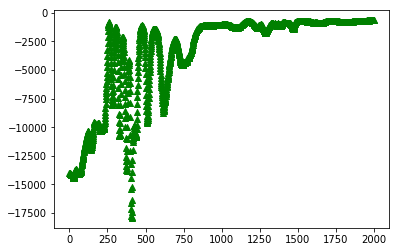

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot([1, 2, 3, 4], [10, 20, 25, 30], color='lightblue', linewidth=3) # plot line
ax.scatter(range(len(all_reward)), all_reward, color='green', marker='^') # plot points
# ax.set_xlim(0.5, 4.5)
plt.show()



v1


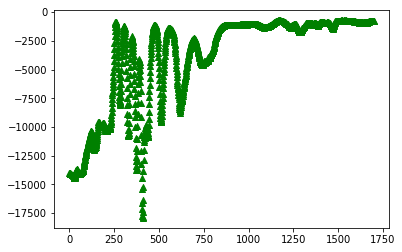

In [ ]:
### Critic Network Test

In [12]:
x = np.random.rand( agent.x_dim )*100

In [13]:
agent.sess.run(agent.y_pred, {agent.x: [[ -2453.09 ]]})[0]

array([ 138.19429016], dtype=float32)

In [ ]:
### Actor Output

In [16]:
agent.sess.run(agent.x, {agent.one: [[1.]]})[0]

array([  1.20598078,  15.11252308,  20.80213165,  46.02310944,
        57.10516739,  40.29685974,  67.06959534], dtype=float32)